In [1]:
from MLForecastPipeline import *

In [2]:
RUN_NUM = 'run_19'

In [48]:
selected_sensors_df = pd.read_csv("../data/selected_sensors2_cleaned.csv", index_col=0)

TEST_START_DATE = "2019-04-02"
scenarios_sensors = {
    # 0: 1, 4372603
    # "0_12M_train_7M_test": {"train_start": "2017-03-25", "train_end": "2018-03-25", "test_start": "2018-03-26", "test_end": "2018-10-10"},
    '2': {
        # "18M_train":  {"train_start": "2017-04-01", "train_end": "2018-10-01"},
        # "12M_train":  {"train_start": "2017-04-01", "train_end": "2018-04-01", "val_start": "2017-04-01", "val_end": "2018-04-01"},
        # "12M_train_3M_val":  {"train_start": "2017-04-01", "train_end": "2018-04-01", "val_start": "2018-04-01", "val_end": "2018-07-01"},
        "12M_train_6M_val":  {"train_start": "2017-04-01", "train_end": "2018-04-01", "val_start": "2018-04-01", "val_end": "2018-10-01"},
        "12M_train_9M_val":  {"train_start": "2017-04-01", "train_end": "2018-04-01", "val_start": "2018-04-01", "val_end": "2019-01-01"},
        "12M_train_12M_val":  {"train_start": "2017-04-01", "train_end": "2018-04-01", "val_start": "2018-04-01", "val_end": "2019-04-01"},
        },
}
scenarios_sensors['5'] = scenarios_sensors['2'].copy()
scenarios_sensors['6'] = scenarios_sensors['2'].copy()

if RUN_NUM == 'run_19':
    TEST_START_DATE = "2019-04-02"
    scenarios_sensors = {
        # 0: 1, 4372603
        # "0_12M_train_7M_test": {"train_start": "2017-03-25", "train_end": "2018-03-25", "test_start": "2018-03-26", "test_end": "2018-10-10"},
        '5': {
            "24M_train":  {"train_start": "2017-04-01", "train_end": "2019-04-01"},
            "12M_train_12M_val":  {"train_start": "2017-04-01", "train_end": "2018-04-01", "val_start": "2018-04-01", "val_end": "2019-04-01"},
            "16M_train_8M_val":  {"train_start": "2017-04-01", "train_end": "2018-08-01", "val_start": "2018-08-01", "val_end": "2019-04-01"},
            "20M_train_4M_val":  {"train_start": "2017-04-01", "train_end": "2019-01-01", "val_start": "2019-01-01", "val_end": "2019-04-01"},
            "24M_train_24M_val":  {"train_start": "2017-04-01", "train_end": "2019-04-01", "val_start": "2017-04-01", "val_end": "2019-04-01"},
            },
    }
    scenarios_sensors['6'] = scenarios_sensors['5'].copy()
    scenarios_sensors['2'] = scenarios_sensors['5'].copy()

def split_data(df, scenario, date_col="ds"):
    """Extracts train and test data based on train end date."""
    train_data = df[df[date_col] <= scenario['train_end']]
    test_start = pd.to_datetime(scenario['train_end']) + pd.Timedelta(days=1)
    test_data = df[df[date_col] >= test_start]
    return train_data, test_data

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

LAG_TRANSFORMS_MAP = {
    "expanding_mean_rolling_14_rolling_30": {1: 'expanding_mean', 7: 'expanding_mean', 30: 'rolling_mean_30'},
    "expanding_mean_rolling_14": {1: 'expanding_mean', 7: 'rolling_mean_14', 30: 'expanding_mean'},
    "rolling_14_rolling_30_expanding": {1: 'rolling_mean_14', 7: 'rolling_mean_30', 30: 'expanding_mean'},
    "rolling_14_expanding": {1: 'rolling_mean_14', 30: 'expanding_mean'},
    "rolling_14_only": {1: 'rolling_mean_14'},
    "no_transform": {},
}

def map_lag_transforms(lag_transform_dict, lag_transforms_map=LAG_TRANSFORMS_MAP):
    for name, transform in lag_transforms_map.items():
        if lag_transform_dict == transform:
            return name
    return "unknown"

def analyze_results(df, lag_transforms_map=LAG_TRANSFORMS_MAP, mape_threshold=40, model_filter=None):
    df = df.copy()
    df['Lag Transform Name'] = df['Lag Transforms'].apply(lambda x: map_lag_transforms(x, lag_transforms_map))
    df['Lag_Set_Name'] = df['Lag Name']
    # Identify MAPE columns dynamically
    mape_columns = [col for col in df.columns if col.startswith("test_") and col.endswith("_days")]
    
    # Compute mean MAPE across all test periods
    df['MAPE'] = df[mape_columns].mean(axis=1)
    
    # Apply filtering
    top_df = df[df["MAPE"] < mape_threshold].copy()
    if model_filter:
        top_df = top_df[top_df['Model'] == model_filter].copy()
    
    # Compute groupings
    top_models = top_df.groupby("Model")["MAPE"].mean().sort_values().reset_index()
    top_transforms = top_df.groupby("Transforms")["MAPE"].mean().sort_values().reset_index()
    top_lag_transforms = top_df.groupby("Lag Transform Name")["MAPE"].mean().sort_values().reset_index()
    top_lags = top_df.groupby("Lag_Set_Name")["MAPE"].mean().sort_values().reset_index()
    
    # Compute MAPE trends over different forecasting horizons
    mape_trends = top_df.groupby("Model")[mape_columns].mean().reset_index()
    
    return top_models, top_transforms, top_lag_transforms, top_lags, mape_trends

def plot_results(top_models, top_transforms, top_lag_transforms, top_lags, mape_trends):
    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_models["Model"], y=top_models["MAPE"], palette="viridis", hue=top_models["Model"])
    plt.xticks(rotation=45)
    plt.title("Average MAPE per Model")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_transforms["Transforms"], y=top_transforms["MAPE"], palette="coolwarm", hue=top_transforms["Transforms"])
    plt.xticks(rotation=90)
    plt.title("Average MAPE per Transform")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_lag_transforms["Lag Transform Name"], y=top_lag_transforms["MAPE"], palette="Blues", hue=top_lag_transforms["Lag Transform Name"])
    plt.xticks(rotation=90)
    plt.title("Average MAPE per Lag Transform")
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_lags["Lag_Set_Name"], y=top_lags["MAPE"], palette="Blues", hue=top_lags["Lag_Set_Name"])
    plt.xticks(rotation=90)
    plt.title("MAPE vs Number of Lags")
    plt.show()
    
    # Plot MAPE trends across different forecasting horizons
    plt.figure(figsize=(12, 5))
    for model in mape_trends["Model"]:
        plt.plot(mape_trends.columns[1:], mape_trends[mape_trends["Model"] == model].values[0][1:], label=model)
    plt.xlabel("Forecasting Horizon (Days)")
    plt.ylabel("MAPE")
    plt.title("MAPE Trends Across Forecast Horizons")
    plt.legend()
    plt.show()

# Example usage:
# top_models, top_transforms, top_lag_transforms, top_lags, mape_trends = analyze_results(df, lag_transforms_map, optimal_lags_map)
# plot_results(top_models, top_transforms, top_lag_transforms, top_lags, mape_trends)


In [50]:
import glob
results = {}
for file in glob.glob(f"results/{RUN_NUM}/*.csv"):
    dataset_name = file.split("\\")[-1].replace(".csv", "")
    try:
        results[dataset_name] = pd.read_csv(file)
    except Exception as e:
        print(e)        

In [51]:
import re

def extract_train_info(dataset_name):
    """
    Extracts sensor ID, training length in months, and a standardized train label.
    
    Example Inputs:
        - "6_NH_15D_train"  → (6, 0.5, "NH_15D_train")
        - "6_H_5M_train"    → (6, 5, "H_5M_train")
        - "2_18M_train"     → (2, 18, "18M_train")
    
    Returns:
        - sensor (int): Sensor ID
        - train_months (float): Training length in months
        - train_label (str): Everything after the sensor ID (used for finding comparable datasets)
    """
    name_parts = dataset_name.split('_')

    # Extract sensor ID
    sensor = int(name_parts[0])  # First part is always the sensor number

    # Reconstruct the label for easy dataset comparison
    train_label = '_'.join(name_parts[1:])

    # Extract training length (2nd to last part contains number + unit)
    train_info = name_parts[-2]  # Example: "15D" or "5M"
    match = re.match(r"(\d+)([MD])", train_info)  # Extract number and unit

    if match:
        train_length = int(match.group(1))
        unit = match.group(2)

        # Convert days to months (approximate)
        train_months = train_length / 30 if unit == "D" else train_length
    else:
        return None, None, None  # Invalid format, return None values

    return sensor, train_months, train_label

# Example Usage
datasets = ["6_NH_15D_train", "6_H_5M_train", "2_18M_train"]
for ds in datasets:
    print(f"{ds} → {extract_train_info(ds)}")


6_NH_15D_train → (6, 0.5, 'NH_15D_train')
6_H_5M_train → (6, 5, 'H_5M_train')
2_18M_train → (2, 18, '18M_train')


In [52]:
import re
import pandas as pd
import numpy as np
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)

@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

# Define function mapping
lag_transforms_mapping = {
    'expanding_mean': expanding_mean,
    'rolling_mean_14': rolling_mean_14,
    'rolling_mean_30': rolling_mean_30,
}

# Function to convert lag_transforms dictionary to a string
def stringify_lag_transforms(lag_transforms):
    """Converts lag_transforms dictionary to a clean string format for storage."""
    return str({key: [func.__name__ for func in funcs] for key, funcs in lag_transforms.items()})

# Function to parse lag_transforms safely from an invalid dictionary-like string
def parse_lag_transforms(lag_transforms_str):
    """Parses a raw function dictionary string and converts it back to a proper dictionary with function references."""
    try:
        # Extract function names using regex pattern: `<function function_name at 0x...>`
        cleaned_str = re.sub(r'<function (\w+) at 0x[0-9A-Fa-f]+>', r'"\1"', lag_transforms_str)

        # Convert cleaned string into a valid Python dictionary
        temp_dict = eval(cleaned_str)  # Evaluates after function names are fixed

        # Map function names back to actual function references
        return {key: [lag_transforms_mapping[func_name] for func_name in funcs] for key, funcs in temp_dict.items()}
    
    except Exception as e:
        # print(f"Error parsing lag_transforms {lag_transforms_str}: {e}")
        return 1
    
from mlforecast.lag_transforms import *

lag_transform_mapping = {
    'RollingMean': RollingMean,
    'ExpandingMean': ExpandingMean,
    'ExponentiallyWeightedMean': ExponentiallyWeightedMean,
}
def create_lag_transform_object(transform_str):
    """Creates a lag transform object from a string representation."""
    class_name = transform_str.split('(')[0].strip()
    params_str = transform_str[transform_str.find('(') + 1:transform_str.find(')')] if '(' in transform_str else None
    params = {}
    if params_str:
        for param in params_str.split(','):
            key, value = param.split('=')
            params[key.strip()] = int(value.strip())  # Assuming numerical parameters

    if class_name in lag_transform_mapping:
        return lag_transform_mapping[class_name](**params) if params else lag_transform_mapping[class_name]()
    else:
        raise ValueError(f"Unknown lag transform: {class_name}")

from collections import defaultdict
def parse_lag_transforms_mlfcst(initial_lag_transforms_str):
    """Parses the string representation of lag transforms into a dictionary."""
    lag_transforms = defaultdict(list)  # Use defaultdict for easier handling
    if isinstance(initial_lag_transforms_str, str):
        try:
            # Split the string into individual lag and transform groups
            transform_groups = initial_lag_transforms_str.strip("{}").split(", ")

            for group in transform_groups:
                lag_str, transform_strs_list = group.split(": ")
                lag = int(lag_str)

                # Remove brackets and split the transform strings
                transform_strs = transform_strs_list.strip("[]").split(", ")

                for transform_str in transform_strs:
                    # Clean the transform string (remove quotes and any extra spaces)
                    clean_transform_str = transform_str.strip().strip("'")

                    # Create transform object and append to the list
                    transform_object = create_lag_transform_object(clean_transform_str)
                    lag_transforms[lag].append(transform_object)

        except ValueError as e:
            print(f"Error parsing lag transforms string: {e}")
            return {}  # Or raise the exception

    return dict(lag_transforms)

def get_lag_transforms(lag_transform_str):
    lag_transforms = parse_lag_transforms(lag_transform_str)
    if lag_transforms == 1:
        return parse_lag_transforms_mlfcst(lag_transform_str)
    return lag_transforms

# Example input with incorrect function references
initial_lag_transforms_str = "{1: [<function expanding_mean at 0x0000021CAC0F2840>], 7: [<function rolling_mean_14 at 0x0000021CA47C3C40>], 30: [<function expanding_mean at 0x0000021CAC0F2840>]}"

# Convert to proper lag_transforms dictionary
parsed_lag_transforms = get_lag_transforms(initial_lag_transforms_str)

print("String Input:", initial_lag_transforms_str)
print("Parsed Back:", parsed_lag_transforms)


String Input: {1: [<function expanding_mean at 0x0000021CAC0F2840>], 7: [<function rolling_mean_14 at 0x0000021CA47C3C40>], 30: [<function expanding_mean at 0x0000021CAC0F2840>]}
Parsed Back: {1: [<function expanding_mean at 0x000002C5E21B8180>], 7: [<function rolling_mean_14 at 0x000002C5F7C079C0>], 30: [<function expanding_mean at 0x000002C5E21B8180>]}


In [53]:
initial_lag_transforms_str = "{7: [RollingMean(window_size=7)], 30: [RollingMean(window_size=30)], 60: [RollingMean(window_size=60)]}"
get_lag_transforms(initial_lag_transforms_str)

{7: [RollingMean(window_size=7)],
 30: [RollingMean(window_size=30)],
 60: [RollingMean(window_size=60)]}

In [54]:
import pandas as pd
import numpy as np
import re
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from mlforecast import MLForecast
from lightgbm import LGBMRegressor
# from my_custom_utils import format_df_to_mlforecast, split_data  # Assuming these are in a module
import ast

# Define parameters


# Define available lag transforms
lag_transforms_options = [
    {1: [expanding_mean], 7: [rolling_mean], 30: [expanding_mean]},
    {1: [rolling_mean], 7: [rolling_mean], 30: [expanding_mean]},
]

model_mapping = {
    "XGBRegressor": XGBRegressor(),
    "SGDRegressor_42": SGDRegressor(random_state=42),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "SGD_EarlyStopping": SGDRegressor( random_state=42, early_stopping=True, validation_fraction=0.1, n_iter_no_change=7, tol=1e-4 ),
    "SGD_ElasticNet": SGDRegressor( penalty='elasticnet', l1_ratio=0.5, alpha=0.001, random_state=42 ),
    "SGD_Lasso": SGDRegressor( penalty='l1', alpha=1, random_state=42 ),
    "SGD_Ridge": SGDRegressor( penalty='l2', alpha=1, random_state=42 ),
    "SGD_Optuna": SGDRegressor( penalty='elasticnet', l1_ratio=0.5, alpha=0.001, random_state=42 ),
    "SGDRegressor": SGDRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(),
    "LGBMRegressor": LGBMRegressor(),
}

transform_mapping = {
    "AutoDifferences" : AutoDifferences, 
    "AutoSeasonalDifferences" : AutoSeasonalDifferences, 
    "AutoSeasonalityAndDifferences" : AutoSeasonalityAndDifferences,
    "LocalStandardScaler" : LocalStandardScaler, 
    "LocalMinMaxScaler" : LocalMinMaxScaler, 
    "LocalBoxCox" : LocalBoxCox
}

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)

@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

# Function to extract sensor ID and train length
def extract_train_info(dataset_name):
    name_parts = dataset_name.split('_')
    sensor = int(name_parts[0])  
    train_label = '_'.join(name_parts[1:])

    if len(name_parts) > 3:
        train_info = name_parts[-4]  
    else:
        train_info = name_parts[-2] 
    match = re.match(r"(\d+)([MD])", train_info)  

    if match:
        train_length = int(match.group(1))
        unit = match.group(2)
        train_months = train_length / 30 if unit == "D" else train_length
    else:
        return None, None, None  
    print(sensor, train_months, train_label)
    return sensor, train_months, train_label

# Function to reverse `stringify_transform`
def parse_transform_string(transform_str):
    transform_str = transform_str.strip()
    if "(" in transform_str:
        class_name, params = transform_str.split("(", 1)
        params = params.rstrip(")")
        param_dict = {}
        if params != "NoParams" and class_name != "LocalBoxCox":
            for param in params.split(", "):
                key, value = param.split("=")
                if key in ("max_diffs", "season_length", "max_season_length"):
                    param_dict[key] = int(value) if value.replace(".", "").isdigit() else value
        return class_name, param_dict
    return transform_str, {}

In [55]:
# Define patterns to match and their correct format
rename_patterns = {
    "H_3M_jul_train": "H_jul_3M_train",
    "H_3M_sep_train": "H_sep_3M_train",
    "H_3M_nov_train": "H_nov_3M_train",
}

# Create a new dictionary with updated keys
updated_results = {}

for dataset_name, df in results.items():
    new_name = dataset_name  # Default: keep the same name

    for old_pattern, new_pattern in rename_patterns.items():
        if old_pattern in dataset_name:
            new_name = dataset_name.replace(old_pattern, new_pattern)
            break  # Stop checking once renamed

    updated_results[new_name] = df  # Preserve the dataset content

results = updated_results

In [56]:
import warnings
import pandas as pd

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [57]:
from datetime import datetime
from collections import defaultdict

def calculate_monthly_mape(predictions_df, date_col='ds', actual_col='y', forecast_col='forecast', id_col='unique_id'):
    """
    Calculate MAPE (Mean Absolute Percentage Error) for each month-year in the predictions dataframe.
    
    Returns:
    --------
    dict
        Dictionary with keys as 'month_year' (e.g., 'Jan_2019') and values as MAPE for that month
    dict
        Dictionary with keys as 'month_year' and values as sample counts for that month
    pandas.DataFrame
        DataFrame with detailed MAPE information by month-year and entity
    dict
        Dictionary with keys as (year, month) tuples and values as MAPE for that year and month
    """
    # Ensure the date column is datetime
    df = predictions_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col])
    
    # Create month-year column for string representation
    df['month_year'] = df[date_col].dt.strftime('%b_%Y')
    
    # Create separate year and month columns
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month  # Numeric month (1-12)
    df['month_name'] = df[date_col].dt.strftime('%b')  # Month abbreviation
    
    # Calculate absolute percentage error for each row
    df['abs_pct_error'] = np.abs((df[actual_col] - df[forecast_col]) / df[actual_col])
    
    # Replace inf and NaN values (occurs when actual value is 0)
    df['abs_pct_error'] = df['abs_pct_error'].replace([np.inf, -np.inf], np.nan)
    
    # Initialize results dictionaries
    mape_by_month_year = {}  # String format: 'Jan_2019'
    mape_by_year_month = {}  # Tuple format: (2019, 1)
    sample_counts = {}
    
    # Calculate MAPE for each month-year
    for month_year, group in df.groupby('month_year'):
        mape = group['abs_pct_error'].mean() * 100  # Convert to percentage
        mape_by_month_year[month_year] = mape if not pd.isna(mape) else None
        sample_counts[month_year] = len(group)
    
    # Calculate MAPE for each year, month tuple
    for (year, month), group in df.groupby(['year', 'month']):
        mape = group['abs_pct_error'].mean() * 100  # Convert to percentage
        mape_by_year_month[(year, month)] = mape if not pd.isna(mape) else None
    
    # Also calculate MAPE by month-year-entity for detailed analysis
    detailed_results = []
    for (year, month, entity_id), group in df.groupby(['year', 'month', id_col]):
        month_name = group['month_name'].iloc[0]
        month_year = group['month_year'].iloc[0]
        mape = group['abs_pct_error'].mean() * 100  # Convert to percentage
        detailed_results.append({
            'year': year,
            'month': month,
            'month_name': month_name,
            'month_year': month_year,
            'entity_id': entity_id,
            'mape': mape if not pd.isna(mape) else None,
            'sample_count': len(group)
        })
    
    detailed_df = pd.DataFrame(detailed_results)
    
    # Sort the dictionaries by date for easier interpretation
    sorted_month_years = sorted(mape_by_month_year.keys(), 
                               key=lambda x: datetime.strptime(x, '%b_%Y'))
    
    sorted_mape = {month_year: mape_by_month_year[month_year] for month_year in sorted_month_years}
    sorted_counts = {month_year: sample_counts[month_year] for month_year in sorted_month_years}
    
    return sorted_mape, sorted_counts, detailed_df, mape_by_year_month

def get_monthly_aggregated_mape(predictions_df, date_col='ds', actual_col='y', forecast_col='forecast'):
    """
    Calculate MAPE for each month (e.g., January, February) aggregated across all years.
    
    Parameters:
    -----------
    Same as calculate_monthly_mape
        
    Returns:
    --------
    dict
        Dictionary with keys as month names (e.g., 'Jan', 'Feb') and values as MAPE for that month across all years
    """
    # Ensure the date column is datetime
    df = predictions_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col])
    
    # Create month column
    df['month'] = df[date_col].dt.strftime('%b')
    
    # Calculate absolute percentage error for each row
    df['abs_pct_error'] = np.abs((df[actual_col] - df[forecast_col]) / df[actual_col])
    df['abs_pct_error'] = df['abs_pct_error'].replace([np.inf, -np.inf], np.nan)
    
    # Calculate MAPE for each month across all years
    mape_by_month = {}
    for month, group in df.groupby('month'):
        mape = group['abs_pct_error'].mean() * 100
        mape_by_month[month] = mape if not pd.isna(mape) else None
    
    # Sort months in calendar order
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    sorted_mape = {month: mape_by_month.get(month) for month in month_order if month in mape_by_month}
    
    return sorted_mape

In [58]:
run_threshold_map = {
    'run_12': [30, 30, 30], # no weights new models and lag transforms 
    'run_13': [30, 30, 30], # run_12 + weigths
    # from here saving preds, months, cumulative
    'run_14': [30, 30, 30], # roll 7
    'run_15': [30, 30, 30], # resids from prophet_2_sensor
}

In [59]:
def raw_str_preds_to_list(preds_string_raw):    
    preds_list = []
    if pd.notna(preds_string_raw) and isinstance(preds_string_raw, str):
        # 1. Remove leading/trailing brackets and whitespace
        cleaned_string = preds_string_raw.strip('[]').strip()

        # 2. Replace newline characters (if any) with spaces
        cleaned_string = cleaned_string.replace('\n', ' ')

        # 3. Split the string by spaces. This handles multiple spaces between numbers.
        string_values = cleaned_string.split()

        # 4. Convert each resulting string element to a float
        try:
            preds_list = [float(val) for val in string_values]
            return preds_list
        except ValueError:
            print(f"Warning: Could not convert all elements in '{preds_string_raw}' to float.")
    else:
        print(f"Warning: 'preds' column value is missing or not a string: {preds_string_raw}")
    raise KeyError('nope')

In [60]:
import hashlib
import joblib
import json
import pandas as pd
import os
import ast  # Import ast
from joblib import Parallel, delayed

failed_models_log = f"results_of_results/{RUN_NUM}_failed_models_log.txt"

HORIZONS = [30, 60, 90, 120, 150, 180, 240, 300, 360, 480, 600, 720, 737]
MAPE_COLUMNS = [f"test_{h}_days" for h in HORIZONS]
EARLY_HORIZON_THRESHOLD = 40  # MAPE threshold for early horizons
ONE_THIRD_THRESHOLD = 40       # Threshold for MAPE at 1/3 of training length
ONE_THIRD_THRESHOLD_GENERAL = 40       # Threshold for MAPE at 1/3 of training length
EARLY_HORIZONS = [30, 60, 90, 120]  # Horizons we check for early filtering
SENSORS_TO_COMPARE = [2, 5, 6]  # Sensors that share training length criteria

LONG_TRAIN_FILTER = False

# Ensure directory exists
save_dir = f"results_of_results/{RUN_NUM}"
os.makedirs(save_dir, exist_ok=True)  # Creates the directory if it doesn't exist

# Function to create a unique hash based on model parameters
def generate_model_hash(model_name, transforms, lags, lag_transforms):
    """Creates a short unique hash for the model based on its features & transforms."""
    hash_input = f"{model_name}_{transforms}_{lags}_{lag_transforms}"
    return hashlib.md5(hash_input.encode()).hexdigest()[:8]  # Take only the first 8 characters

# Dictionary to store information about passed models
passed_models_info = {}
good_winter_models = []
from mlforecast.lag_transforms import RollingMean, ExpandingMean, ExponentiallyWeightedMean

def calculate_val_test_mape(predictions_df, scenario, date_col='ds', actual_col='y', forecast_col='forecast', id_col='unique_id'):
    val_mape = 0
    if 'val_start' in scenario:
        val_df = predictions_df[(predictions_df[date_col] > scenario['val_start']) & (predictions_df[date_col] <= scenario['val_end'])]
        val_mape = mape_met(val_df[actual_col], val_df[forecast_col])

    test_df = predictions_df[predictions_df[date_col] >= TEST_START_DATE]
    test_mape =  mape_met(test_df[actual_col], test_df[forecast_col])

    return val_mape, test_mape

def process_row(row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors):
    """Processes a single row (model) from the filtered DataFrame."""
    model_name = row["Model"]
    transforms_str = row["Transforms"]
    lags = row["Lags"]
    lag_transforms_str = row["Lag Transforms"]

    regex_pattern = r"^test_\d+_days$"
    test_cumul_dict = {col:row[col] for col in row.index if re.match(regex_pattern, col)}

    # Prepare dataset
    sensor_id = str(sensor_id)
    scenario = scenarios_sensors[sensor_id][train_label]

    if sensor_id not in scenarios_sensors:
        return None  # Skip this model

    formatted_df = format_df_to_mlforecast(
        selected_sensors_df[['full_date', sensor_id]], 'full_date', sensor_id, unique_id=sensor_id
    )
    formatted_df = formatted_df[['ds', 'y', 'unique_id']]
    train_df, test_df = split_data(formatted_df, scenario)

    test_df_copy = test_df.copy()
    test_df_copy['forecast'] = raw_str_preds_to_list(row['preds'])

    val_mape, test_mape = calculate_val_test_mape(test_df_copy, scenario)

    sorted_mape, sorted_counts, detailed_df, mape_by_year_month = calculate_monthly_mape(test_df_copy)

    winter_months = [1, 2, 3, 10, 11, 12]  # Jan, Feb, Mar, Oct, Nov, Dec
    winter_mape_full = detailed_df[detailed_df['month'].isin(winter_months)]
    mean_winter_mape = winter_mape_full['mape'].mean()
    year_winter_mean_mape = winter_mape_full.groupby('year')['mape'].mean().to_dict()

    if mean_winter_mape < 1000:
        plot_data = {
            'test_df_copy': test_df_copy,
            'model_name': model_name,
            'dataset_name': dataset_name
        }
        return {
            'dataset': dataset_name,
            'model_name': model_name,
            'transforms_str': transforms_str,
            'lags': lags,
            'lag_transforms_str': lag_transforms_str,
            'val_mape': val_mape,
            'test_mape': test_mape,
            'mean_winter_mape': mean_winter_mape,
            **year_winter_mean_mape,
            'sorted_mape': sorted_mape,
            'plot_data': plot_data,
            'test_vals': test_cumul_dict,
            'params': row['params'],
        }
    else:
        return None  # Model didn't meet criteria

DATASET: 2_24M_train
2 24 24M_train
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
231  SGD_Optuna     17.044437     16.965753     15.868981      21.508810   
247  SGD_Optuna     17.044437     16.965753     15.868981      21.508810   
255  SGD_Optuna     17.044437     16.965753     15.868981      21.508810   
230  SGD_Optuna     17.025571     16.962452     15.892140      21.506019   
246  SGD_Optuna     17.025571     16.962452     15.892140      21.506019   
199  SGD_Optuna     16.723643     17.745122     18.588598      19.844622   
215  SGD_Optuna     16.723643     17.745122     18.588598      19.844622   
223  SGD_Optuna     16.723643     17.745122     18.588598      19.844622   
198  SGD_Optuna     16.723839     17.750173     18.632516      19.876480   
214  SGD_Optuna     16.723839     17.750173     18.632516      19.876480   

     test_360_days  
231      25.788490  
247      25.788490  
255      25.788490  
230      25.786564  
246      25.786564  
1

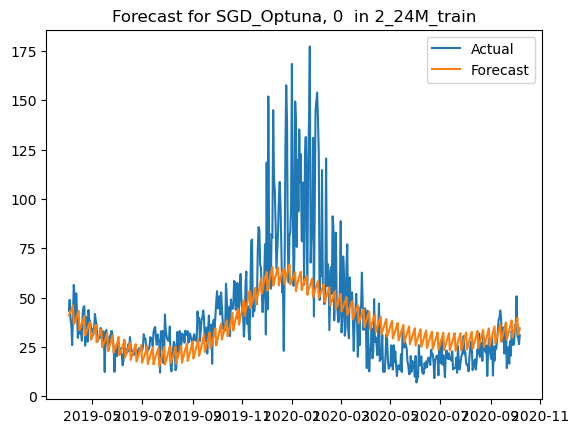

{'Apr_2019': 17.24733702766539, 'May_2019': 16.70233488803271, 'Jun_2019': 13.675438594375544, 'Jul_2019': 31.06216387949044, 'Aug_2019': 25.46607108115596, 'Sep_2019': 25.051522470419158, 'Oct_2019': 22.414926104512293, 'Nov_2019': 26.265890633168667, 'Dec_2019': 35.24990663523703, 'Jan_2020': 41.127745065637264, 'Feb_2020': 25.880515206666043, 'Mar_2020': 27.616448334796946, 'Apr_2020': 75.36112963110772, 'May_2020': 95.5441375515641, 'Jun_2020': 88.62341274748205, 'Jul_2020': 54.34933819649381, 'Aug_2020': 47.71278365466933, 'Sep_2020': 35.38726908490606, 'Oct_2020': 14.655093457906965}
{'test_30_days': 17.04443722259635, 'test_60_days': 16.965752586899555, 'test_90_days': 15.868981255422282, 'test_120_days': 19.608834889138635, 'test_150_days': 21.05310937883844, 'test_180_days': 21.50880954530713, 'test_240_days': 22.056727543796217, 'test_300_days': 25.08674109667539, 'test_360_days': 25.78849036007905, 'test_480_days': 38.84428550941168, 'test_600_days': 38.91685545897147, 'test

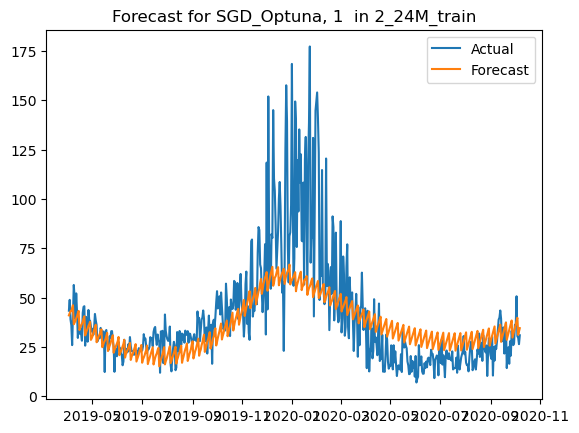

{'Apr_2019': 17.24733702766539, 'May_2019': 16.70233488803271, 'Jun_2019': 13.675438594375544, 'Jul_2019': 31.06216387949044, 'Aug_2019': 25.46607108115596, 'Sep_2019': 25.051522470419158, 'Oct_2019': 22.414926104512293, 'Nov_2019': 26.265890633168667, 'Dec_2019': 35.24990663523703, 'Jan_2020': 41.127745065637264, 'Feb_2020': 25.880515206666043, 'Mar_2020': 27.616448334796946, 'Apr_2020': 75.36112963110772, 'May_2020': 95.5441375515641, 'Jun_2020': 88.62341274748205, 'Jul_2020': 54.34933819649381, 'Aug_2020': 47.71278365466933, 'Sep_2020': 35.38726908490606, 'Oct_2020': 14.655093457906965}
{'test_30_days': 17.04443722259635, 'test_60_days': 16.965752586899555, 'test_90_days': 15.868981255422282, 'test_120_days': 19.608834889138635, 'test_150_days': 21.05310937883844, 'test_180_days': 21.50880954530713, 'test_240_days': 22.056727543796217, 'test_300_days': 25.08674109667539, 'test_360_days': 25.78849036007905, 'test_480_days': 38.84428550941168, 'test_600_days': 38.91685545897147, 'test

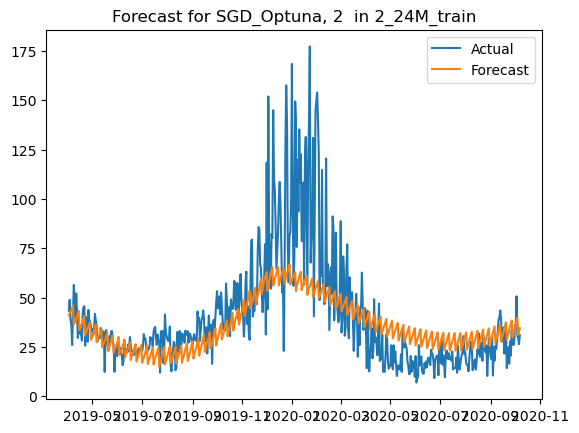

{'Apr_2019': 17.225393016504935, 'May_2019': 16.71647463761928, 'Jun_2019': 13.751516102209434, 'Jul_2019': 31.056837125335907, 'Aug_2019': 25.40418333460307, 'Sep_2019': 25.030902750920404, 'Oct_2019': 22.39779939959398, 'Nov_2019': 26.301467028117752, 'Dec_2019': 35.25831171550796, 'Jan_2020': 41.10868064343015, 'Feb_2020': 25.879335446230904, 'Mar_2020': 27.61442046504542, 'Apr_2020': 75.3845910034231, 'May_2020': 95.6393122492037, 'Jun_2020': 88.68100221784886, 'Jul_2020': 54.420398872347164, 'Aug_2020': 47.78824144765274, 'Sep_2020': 35.39641465583785, 'Oct_2020': 14.640984135926596}
{'test_30_days': 17.025570655949043, 'test_60_days': 16.962451850606172, 'test_90_days': 15.89213993266523, 'test_120_days': 19.6250321024035, 'test_150_days': 21.055021395002367, 'test_180_days': 21.506018761444032, 'test_240_days': 22.05611352149269, 'test_300_days': 25.085526215207388, 'test_360_days': 25.78656361904006, 'test_480_days': 38.857864827928026, 'test_600_days': 38.93413564283159, 'test

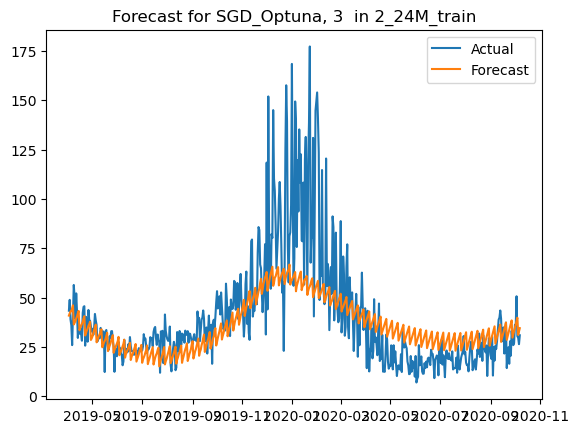

{'Apr_2019': 17.225393016504935, 'May_2019': 16.71647463761928, 'Jun_2019': 13.751516102209434, 'Jul_2019': 31.056837125335907, 'Aug_2019': 25.40418333460307, 'Sep_2019': 25.030902750920404, 'Oct_2019': 22.39779939959398, 'Nov_2019': 26.301467028117752, 'Dec_2019': 35.25831171550796, 'Jan_2020': 41.10868064343015, 'Feb_2020': 25.879335446230904, 'Mar_2020': 27.61442046504542, 'Apr_2020': 75.3845910034231, 'May_2020': 95.6393122492037, 'Jun_2020': 88.68100221784886, 'Jul_2020': 54.420398872347164, 'Aug_2020': 47.78824144765274, 'Sep_2020': 35.39641465583785, 'Oct_2020': 14.640984135926596}
{'test_30_days': 17.025570655949043, 'test_60_days': 16.962451850606172, 'test_90_days': 15.89213993266523, 'test_120_days': 19.6250321024035, 'test_150_days': 21.055021395002367, 'test_180_days': 21.506018761444032, 'test_240_days': 22.05611352149269, 'test_300_days': 25.085526215207388, 'test_360_days': 25.78656361904006, 'test_480_days': 38.857864827928026, 'test_600_days': 38.93413564283159, 'test

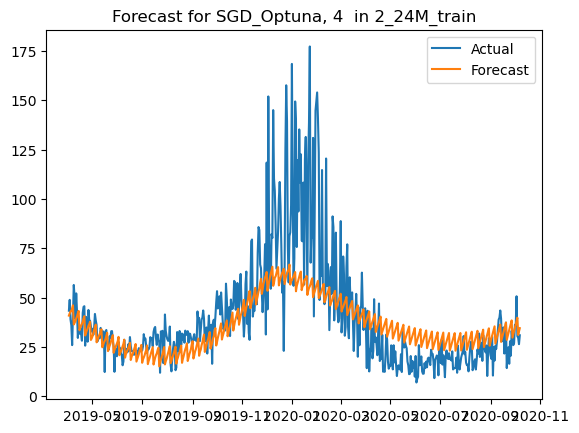

{'Apr_2019': 16.950665479266803, 'May_2019': 18.48832243156809, 'Jun_2019': 20.275551972908517, 'Jul_2019': 23.286425258880765, 'Aug_2019': 20.964737808038212, 'Sep_2019': 19.30886664275685, 'Oct_2019': 22.277388963622375, 'Nov_2019': 25.526877921728374, 'Dec_2019': 38.60307278838838, 'Jan_2020': 44.92223662129035, 'Feb_2020': 28.534371306021644, 'Mar_2020': 26.866497922558572, 'Apr_2020': 76.24754754956217, 'May_2020': 109.39148779014316, 'Jun_2020': 112.41784848091683, 'Jul_2020': 77.90274956126999, 'Aug_2020': 65.79685237125486, 'Sep_2020': 41.52566094183942, 'Oct_2020': 14.761539248434616}
{'test_30_days': 16.723643469988023, 'test_60_days': 17.745121568657066, 'test_90_days': 18.588598370320465, 'test_120_days': 19.76055029843833, 'test_150_days': 20.197733291918727, 'test_180_days': 19.844621522576656, 'test_240_days': 20.670945561233648, 'test_300_days': 24.70087473903404, 'test_360_days': 25.606873998674363, 'test_480_days': 42.39234134945404, 'test_600_days': 43.57650515781733

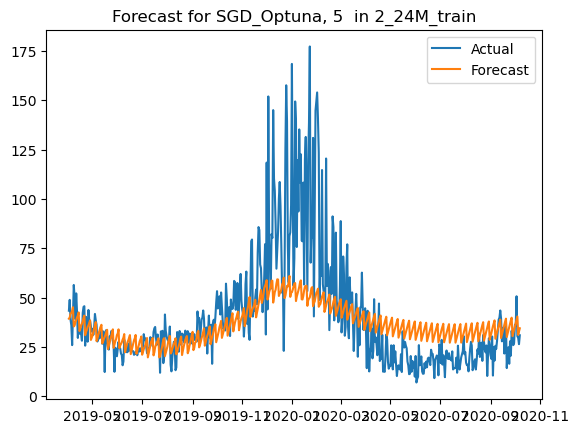

{'Apr_2019': 16.950665479266803, 'May_2019': 18.48832243156809, 'Jun_2019': 20.275551972908517, 'Jul_2019': 23.286425258880765, 'Aug_2019': 20.964737808038212, 'Sep_2019': 19.30886664275685, 'Oct_2019': 22.277388963622375, 'Nov_2019': 25.526877921728374, 'Dec_2019': 38.60307278838838, 'Jan_2020': 44.92223662129035, 'Feb_2020': 28.534371306021644, 'Mar_2020': 26.866497922558572, 'Apr_2020': 76.24754754956217, 'May_2020': 109.39148779014316, 'Jun_2020': 112.41784848091683, 'Jul_2020': 77.90274956126999, 'Aug_2020': 65.79685237125486, 'Sep_2020': 41.52566094183942, 'Oct_2020': 14.761539248434616}
{'test_30_days': 16.723643469988023, 'test_60_days': 17.745121568657066, 'test_90_days': 18.588598370320465, 'test_120_days': 19.76055029843833, 'test_150_days': 20.197733291918727, 'test_180_days': 19.844621522576656, 'test_240_days': 20.670945561233648, 'test_300_days': 24.70087473903404, 'test_360_days': 25.606873998674363, 'test_480_days': 42.39234134945404, 'test_600_days': 43.57650515781733

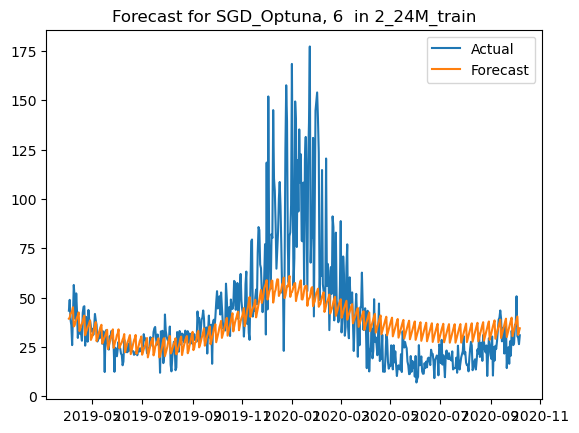

{'Apr_2019': 16.950665479266803, 'May_2019': 18.48832243156809, 'Jun_2019': 20.275551972908517, 'Jul_2019': 23.286425258880765, 'Aug_2019': 20.964737808038212, 'Sep_2019': 19.30886664275685, 'Oct_2019': 22.277388963622375, 'Nov_2019': 25.526877921728374, 'Dec_2019': 38.60307278838838, 'Jan_2020': 44.92223662129035, 'Feb_2020': 28.534371306021644, 'Mar_2020': 26.866497922558572, 'Apr_2020': 76.24754754956217, 'May_2020': 109.39148779014316, 'Jun_2020': 112.41784848091683, 'Jul_2020': 77.90274956126999, 'Aug_2020': 65.79685237125486, 'Sep_2020': 41.52566094183942, 'Oct_2020': 14.761539248434616}
{'test_30_days': 16.723643469988023, 'test_60_days': 17.745121568657066, 'test_90_days': 18.588598370320465, 'test_120_days': 19.76055029843833, 'test_150_days': 20.197733291918727, 'test_180_days': 19.844621522576656, 'test_240_days': 20.670945561233648, 'test_300_days': 24.70087473903404, 'test_360_days': 25.606873998674363, 'test_480_days': 42.39234134945404, 'test_600_days': 43.57650515781733

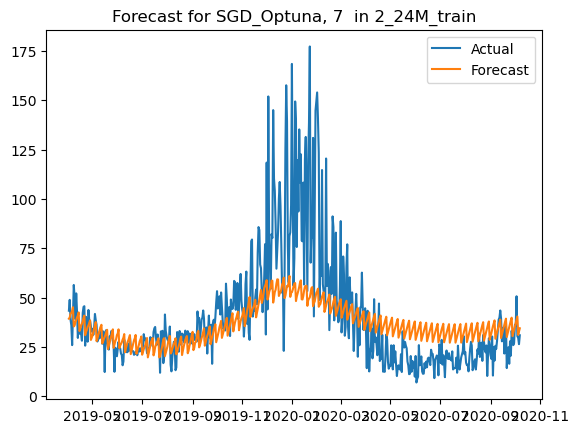

{'Apr_2019': 16.947818637892127, 'May_2019': 18.500763062258848, 'Jun_2019': 20.39720237951153, 'Jul_2019': 23.341319476398827, 'Aug_2019': 20.95435570204715, 'Sep_2019': 19.31973773074284, 'Oct_2019': 22.28124113908757, 'Nov_2019': 25.561309269321796, 'Dec_2019': 38.61863085539726, 'Jan_2020': 44.87058274861419, 'Feb_2020': 28.51876585628259, 'Mar_2020': 26.872328021605192, 'Apr_2020': 76.32454185110444, 'May_2020': 109.59306880373221, 'Jun_2020': 112.53767324492836, 'Jul_2020': 78.00563604269169, 'Aug_2020': 65.85422610758734, 'Sep_2020': 41.509573054411604, 'Oct_2020': 14.712972996361767}
{'test_30_days': 16.723839425297612, 'test_60_days': 17.750173257789545, 'test_90_days': 18.63251629962438, 'test_120_days': 19.8077501571927, 'test_150_days': 20.232739840432544, 'test_180_days': 19.87648043663453, 'test_240_days': 20.698966329554217, 'test_300_days': 24.72009143548572, 'test_360_days': 25.62138497368217, 'test_480_days': 42.43383722240946, 'test_600_days': 43.61563891312255, 'tes

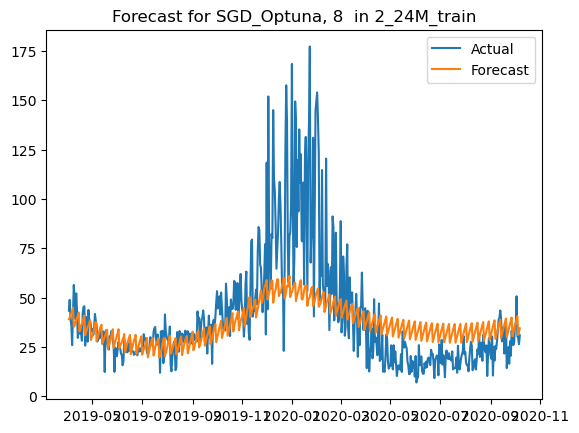

{'Apr_2019': 16.947818637892127, 'May_2019': 18.500763062258848, 'Jun_2019': 20.39720237951153, 'Jul_2019': 23.341319476398827, 'Aug_2019': 20.95435570204715, 'Sep_2019': 19.31973773074284, 'Oct_2019': 22.28124113908757, 'Nov_2019': 25.561309269321796, 'Dec_2019': 38.61863085539726, 'Jan_2020': 44.87058274861419, 'Feb_2020': 28.51876585628259, 'Mar_2020': 26.872328021605192, 'Apr_2020': 76.32454185110444, 'May_2020': 109.59306880373221, 'Jun_2020': 112.53767324492836, 'Jul_2020': 78.00563604269169, 'Aug_2020': 65.85422610758734, 'Sep_2020': 41.509573054411604, 'Oct_2020': 14.712972996361767}
{'test_30_days': 16.723839425297612, 'test_60_days': 17.750173257789545, 'test_90_days': 18.63251629962438, 'test_120_days': 19.8077501571927, 'test_150_days': 20.232739840432544, 'test_180_days': 19.87648043663453, 'test_240_days': 20.698966329554217, 'test_300_days': 24.72009143548572, 'test_360_days': 25.62138497368217, 'test_480_days': 42.43383722240946, 'test_600_days': 43.61563891312255, 'tes

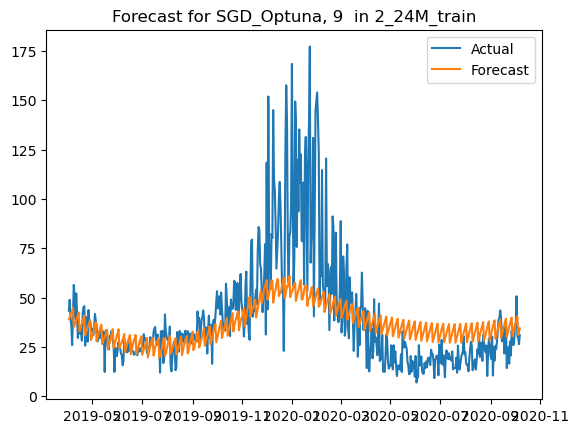

DATASET: 5_12M_train_12M_val
5 12 12M_train_12M_val
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
191  SGD_Optuna     23.514686     26.753845     27.814880      26.238491   
47   SGD_Optuna     23.135392     28.873811     27.475183      37.489089   
43   SGD_Optuna     23.738550     27.769719     27.298131      28.347064   
133  SGD_Optuna     23.775682     29.876651     28.495738      34.158176   
117  SGD_Optuna     23.485812     27.100721     28.707200      30.057412   
18   SGD_Optuna     27.752445     28.909466     28.228977      29.276124   
67   SGD_Optuna     26.219340     29.241057     28.846988      28.887405   

     test_360_days  
191      44.509744  
47       42.858866  
43       37.652921  
133      39.407086  
117      44.516863  
18       40.836351  
67       36.454156  


KeyboardInterrupt: 

In [62]:
# Process each dataset
for dataset_name, df in results.items():
# for dataset_name, df in results_left.items():
    print("=" * 80)
    print(f"DATASET: {dataset_name}")
    print("=" * 80)

    sensor_id, train_months, train_label = extract_train_info(dataset_name)

    if sensor_id is None:
        print("Skipping dataset: Cannot determine sensor ID or train length.")
        continue
    if train_months < 10:
        continue
    mape_columns_local = [c for c in MAPE_COLUMNS if c in df.columns]
    # print('here')
    # --- (a) Filtering Criteria ---

    # 1. Remove models exceeding the early horizon threshold
    local_early_horizons_threshold = EARLY_HORIZON_THRESHOLD
    local_one_third_thresh = ONE_THIRD_THRESHOLD
    # if train_months <= 12:
    #     local_early_horizons_threshold = 25
    #     local_one_third_thresh = 27
    if LONG_TRAIN_FILTER and train_months >= 24:
        local_early_horizons_threshold = 27
        local_one_third_thresh = 27
    early_horizon_cols = [f"test_{h}_days" for h in EARLY_HORIZONS if f"test_{h}_days" in df.columns]
    mask_early_horizon = (df[early_horizon_cols] <= local_early_horizons_threshold).all(axis=1)

    # 2. Ensure MAPE is good at 1/3 of train length
    one_third_horizon = int(train_months * 30 // 3)
    closest_horizon = min(HORIZONS, key=lambda x: abs(x - one_third_horizon))

    if f"test_{closest_horizon}_days" in df.columns:
        mask_one_third = df[f"test_{closest_horizon}_days"] <= local_one_third_thresh
    else:
        mask_one_third = True

    top_early = pd.DataFrame()
    if early_horizon_cols:
        df['early_avg_mape'] = df[early_horizon_cols].mean(axis=1)
        top_early = df.nsmallest(5, 'early_avg_mape').copy()
    top_closest = pd.DataFrame()
    if closest_horizon:
        top_closest = df.nsmallest(5, f"test_{closest_horizon}_days").copy()


    # Apply filters
    # df_filtered = df[mask_early_horizon & mask_one_third].copy()
    df_filtered = pd.concat([top_early, top_closest]).drop_duplicates()
    # --- (b) Extract best models and reconstruct `MLForecast` ---
    # Use joblib to parallelize the processing of rows
    print(df_filtered[['Model', 'test_30_days', 'test_60_days', 'test_90_days', 'test_180_days', 'test_360_days']])

    # for _, row in df_filtered.iterrows():
        # process_row(row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors)
    results_list = Parallel(n_jobs=-1)(  # Use all available cores
        delayed(process_row)(row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors)
        for _, row in df_filtered.iterrows()
    )

    # Filter out None results (failed models or models not meeting criteria)
    good_winter_models.extend(r for r in results_list if r is not None)

    for index, result in enumerate(results_list):
        if result and 'plot_data' in result:
            plot_data = result['plot_data']
            test_df_copy = plot_data['test_df_copy']
            model_name = plot_data['model_name']
            dataset_name = plot_data['dataset_name']

            # Generate the plot
            print(result['sorted_mape'])
            print(result['test_vals'])
            plt.figure()  # Create a new figure for each plot
            plt.plot(test_df_copy['ds'], test_df_copy['y'], label='Actual')
            plt.plot(test_df_copy['ds'], test_df_copy['forecast'], label='Forecast')
            plt.title(f"Forecast for {model_name}, {index}  in {dataset_name}")
            plt.legend()
            plt.show()  


# After processing all datasets, convert to DataFrame (optional)
good_winter_models_df = pd.DataFrame(good_winter_models)

DATASET: 5_12M_train_12M_val
5 12 12M_train_12M_val
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
191  SGD_Optuna     23.514686     26.753845     27.814880      26.238491   
47   SGD_Optuna     23.135392     28.873811     27.475183      37.489089   
43   SGD_Optuna     23.738550     27.769719     27.298131      28.347064   
133  SGD_Optuna     23.775682     29.876651     28.495738      34.158176   
117  SGD_Optuna     23.485812     27.100721     28.707200      30.057412   
18   SGD_Optuna     27.752445     28.909466     28.228977      29.276124   
67   SGD_Optuna     26.219340     29.241057     28.846988      28.887405   

     test_360_days  
191      44.509744  
47       42.858866  
43       37.652921  
133      39.407086  
117      44.516863  
18       40.836351  
67       36.454156  
{'Apr_2018': 24.000582213707116, 'May_2018': 29.329477515003884, 'Jun_2018': 29.936949706303828, 'Jul_2018': 25.69093549588761, 'Aug_2018': 22.570618425418893, 'Sep_2018':

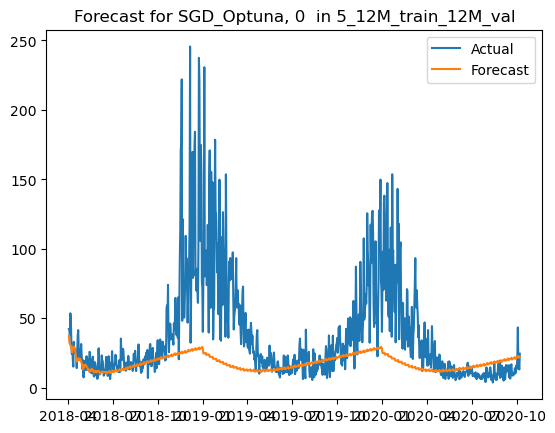

{'Apr_2018': 21.67651963432606, 'May_2018': 35.60676088282598, 'Jun_2018': 24.677927956746444, 'Jul_2018': 24.602876868740488, 'Aug_2018': 37.93587378391358, 'Sep_2018': 80.57624168269464, 'Oct_2018': 72.792348848935, 'Nov_2018': 50.605404641324434, 'Dec_2018': 44.22472645394753, 'Jan_2019': 35.71059808948623, 'Feb_2019': 40.9956591347434, 'Mar_2019': 44.933683324655746, 'Apr_2019': 56.198867891103035, 'May_2019': 92.42952575006714, 'Jun_2019': 114.42226338785255, 'Jul_2019': 93.03691325021299, 'Aug_2019': 39.8261167665744, 'Sep_2019': 53.0832124988476, 'Oct_2019': 54.15760686546762, 'Nov_2019': 57.04917341182907, 'Dec_2019': 57.39524522360321, 'Jan_2020': 31.057820964081586, 'Feb_2020': 33.50495742526868, 'Mar_2020': 44.210970022946036, 'Apr_2020': 72.76528625235184, 'May_2020': 135.08514753158514, 'Jun_2020': 161.4905521704952, 'Jul_2020': 130.72840579098616, 'Aug_2020': 45.34275767745702, 'Sep_2020': 102.54241553746868, 'Oct_2020': 83.37059654798816}
{'test_30_days': 23.135392026389

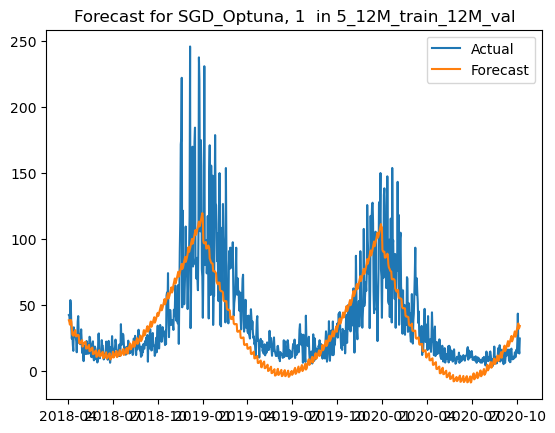

{'Apr_2018': 22.31494735520302, 'May_2018': 32.87257055284367, 'Jun_2018': 26.3549550200963, 'Jul_2018': 32.9257523437004, 'Aug_2018': 25.82356224124498, 'Sep_2018': 28.40120696624386, 'Oct_2018': 21.59494182800305, 'Nov_2018': 36.80527315210859, 'Dec_2018': 46.91622534210849, 'Jan_2019': 51.80605043314772, 'Feb_2019': 60.03721789502608, 'Mar_2019': 70.55438154206489, 'Apr_2019': 66.94488744020967, 'May_2019': 63.04496292581621, 'Jun_2019': 40.871229154594765, 'Jul_2019': 44.746336543090415, 'Aug_2019': 48.60293971191752, 'Sep_2019': 74.54061047913159, 'Oct_2019': 41.782097459395914, 'Nov_2019': 32.13107572766324, 'Dec_2019': 40.618799970294745, 'Jan_2020': 33.787751902728424, 'Feb_2020': 32.96594568438888, 'Mar_2020': 37.793559255488944, 'Apr_2020': 32.395691020737324, 'May_2020': 68.21127171724636, 'Jun_2020': 74.49668557547456, 'Jul_2020': 176.23077292382675, 'Aug_2020': 223.61015814374662, 'Sep_2020': 269.20860409894243, 'Oct_2020': 140.43088850312196}
{'test_30_days': 23.738550191

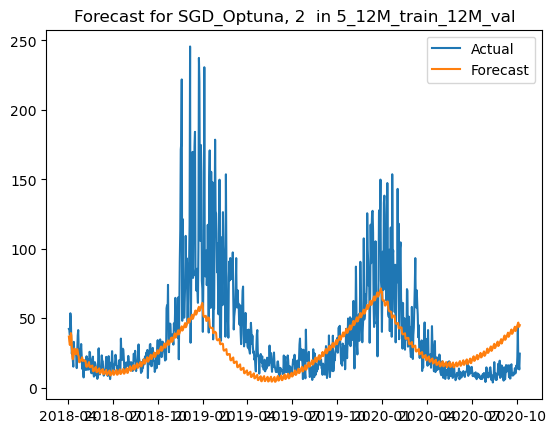

{'Apr_2018': 21.955591940098863, 'May_2018': 37.28667468876814, 'Jun_2018': 25.733912526664714, 'Jul_2018': 21.137640810056787, 'Aug_2018': 33.815582344624445, 'Sep_2018': 64.26912565090521, 'Oct_2018': 54.03235204808284, 'Nov_2018': 38.97245988841337, 'Dec_2018': 37.54345746726767, 'Jan_2019': 35.63528943436503, 'Feb_2019': 46.11753606421866, 'Mar_2019': 59.47065431816173, 'Apr_2019': 74.30700640336674, 'May_2019': 107.272103281536, 'Jun_2019': 125.10890850436847, 'Jul_2019': 101.09340638352096, 'Aug_2019': 48.05644401648475, 'Sep_2019': 37.64341139055809, 'Oct_2019': 35.33785406130988, 'Nov_2019': 36.915316982383715, 'Dec_2019': 46.11346195228105, 'Jan_2020': 31.192633751021354, 'Feb_2020': 31.795342918145387, 'Mar_2020': 57.8916615983909, 'Apr_2020': 95.52359276483257, 'May_2020': 156.2752936409717, 'Jun_2020': 171.21929263053056, 'Jul_2020': 142.55889036868487, 'Aug_2020': 53.0097204936402, 'Sep_2020': 66.41462872742575, 'Oct_2020': 56.31430206079935}
{'test_30_days': 23.7756819315

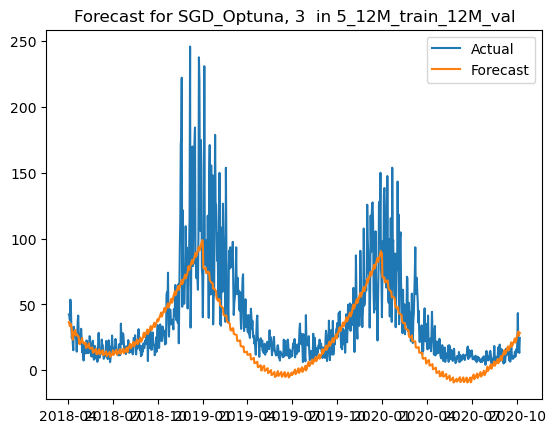

{'Apr_2018': 22.0561749255105, 'May_2018': 31.819813177654748, 'Jun_2018': 31.920157415953295, 'Jul_2018': 37.752406446666406, 'Aug_2018': 23.3084981358883, 'Sep_2018': 32.11915829342846, 'Oct_2018': 24.682856400445175, 'Nov_2018': 34.741302836959356, 'Dec_2018': 43.46351632592344, 'Jan_2019': 61.83644216639127, 'Feb_2019': 87.67231978522815, 'Mar_2019': 115.81269126828182, 'Apr_2019': 165.54477798558045, 'May_2019': 207.20614991657578, 'Jun_2019': 214.85845794496453, 'Jul_2019': 152.0867862809938, 'Aug_2019': 96.65818317502459, 'Sep_2019': 39.568796374062174, 'Oct_2019': 29.379861072760015, 'Nov_2019': 31.160519690937278, 'Dec_2019': 42.26935423246264, 'Jan_2020': 61.24495592586877, 'Feb_2020': 92.27451866363197, 'Mar_2020': 132.88281832671228, 'Apr_2020': 201.40242599630506, 'May_2020': 288.68987360564375, 'Jun_2020': 257.2971229114826, 'Jul_2020': 211.88650448631714, 'Aug_2020': 102.86241472309241, 'Sep_2020': 35.82447324142325, 'Oct_2020': 29.642609495052252}
{'test_30_days': 23.48

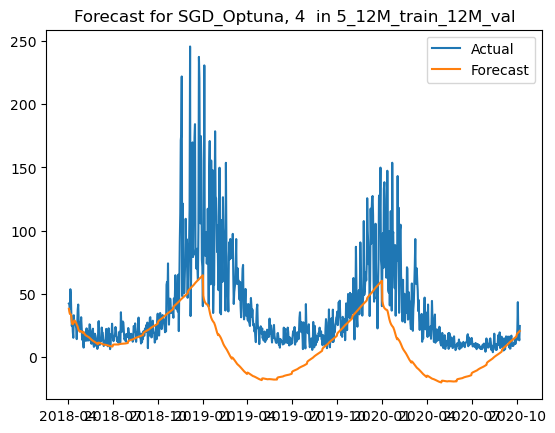

{'Apr_2018': 27.343531849094404, 'May_2018': 30.37437191680984, 'Jun_2018': 26.867998106196545, 'Jul_2018': 20.07490692291645, 'Aug_2018': 31.763794644275613, 'Sep_2018': 37.95692914792227, 'Oct_2018': 23.632373231857486, 'Nov_2018': 41.006569326062284, 'Dec_2018': 54.49310208749186, 'Jan_2019': 59.38664056041668, 'Feb_2019': 67.34188583713045, 'Mar_2019': 74.92333689752442, 'Apr_2019': 65.56332136311276, 'May_2019': 48.48987125839426, 'Jun_2019': 23.404155172185924, 'Jul_2019': 38.47267395259259, 'Aug_2019': 54.616248375784316, 'Sep_2019': 64.81949493511246, 'Oct_2019': 27.753358216128092, 'Nov_2019': 32.57852712502203, 'Dec_2019': 46.499861776683424, 'Jan_2020': 51.94802091660458, 'Feb_2020': 50.56855472460009, 'Mar_2020': 63.31040585010277, 'Apr_2020': 53.79391262571625, 'May_2020': 38.54662799435741, 'Jun_2020': 22.545367532636245, 'Jul_2020': 89.91181423227546, 'Aug_2020': 124.64861201254398, 'Sep_2020': 149.24133770771707, 'Oct_2020': 66.20779092390941}
{'test_30_days': 27.752444

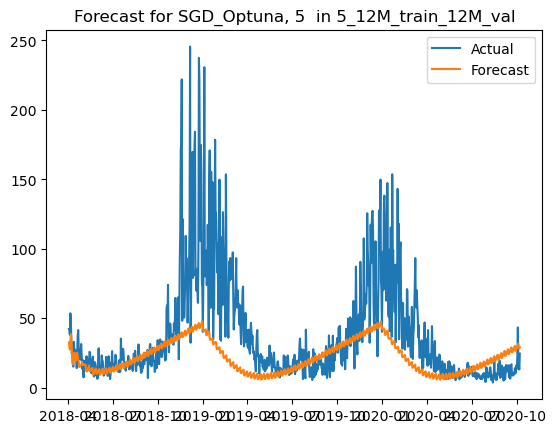

{'Apr_2018': 25.063881146479584, 'May_2018': 33.14873692598979, 'Jun_2018': 28.058852083637724, 'Jul_2018': 25.522293626478614, 'Aug_2018': 25.807487201938645, 'Sep_2018': 34.263827609085226, 'Oct_2018': 23.3832456010601, 'Nov_2018': 36.69370919667742, 'Dec_2018': 48.21553976454552, 'Jan_2019': 50.4602807227278, 'Feb_2019': 52.93460412034722, 'Mar_2019': 56.16143888013653, 'Apr_2019': 38.14633716390794, 'May_2019': 18.304578918325745, 'Jun_2019': 39.32287442905699, 'Jul_2019': 44.44931385499496, 'Aug_2019': 103.50679902786067, 'Sep_2019': 118.10325969118387, 'Oct_2019': 57.53186327249749, 'Nov_2019': 36.90056325751559, 'Dec_2019': 40.2611237942968, 'Jan_2020': 32.38580641267105, 'Feb_2020': 35.26211611966447, 'Mar_2020': 35.79077282229422, 'Apr_2020': 58.78219398848699, 'May_2020': 153.09238238079928, 'Jun_2020': 161.68810170536736, 'Jul_2020': 280.84098504923145, 'Aug_2020': 308.8894427392449, 'Sep_2020': 330.5019984124601, 'Oct_2020': 167.99958059022515}
{'test_30_days': 26.219339965

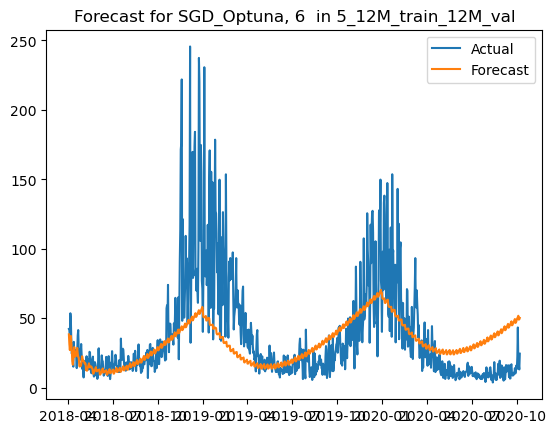

DATASET: 5_16M_train_8M_val
5 16 16M_train_8M_val
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
262  SGD_Optuna     22.708259     23.501780     28.787140      52.818876   
383  SGD_Optuna     23.806682     23.579227     28.306789      52.219880   
311  SGD_Optuna     25.867690     24.762012     27.845350      51.089605   
335  SGD_Optuna     22.716251     23.800410     29.549391      53.571672   
382  SGD_Optuna     22.745561     23.736417     29.569101      53.641774   
268  SGD_Optuna     34.487396     32.534447     29.859978      32.810722   
269  SGD_Optuna     42.160290     39.163246     35.369531      36.355373   
275  SGD_Optuna     35.341548     36.442886     31.761126      37.208420   
222  SGD_Optuna     33.544442     32.745100     32.577918      36.133331   
309  SGD_Optuna     40.661508     38.558885     34.382866      36.213576   

     test_360_days  
262      51.507900  
383      50.946479  
311      50.138013  
335      51.990416  
382     

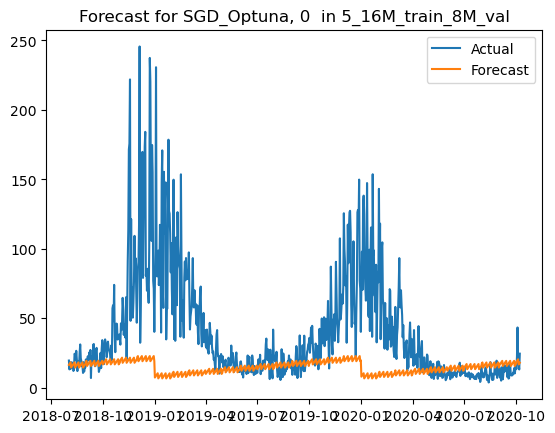

{'Aug_2018': 23.806682286246946, 'Sep_2018': 23.351771083546367, 'Oct_2018': 38.02779927585394, 'Nov_2018': 64.31579164776888, 'Dec_2018': 76.06827616922617, 'Jan_2019': 89.9562734650418, 'Feb_2019': 85.56837185994311, 'Mar_2019': 77.68740289796095, 'Apr_2019': 51.15683003298926, 'May_2019': 21.949881545543647, 'Jun_2019': 26.801499972340377, 'Jul_2019': 37.168948834817066, 'Aug_2019': 37.53488311157555, 'Sep_2019': 38.62703635286016, 'Oct_2019': 38.20937710923909, 'Nov_2019': 56.217357872543325, 'Dec_2019': 68.92200332243344, 'Jan_2020': 87.93063781532626, 'Feb_2020': 76.43939510393488, 'Mar_2020': 66.74688162954845, 'Apr_2020': 35.69215814101071, 'May_2020': 46.90748700562815, 'Jun_2020': 46.24198143985184, 'Jul_2020': 90.88488238259549, 'Aug_2020': 87.26502974933216, 'Sep_2020': 72.6045649048259, 'Oct_2020': 27.109877475769583}
{'test_30_days': 23.806682288245703, 'test_60_days': 23.579226687205164, 'test_90_days': 28.30678913612835, 'test_120_days': 37.23546909860539, 'test_150_day

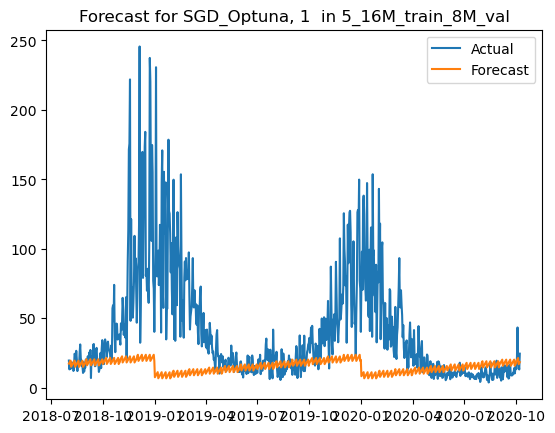

{'Aug_2018': 25.867690009469968, 'Sep_2018': 23.656333538572273, 'Oct_2018': 34.26580464814622, 'Nov_2018': 61.43158604879054, 'Dec_2018': 74.06765419642521, 'Jan_2019': 89.62952711150348, 'Feb_2019': 84.89891931628296, 'Mar_2019': 76.4316590914419, 'Apr_2019': 48.977325827626906, 'May_2019': 19.738548105706382, 'Jun_2019': 30.917085299515, 'Jul_2019': 36.88932802072038, 'Aug_2019': 42.3707989810034, 'Sep_2019': 41.26239313366054, 'Oct_2019': 35.31588452402223, 'Nov_2019': 53.134636411251435, 'Dec_2019': 66.86360992212711, 'Jan_2020': 87.52174023334595, 'Feb_2020': 75.28736094401178, 'Mar_2020': 65.33860762556185, 'Apr_2020': 33.70615088963694, 'May_2020': 53.059215247729284, 'Jun_2020': 54.83870243633425, 'Jul_2020': 105.01712298071264, 'Aug_2020': 100.24699819608828, 'Sep_2020': 86.24809759700828, 'Oct_2020': 30.39589397088286}
{'test_30_days': 25.86769001528745, 'test_60_days': 24.762011777082133, 'test_90_days': 27.845349745654676, 'test_120_days': 36.165126336229086, 'test_150_day

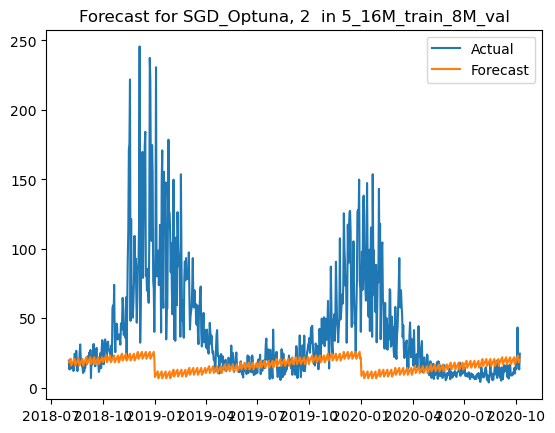

{'Aug_2018': 22.71625066418645, 'Sep_2018': 24.884569477772217, 'Oct_2018': 41.31462489226194, 'Nov_2018': 66.53191108043023, 'Dec_2018': 77.54868197884936, 'Jan_2019': 90.51330742624785, 'Feb_2019': 86.31305650648743, 'Mar_2019': 78.85644734997199, 'Apr_2019': 53.090277170413856, 'May_2019': 24.533294210586526, 'Jun_2019': 23.884727176659695, 'Jul_2019': 37.6816380718937, 'Aug_2019': 34.91656484607225, 'Sep_2019': 37.216381910064754, 'Oct_2019': 40.47882799232128, 'Nov_2019': 58.448761645748185, 'Dec_2019': 70.52224470092192, 'Jan_2020': 88.59016220410709, 'Feb_2020': 77.66161146972568, 'Mar_2020': 68.07650827451683, 'Apr_2020': 38.0163202514762, 'May_2020': 42.60045420879796, 'Jun_2020': 39.672478056504396, 'Jul_2020': 80.65955148868254, 'Aug_2020': 77.95102744591964, 'Sep_2020': 63.01268520447631, 'Oct_2020': 25.541206060666212}
{'test_30_days': 22.716250666397155, 'test_60_days': 23.800410073292586, 'test_90_days': 29.54939144698061, 'test_120_days': 38.72556146013881, 'test_150_da

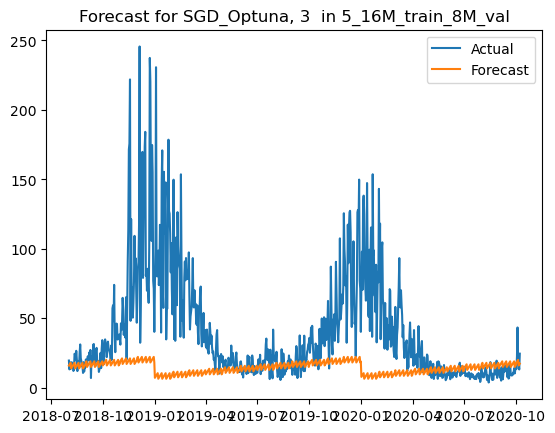

{'Aug_2018': 22.745560924383618, 'Sep_2018': 24.727272814676375, 'Oct_2018': 41.50549707352835, 'Nov_2018': 66.79506741707999, 'Dec_2018': 77.76452270447719, 'Jan_2019': 90.3711054615723, 'Feb_2019': 86.23672089942085, 'Mar_2019': 78.83821328167983, 'Apr_2019': 53.16939415644419, 'May_2019': 24.788095979425663, 'Jun_2019': 23.569083485667278, 'Jul_2019': 37.83035820470248, 'Aug_2019': 34.57501530609973, 'Sep_2019': 36.965838735848045, 'Oct_2019': 40.88920126053464, 'Nov_2019': 58.809500003461046, 'Dec_2019': 70.83223687252078, 'Jan_2020': 88.43400685927627, 'Feb_2020': 77.55903211453928, 'Mar_2020': 68.05668934608791, 'Apr_2020': 38.10330850453855, 'May_2020': 42.26736930108965, 'Jun_2020': 38.92075502971503, 'Jul_2020': 79.26150278081455, 'Aug_2020': 76.55774040667329, 'Sep_2020': 61.522870131136756, 'Oct_2020': 25.43007425920679}
{'test_30_days': 22.745560927645027, 'test_60_days': 23.736416868892302, 'test_90_days': 29.5691005189948, 'test_120_days': 38.80576166113139, 'test_150_day

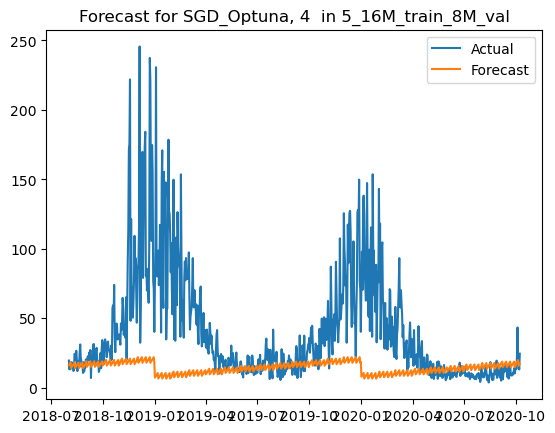

{'Aug_2018': 35.34154818880567, 'Sep_2018': 37.54422299842568, 'Oct_2018': 21.722990584702764, 'Nov_2018': 36.14384628678884, 'Dec_2018': 44.77555198222286, 'Jan_2019': 49.246786736153425, 'Feb_2019': 59.13014283829347, 'Mar_2019': 86.8663241193364, 'Apr_2019': 114.69639022167479, 'May_2019': 128.41880738775168, 'Jun_2019': 117.8840912299734, 'Jul_2019': 85.79681742954612, 'Aug_2019': 42.13015737558611, 'Sep_2019': 34.21018738853269, 'Oct_2019': 27.293431577753825, 'Nov_2019': 27.86742592742611, 'Dec_2019': 41.2869693254392, 'Jan_2020': 33.811673594766084, 'Feb_2020': 31.64882426682664, 'Mar_2020': 55.18044965918336, 'Apr_2020': 64.88006462753131, 'May_2020': 45.56207736319677, 'Jun_2020': 21.973484104449557, 'Jul_2020': 85.19172485912682, 'Aug_2020': 145.22886247493096, 'Sep_2020': 212.46515024068978, 'Oct_2020': 117.00441957850516}
{'test_30_days': 35.34154819186223, 'test_60_days': 36.44288559591891, 'test_90_days': 31.76112620590231, 'test_120_days': 32.8342345298218, 'test_150_day

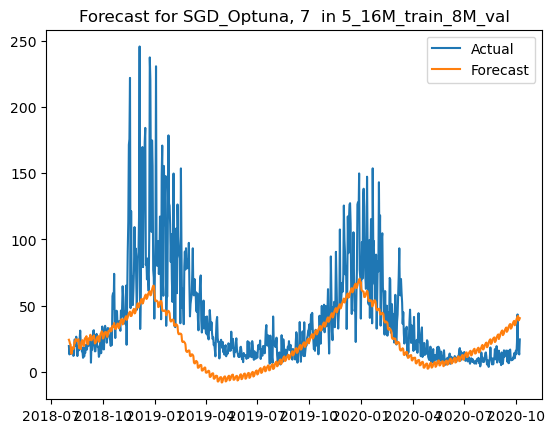

{'Aug_2018': 40.66150779347524, 'Sep_2018': 36.45626304519041, 'Oct_2018': 26.155517504127396, 'Nov_2018': 33.64190660577335, 'Dec_2018': 39.753182165791884, 'Jan_2019': 40.76513522810228, 'Feb_2019': 42.516520020863425, 'Mar_2019': 36.53637243196733, 'Apr_2019': 27.10953357109254, 'May_2019': 24.28261583864217, 'Jun_2019': 21.46208490743874, 'Jul_2019': 37.46432205306569, 'Aug_2019': 109.46009614411926, 'Sep_2019': 159.91566333647452, 'Oct_2019': 89.89379962762662, 'Nov_2019': 47.339486045091746, 'Dec_2019': 39.02349564999054, 'Jan_2020': 42.67447280549786, 'Feb_2020': 39.25523653106268, 'Mar_2020': 57.12824281483386, 'Apr_2020': 55.19284761460678, 'May_2020': 38.11592301112195, 'Jun_2020': 75.38045583638427, 'Jul_2020': 292.06194018851915, 'Aug_2020': 404.9706838173369, 'Sep_2020': 450.7635179101033, 'Oct_2020': 228.58029481737557}
{'test_30_days': 40.66150779084252, 'test_60_days': 38.55888541642437, 'test_90_days': 34.382865718703044, 'test_120_days': 34.231207890005564, 'test_150_

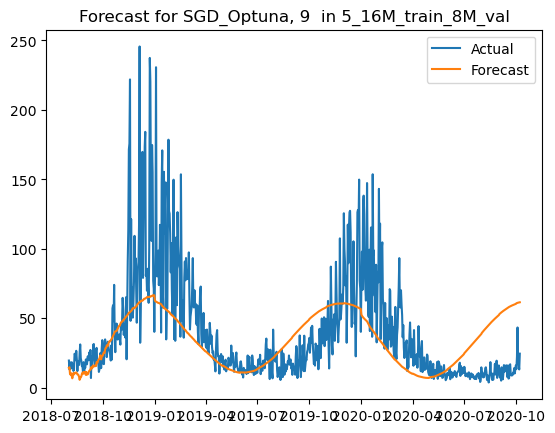

DATASET: 5_20M_train_4M_val
5 20 20M_train_4M_val
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
284  SGD_Optuna     34.653527     35.813423     30.361218      28.257716   
287  SGD_Optuna     33.859708     35.432529     29.851145      56.086262   
260  SGD_Optuna     33.941998     35.448797     29.836310      56.208569   
261  SGD_Optuna     33.843679     35.237526     29.833517      57.001456   
276  SGD_Optuna     34.114469     35.343200     30.175404      44.642268   
85   SGD_Optuna     41.161539     39.863296     32.808368      29.238163   
39   SGD_Optuna     38.807412     38.666305     32.249266      31.164569   
229  SGD_Optuna     35.848698     35.923503     31.428234      31.532761   
44   SGD_Optuna     38.484880     38.487853     32.159299      31.920258   

     test_360_days  
284      62.298787  
287     101.929902  
260     102.285952  
261     106.823286  
276      91.393195  
85       83.839111  
39       57.449231  
229      63.163136  


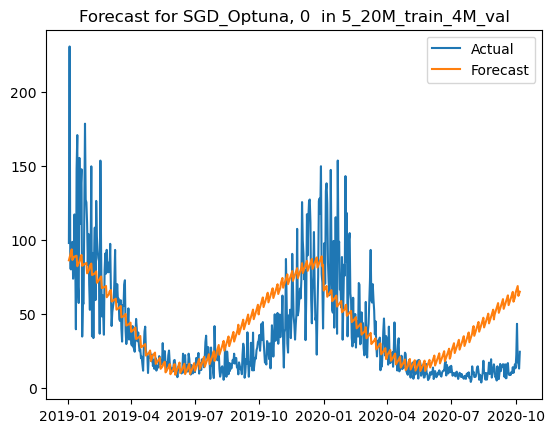

{'Jan_2019': 33.85970841726822, 'Feb_2019': 37.42480757367425, 'Mar_2019': 19.48346763087282, 'Apr_2019': 41.578618069729686, 'May_2019': 67.09773435353769, 'Jun_2019': 136.68218421846709, 'Jul_2019': 130.13478352099307, 'Aug_2019': 243.37351369962272, 'Sep_2019': 250.74627555022633, 'Oct_2019': 133.67766559601623, 'Nov_2019': 71.31748966995593, 'Dec_2019': 44.026869794590645, 'Jan_2020': 36.51860804289395, 'Feb_2020': 34.81975256695758, 'Mar_2020': 34.72952057777158, 'Apr_2020': 54.206313259831006, 'May_2020': 185.5377955658577, 'Jun_2020': 244.76336513550137, 'Jul_2020': 447.75349515831124, 'Aug_2020': 494.49160674089046, 'Sep_2020': 500.72266800147844, 'Oct_2020': 261.71298203121}
{'test_30_days': 33.85970841640777, 'test_60_days': 35.43252856069093, 'test_90_days': 29.8511446781306, 'test_120_days': 32.838211675171486, 'test_150_days': 39.967077787365, 'test_180_days': 56.08626219014396, 'test_240_days': 87.96318766883697, 'test_300_days': 110.46708470821495, 'test_360_days': 101.9

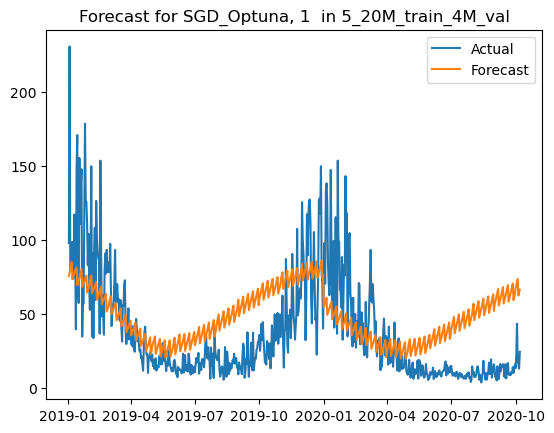

{'Jan_2019': 33.94199756371424, 'Feb_2019': 37.37923977676079, 'Mar_2019': 19.426676171427133, 'Apr_2019': 41.419860958924296, 'May_2019': 67.14987348295304, 'Jun_2019': 137.53983182327926, 'Jul_2019': 130.81805280365964, 'Aug_2019': 244.48109491118353, 'Sep_2019': 251.6667018641203, 'Oct_2019': 134.17101324277104, 'Nov_2019': 71.50339965600077, 'Dec_2019': 44.08835337823624, 'Jan_2020': 36.62806359159788, 'Feb_2020': 34.871281918911805, 'Mar_2020': 34.65266500679271, 'Apr_2020': 54.41267347942045, 'May_2020': 186.56796120661085, 'Jun_2020': 246.3038031569854, 'Jul_2020': 449.9929996360268, 'Aug_2020': 496.6835260375686, 'Sep_2020': 502.51093647587226, 'Oct_2020': 262.61547448081234}
{'test_30_days': 33.941997563684865, 'test_60_days': 35.44879690363707, 'test_90_days': 29.836309529147748, 'test_120_days': 32.790681747474984, 'test_150_days': 39.94231672260629, 'test_180_days': 56.208569237156624, 'test_240_days': 88.27269163181536, 'test_300_days': 110.8667198257978, 'test_360_days': 

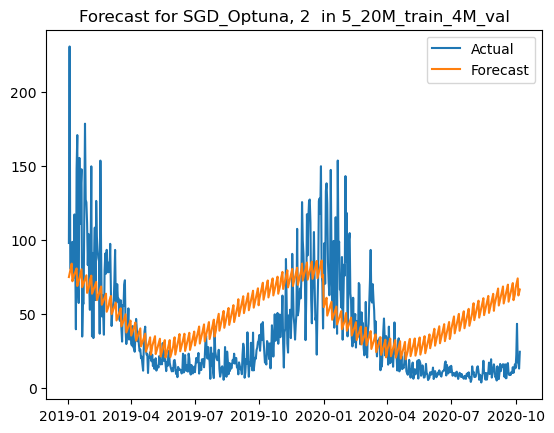

{'Jan_2019': 33.843679130595035, 'Feb_2019': 37.21275490240113, 'Mar_2019': 19.44653612731532, 'Apr_2019': 44.661131623872755, 'May_2019': 69.1930243367284, 'Jun_2019': 137.1778105174326, 'Jul_2019': 132.11079620161905, 'Aug_2019': 252.22994528983432, 'Sep_2019': 266.0073152801563, 'Oct_2019': 147.09818404109348, 'Nov_2019': 81.41865819820127, 'Dec_2019': 47.58197800426404, 'Jan_2020': 33.67453035352973, 'Feb_2020': 34.998028679820244, 'Mar_2020': 34.5403101910519, 'Apr_2020': 50.04709144246564, 'May_2020': 171.2825950615055, 'Jun_2020': 237.5245866976733, 'Jul_2020': 455.3579615083038, 'Aug_2020': 518.4686147960424, 'Sep_2020': 536.7145800088007, 'Oct_2020': 286.34239508303494}
{'test_30_days': 33.843679129920574, 'test_60_days': 35.23752641288873, 'test_90_days': 29.833517358377527, 'test_120_days': 33.5768063362066, 'test_150_days': 40.96618556075081, 'test_180_days': 57.00145638440255, 'test_240_days': 89.95057789735833, 'test_300_days': 114.94136951522648, 'test_360_days': 106.823

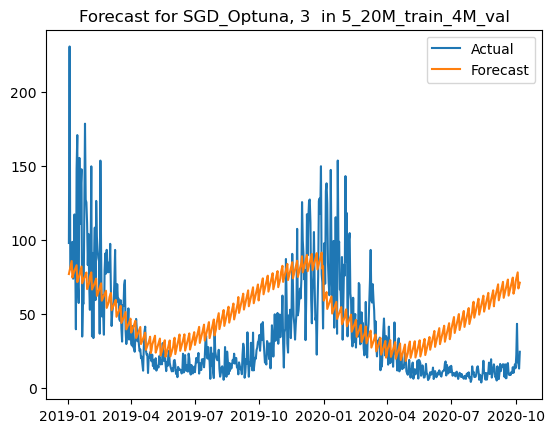

{'Jan_2019': 34.114469075068435, 'Feb_2019': 37.36315373135455, 'Mar_2019': 19.860529143815935, 'Apr_2019': 41.68184126172371, 'May_2019': 46.29625289520438, 'Jun_2019': 88.82300982191421, 'Jul_2019': 92.42867139084825, 'Aug_2019': 208.51849713891818, 'Sep_2019': 242.16667644323473, 'Oct_2019': 142.85563052605426, 'Nov_2019': 83.73480855669862, 'Dec_2019': 49.122449636198276, 'Jan_2020': 31.478025474452842, 'Feb_2020': 35.15277635086207, 'Mar_2020': 34.783818158952876, 'Apr_2020': 38.91540145530874, 'May_2020': 115.56838640237362, 'Jun_2020': 176.5363180778018, 'Jul_2020': 389.9717255698285, 'Aug_2020': 479.5663495334152, 'Sep_2020': 525.441125593819, 'Oct_2020': 287.3488660492867}
{'test_30_days': 34.11446907437777, 'test_60_days': 35.3431997346274, 'test_90_days': 30.17540368379713, 'test_120_days': 32.96419707762625, 'test_150_days': 35.80611905186132, 'test_180_days': 44.64226751312594, 'test_240_days': 70.23423805334441, 'test_300_days': 96.0775351081997, 'test_360_days': 91.39319

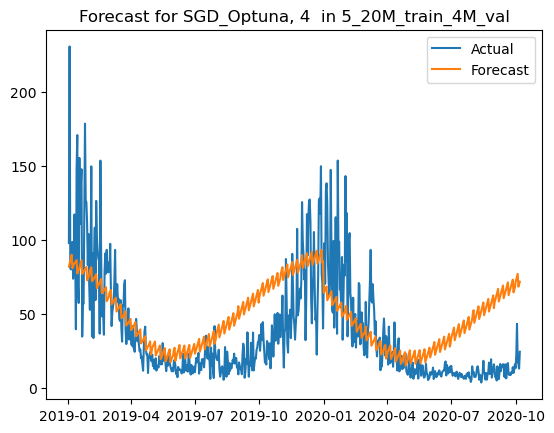

{'Jan_2019': 41.16153947327274, 'Feb_2019': 39.02339287142817, 'Mar_2019': 20.13646695915343, 'Apr_2019': 25.085280876791682, 'May_2019': 24.98208220691942, 'Jun_2019': 26.137822638754205, 'Jul_2019': 54.10738422780097, 'Aug_2019': 182.68715060173017, 'Sep_2019': 245.86921726814666, 'Oct_2019': 164.14822075894807, 'Nov_2019': 111.94120379127747, 'Dec_2019': 67.04948701414924, 'Jan_2020': 35.413853525624475, 'Feb_2020': 49.492378402411575, 'Mar_2020': 34.94718643679136, 'Apr_2020': 31.860346525758015, 'May_2020': 35.96205615669402, 'Jun_2020': 26.879743036455533, 'Jul_2020': 191.1989109026749, 'Aug_2020': 336.3445184899231, 'Sep_2020': 458.5815918677683, 'Oct_2020': 276.2491503844589}
{'test_30_days': 41.16153947266698, 'test_60_days': 39.86329644441468, 'test_90_days': 32.808367786293715, 'test_120_days': 31.12400976914189, 'test_150_days': 29.858230901549444, 'test_180_days': 29.23816285747921, 'test_240_days': 50.549238365811, 'test_300_days': 82.53002175207718, 'test_360_days': 83.8

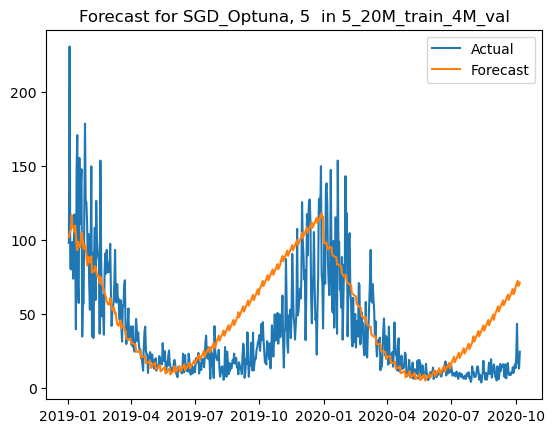

{'Jan_2019': 38.807411507036434, 'Feb_2019': 38.5992574273284, 'Mar_2019': 20.905865714688815, 'Apr_2019': 24.923079165028188, 'May_2019': 24.02388083595681, 'Jun_2019': 40.80354743683906, 'Jul_2019': 42.88959598632616, 'Aug_2019': 110.89037704384556, 'Sep_2019': 144.71138925398154, 'Oct_2019': 89.0931756160661, 'Nov_2019': 62.71879610921929, 'Dec_2019': 49.856230698405525, 'Jan_2020': 29.72187340520358, 'Feb_2020': 33.919117724208434, 'Mar_2020': 38.63530543305596, 'Apr_2020': 30.23405292487936, 'May_2020': 32.367787944928956, 'Jun_2020': 19.129184827410732, 'Jul_2020': 91.57326385683677, 'Aug_2020': 172.35621505581898, 'Sep_2020': 257.2582147265504, 'Oct_2020': 149.07565991994733}
{'test_30_days': 38.80741150568653, 'test_60_days': 38.66630494807113, 'test_90_days': 32.249266167412635, 'test_120_days': 30.35478876682822, 'test_150_days': 29.236773805735787, 'test_180_days': 31.164569411957405, 'test_240_days': 42.07267661069704, 'test_300_days': 57.7966878197176, 'test_360_days': 57.

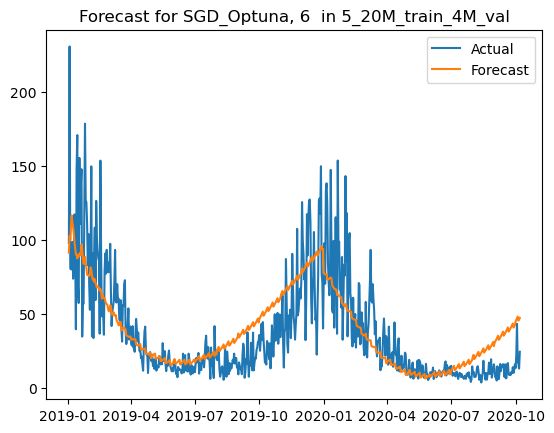

{'Jan_2019': 35.848698449584354, 'Feb_2019': 37.015181602137645, 'Mar_2019': 21.803296699827737, 'Apr_2019': 42.28574892736914, 'May_2019': 25.000759238876537, 'Jun_2019': 28.150425029885874, 'Jul_2019': 40.740110152936246, 'Aug_2019': 120.0558106107547, 'Sep_2019': 174.00489474289134, 'Oct_2019': 112.77863954495749, 'Nov_2019': 70.54341047066313, 'Dec_2019': 45.74810138601624, 'Jan_2020': 30.338165747027436, 'Feb_2020': 36.72796486974591, 'Mar_2020': 34.326614505781464, 'Apr_2020': 40.05606553558422, 'May_2020': 89.99200706003322, 'Jun_2020': 119.46153345344509, 'Jul_2020': 295.09862386120113, 'Aug_2020': 384.6449610871454, 'Sep_2020': 445.1945434219314, 'Oct_2020': 244.4076370320686}
{'test_30_days': 35.84869844942808, 'test_60_days': 35.92350294445634, 'test_90_days': 31.42823438428401, 'test_120_days': 33.876586429950684, 'test_150_days': 32.20922826694827, 'test_180_days': 31.532761060624782, 'test_240_days': 42.99927818275674, 'test_300_days': 63.974338485902535, 'test_360_days':

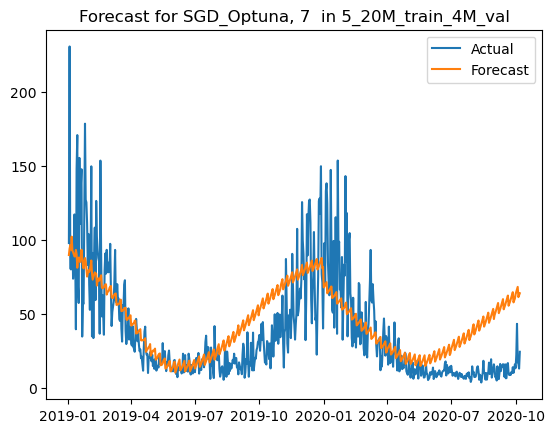

{'Jan_2019': 38.484880532781204, 'Feb_2019': 38.56719777756829, 'Mar_2019': 21.093014924731353, 'Apr_2019': 23.65884929199766, 'May_2019': 26.396742475883446, 'Jun_2019': 44.30901926070775, 'Jul_2019': 63.600181380109035, 'Aug_2019': 43.55973284644756, 'Sep_2019': 34.89485013018002, 'Oct_2019': 32.20875230811357, 'Nov_2019': 37.01488843871844, 'Dec_2019': 46.488243472576464, 'Jan_2020': 61.64371509802745, 'Feb_2020': 74.0106137760694, 'Mar_2020': 107.37751727282124, 'Apr_2020': 163.64205065218513, 'May_2020': 247.42183839346575, 'Jun_2020': 245.8944410590762, 'Jul_2020': 236.6057832282167, 'Aug_2020': 156.3327775072962, 'Sep_2020': 68.0106260118608, 'Oct_2020': 46.719178116962254}
{'test_30_days': 38.48488049380157, 'test_60_days': 38.487852811214594, 'test_90_days': 32.159299226526606, 'test_120_days': 30.149514017345595, 'test_150_days': 29.442506085598502, 'test_180_days': 31.92025828166137, 'test_240_days': 37.57839173898763, 'test_300_days': 36.66330843312998, 'test_360_days': 37.

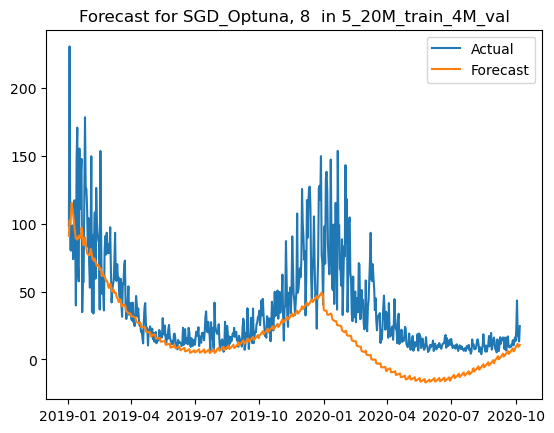

DATASET: 5_24M_train
5 24 24M_train
         Model  test_30_days  test_60_days  test_90_days  test_180_days  \
1   SGD_Optuna     26.497702     27.658544     28.611414      35.909702   
17  SGD_Optuna     26.497702     27.658544     28.611414      35.909702   
25  SGD_Optuna     26.497702     27.658544     28.611414      35.909702   
0   SGD_Optuna     26.559943     28.254169     29.884294      36.029296   
16  SGD_Optuna     26.559943     28.254169     29.884294      36.029296   

    test_360_days  
1       45.045734  
17      45.045734  
25      45.045734  
0       45.448533  
16      45.448533  
{'Apr_2019': 26.714282579972267, 'May_2019': 28.541884415214895, 'Jun_2019': 30.517155619117958, 'Jul_2019': 43.75395604914121, 'Aug_2019': 37.92070941669458, 'Sep_2019': 47.017397125247044, 'Oct_2019': 30.06865433573438, 'Nov_2019': 46.361978322019574, 'Dec_2019': 62.69023704711996, 'Jan_2020': 70.86517140631804, 'Feb_2020': 60.30753441015296, 'Mar_2020': 56.81198321651242, 'Apr_2020': 31.

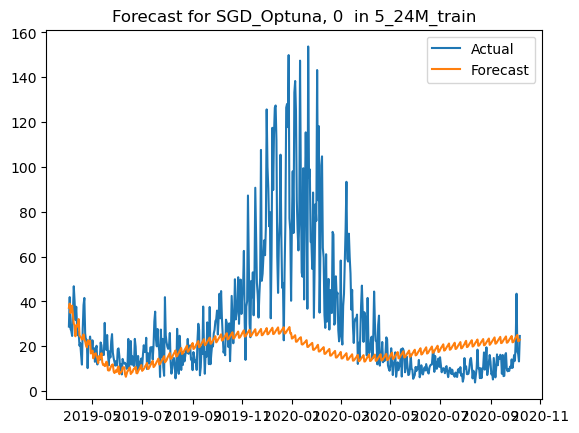

{'Apr_2019': 26.714282579972267, 'May_2019': 28.541884415214895, 'Jun_2019': 30.517155619117958, 'Jul_2019': 43.75395604914121, 'Aug_2019': 37.92070941669458, 'Sep_2019': 47.017397125247044, 'Oct_2019': 30.06865433573438, 'Nov_2019': 46.361978322019574, 'Dec_2019': 62.69023704711996, 'Jan_2020': 70.86517140631804, 'Feb_2020': 60.30753441015296, 'Mar_2020': 56.81198321651242, 'Apr_2020': 31.889929168391294, 'May_2020': 65.34171018531696, 'Jun_2020': 74.06791001773513, 'Jul_2020': 140.47194129499104, 'Aug_2020': 133.85968507970588, 'Sep_2020': 117.17070372516316, 'Oct_2020': 39.43682759820905}
{'test_30_days': 26.497702328514738, 'test_60_days': 27.658543529700268, 'test_90_days': 28.61141422635835, 'test_120_days': 32.45627253909073, 'test_150_days': 33.48713145610861, 'test_180_days': 35.90970157529868, 'test_240_days': 36.08670005696612, 'test_300_days': 42.126275767973695, 'test_360_days': 45.04573420006876, 'test_480_days': 51.65404495229171, 'test_600_days': 61.24422812301822, 'tes

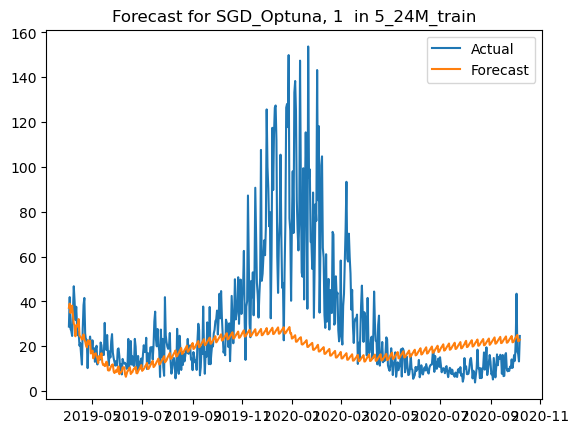

{'Apr_2019': 26.714282579972267, 'May_2019': 28.541884415214895, 'Jun_2019': 30.517155619117958, 'Jul_2019': 43.75395604914121, 'Aug_2019': 37.92070941669458, 'Sep_2019': 47.017397125247044, 'Oct_2019': 30.06865433573438, 'Nov_2019': 46.361978322019574, 'Dec_2019': 62.69023704711996, 'Jan_2020': 70.86517140631804, 'Feb_2020': 60.30753441015296, 'Mar_2020': 56.81198321651242, 'Apr_2020': 31.889929168391294, 'May_2020': 65.34171018531696, 'Jun_2020': 74.06791001773513, 'Jul_2020': 140.47194129499104, 'Aug_2020': 133.85968507970588, 'Sep_2020': 117.17070372516316, 'Oct_2020': 39.43682759820905}
{'test_30_days': 26.497702328514738, 'test_60_days': 27.658543529700268, 'test_90_days': 28.61141422635835, 'test_120_days': 32.45627253909073, 'test_150_days': 33.48713145610861, 'test_180_days': 35.90970157529868, 'test_240_days': 36.08670005696612, 'test_300_days': 42.126275767973695, 'test_360_days': 45.04573420006876, 'test_480_days': 51.65404495229171, 'test_600_days': 61.24422812301822, 'tes

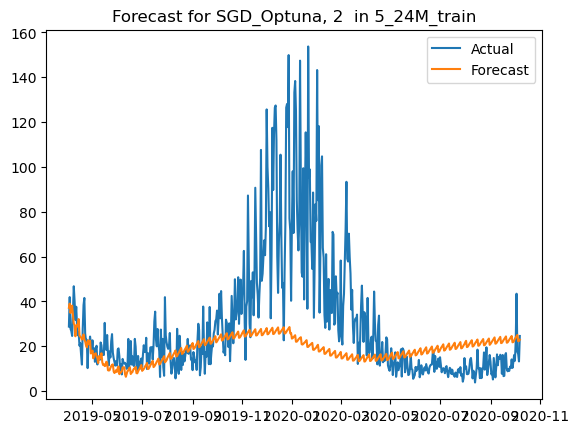

{'Apr_2019': 26.75128332485402, 'May_2019': 29.660094480478655, 'Jun_2019': 33.14454344354416, 'Jul_2019': 45.188938047658496, 'Aug_2019': 35.793388918246556, 'Sep_2019': 44.762312566683676, 'Oct_2019': 30.720558401824793, 'Nov_2019': 47.46799067593007, 'Dec_2019': 63.56329398807554, 'Jan_2020': 71.47949213564277, 'Feb_2020': 60.7667372602924, 'Mar_2020': 57.057638228819464, 'Apr_2020': 31.870112051981515, 'May_2020': 64.09742186394132, 'Jun_2020': 71.55833954209541, 'Jul_2020': 135.94079731570446, 'Aug_2020': 128.8833601288729, 'Sep_2020': 112.11668348996176, 'Oct_2020': 37.417298713433546}
{'test_30_days': 26.55994262923288, 'test_60_days': 28.25416908347077, 'test_90_days': 29.884293870449056, 'test_120_days': 33.76076184822259, 'test_150_days': 34.16124238121488, 'test_180_days': 36.02929602735977, 'test_240_days': 36.40206738733325, 'test_300_days': 42.53340429722864, 'test_360_days': 45.44853293476438, 'test_480_days': 51.50847932280976, 'test_600_days': 60.47113086059092, 'test_

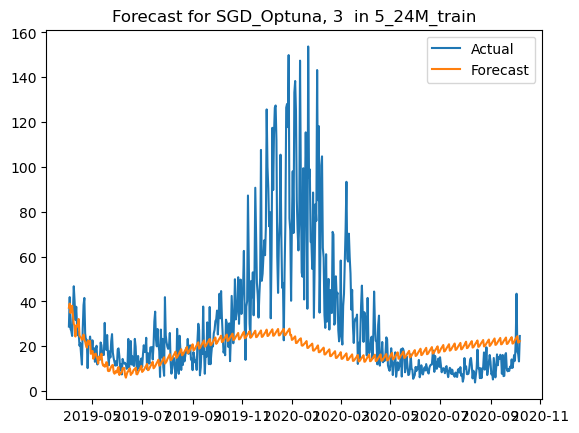

{'Apr_2019': 26.75128332485402, 'May_2019': 29.660094480478655, 'Jun_2019': 33.14454344354416, 'Jul_2019': 45.188938047658496, 'Aug_2019': 35.793388918246556, 'Sep_2019': 44.762312566683676, 'Oct_2019': 30.720558401824793, 'Nov_2019': 47.46799067593007, 'Dec_2019': 63.56329398807554, 'Jan_2020': 71.47949213564277, 'Feb_2020': 60.7667372602924, 'Mar_2020': 57.057638228819464, 'Apr_2020': 31.870112051981515, 'May_2020': 64.09742186394132, 'Jun_2020': 71.55833954209541, 'Jul_2020': 135.94079731570446, 'Aug_2020': 128.8833601288729, 'Sep_2020': 112.11668348996176, 'Oct_2020': 37.417298713433546}
{'test_30_days': 26.55994262923288, 'test_60_days': 28.25416908347077, 'test_90_days': 29.884293870449056, 'test_120_days': 33.76076184822259, 'test_150_days': 34.16124238121488, 'test_180_days': 36.02929602735977, 'test_240_days': 36.40206738733325, 'test_300_days': 42.53340429722864, 'test_360_days': 45.44853293476438, 'test_480_days': 51.50847932280976, 'test_600_days': 60.47113086059092, 'test_

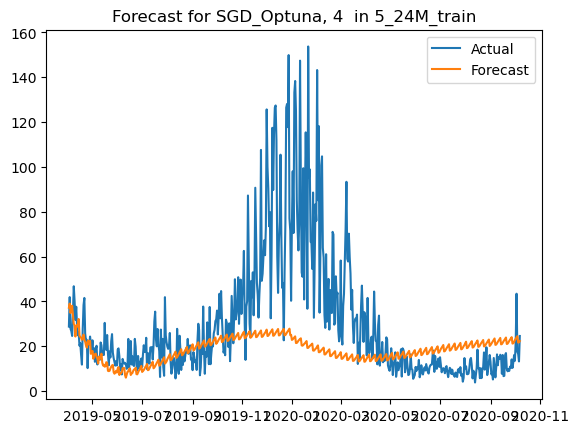

DATASET: 5_24M_train_24M_val
5 24 24M_train_24M_val
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
420  SGD_Optuna     26.025918     23.376717     24.696885      30.877116   
428  SGD_Optuna     26.308279     24.851283     23.771571      32.683455   
319  SGD_Optuna     25.083969     23.839794     23.476852      74.258725   
32   SGD_Optuna     26.985266     26.256587     25.994307      35.811214   
18   SGD_Optuna     26.431184     25.151215     26.951875      41.042954   
21   SGD_Optuna     37.666420     36.483956     35.282528      36.086409   
40   SGD_Optuna     26.003545     27.334682     26.617986      36.399293   
262  SGD_Optuna     49.184090     35.160671     32.040074      34.380393   

     test_360_days  
420      33.970283  
428      37.742361  
319     121.533784  
32       45.534625  
18       48.431430  
21       46.188309  
40       45.144399  
262      50.427412  
{'Apr_2019': 26.059534132339223, 'May_2019': 20.866985099788636, 'Jun_2019

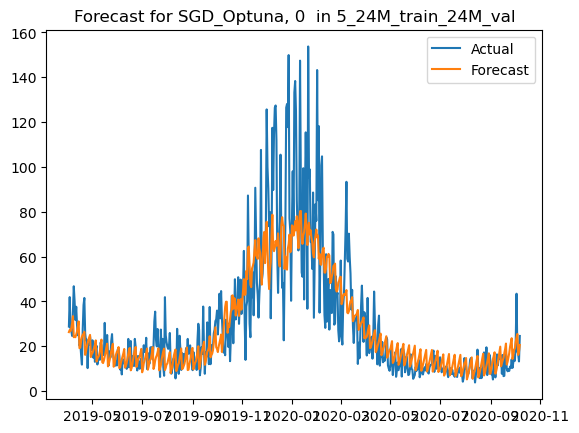

{'Apr_2019': 26.23948870351861, 'May_2019': 23.552638684985116, 'Jun_2019': 21.612148180976792, 'Jul_2019': 46.50556669705024, 'Aug_2019': 46.1364241302154, 'Sep_2019': 29.971167575612924, 'Oct_2019': 48.39732434843699, 'Nov_2019': 51.921906603911935, 'Dec_2019': 45.310424095008045, 'Jan_2020': 27.58039761250255, 'Feb_2020': 47.5692129669849, 'Mar_2020': 36.30322931257749, 'Apr_2020': 33.09733582325396, 'May_2020': 44.45299626726426, 'Jun_2020': 24.6609689563419, 'Jul_2020': 30.582317285195828, 'Aug_2020': 33.7151925960313, 'Sep_2020': 71.22409953149155, 'Oct_2020': 59.24712488259265}
{'test_30_days': 26.308278708475697, 'test_60_days': 24.851282859243295, 'test_90_days': 23.771571300281384, 'test_120_days': 29.22033880416752, 'test_150_days': 33.0715814520718, 'test_180_days': 32.68345479698856, 'test_240_days': 37.19078582005111, 'test_300_days': 36.90176592745514, 'test_360_days': 37.7423610969922, 'test_480_days': 36.68989992045271, 'test_600_days': 38.53773488924904, 'test_720_day

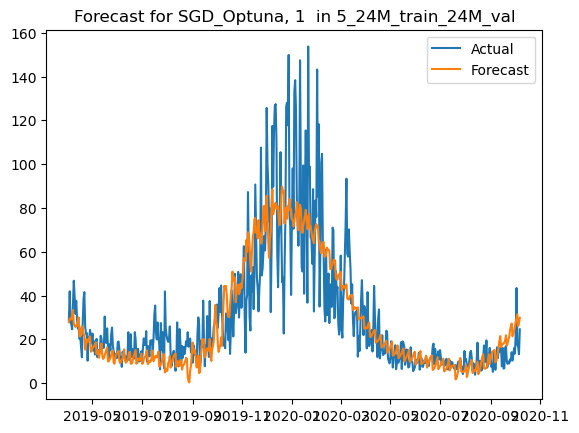

{'Apr_2019': 24.47439863604065, 'May_2019': 23.24613082175259, 'Jun_2019': 22.750967911514664, 'Jul_2019': 72.79473478030461, 'Aug_2019': 125.35533109313941, 'Sep_2019': 178.72210069339735, 'Oct_2019': 145.94331149001133, 'Nov_2019': 110.48031224065969, 'Dec_2019': 98.81786579420987, 'Jan_2020': 125.31398454657024, 'Feb_2020': 220.07408191985732, 'Mar_2020': 349.78431127702436, 'Apr_2020': 701.8131304864792, 'May_2020': 1317.9885729790665, 'Jun_2020': 1464.463673419808, 'Jul_2020': 2057.254294775148, 'Aug_2020': 2083.264954904103, 'Sep_2020': 2018.627815393533, 'Oct_2020': 1210.1260574797354}
{'test_30_days': 25.083968672043504, 'test_60_days': 23.83979358656593, 'test_90_days': 23.476851695938564, 'test_120_days': 35.512744757522015, 'test_150_days': 52.991962383180656, 'test_180_days': 74.25872469557177, 'test_240_days': 88.06257105773823, 'test_300_days': 92.11284094713024, 'test_360_days': 121.53378400852448, 'test_480_days': 412.7466575526414, 'test_600_days': 628.5787326383619, '

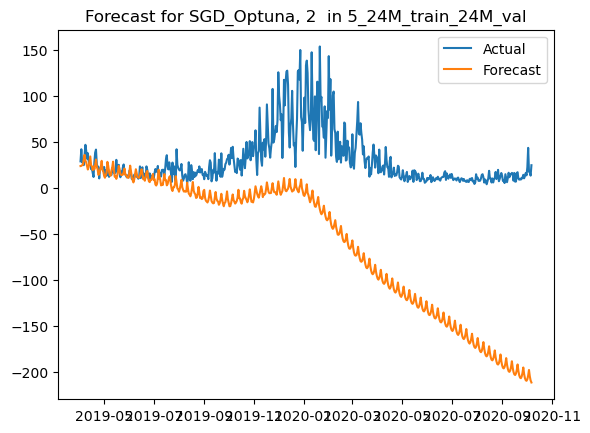

{'Apr_2019': 27.305650964883103, 'May_2019': 25.27520434385277, 'Jun_2019': 25.469747075400946, 'Jul_2019': 40.38936390265132, 'Aug_2019': 52.24564675448068, 'Sep_2019': 43.19280135364464, 'Oct_2019': 36.711432640980796, 'Nov_2019': 58.93344020760617, 'Dec_2019': 74.31119145912629, 'Jan_2020': 72.65427857668368, 'Feb_2020': 47.11938205929737, 'Mar_2020': 39.77043161129049, 'Apr_2020': 47.57908247467405, 'May_2020': 130.90456345718457, 'Jun_2020': 110.08381436109073, 'Jul_2020': 148.93634380503732, 'Aug_2020': 116.62089995761316, 'Sep_2020': 81.24936195576275, 'Oct_2020': 26.427664875474637}
{'test_30_days': 26.98526568133048, 'test_60_days': 26.256586875697018, 'test_90_days': 25.99430694126112, 'test_120_days': 29.74538235537268, 'test_150_days': 33.95680758323488, 'test_180_days': 35.81121381810392, 'test_240_days': 38.32911163149407, 'test_300_days': 45.4532127752629, 'test_360_days': 45.534624506588685, 'test_480_days': 59.89206738601904, 'test_600_days': 65.24498573671636, 'test_7

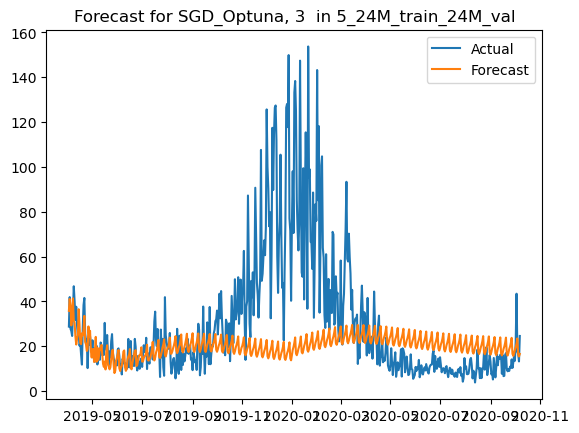

{'Apr_2019': 26.713229666045024, 'May_2019': 23.689975683991683, 'Jun_2019': 30.553195134175276, 'Jul_2019': 42.22637925876989, 'Aug_2019': 70.89052441148272, 'Sep_2019': 50.41393502358699, 'Oct_2019': 38.05086091935824, 'Nov_2019': 63.61890070228585, 'Dec_2019': 80.16325011962222, 'Jan_2020': 69.89909364656374, 'Feb_2020': 40.332143070681916, 'Mar_2020': 38.800831512645715, 'Apr_2020': 89.60373121673972, 'May_2020': 191.6786335895756, 'Jun_2020': 143.6348232031498, 'Jul_2020': 167.43542730496924, 'Aug_2020': 123.18288324812458, 'Sep_2020': 80.87850165252398, 'Oct_2020': 26.19212810610227}
{'test_30_days': 26.43118352809851, 'test_60_days': 25.15121511003621, 'test_90_days': 26.9518751157796, 'test_120_days': 31.078004530470587, 'test_150_days': 38.51874299736884, 'test_180_days': 41.04295390485306, 'test_240_days': 42.93602187715307, 'test_300_days': 49.64606749654968, 'test_360_days': 48.43142992969508, 'test_480_days': 71.55050309137347, 'test_600_days': 75.8834359666666, 'test_720_

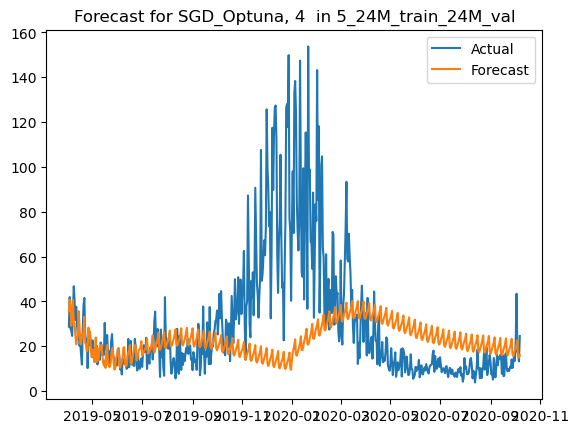

{'Apr_2019': 38.42565811800297, 'May_2019': 34.66752475372755, 'Jun_2019': 32.87967133318263, 'Jul_2019': 36.71747012884064, 'Aug_2019': 34.725870542795604, 'Sep_2019': 39.32901029857083, 'Oct_2019': 33.58502360735494, 'Nov_2019': 49.04010894383089, 'Dec_2019': 62.09935146679698, 'Jan_2020': 70.5880413449878, 'Feb_2020': 62.763190016427686, 'Mar_2020': 62.426710228747, 'Apr_2020': 40.09953799422599, 'May_2020': 34.0601080992535, 'Jun_2020': 26.91018420980173, 'Jul_2020': 76.71521422369929, 'Aug_2020': 86.05292759711344, 'Sep_2020': 87.57786648174117, 'Oct_2020': 33.36405024077947}
{'test_30_days': 37.666419773236754, 'test_60_days': 36.48395587433594, 'test_90_days': 35.282527692187266, 'test_120_days': 35.67798627944519, 'test_150_days': 35.6190697368305, 'test_180_days': 36.08640949384052, 'test_240_days': 37.07681661246691, 'test_300_days': 42.84304182731855, 'test_360_days': 46.18830877007276, 'test_480_days': 45.06320402439016, 'test_600_days': 50.31333662063972, 'test_720_days': 

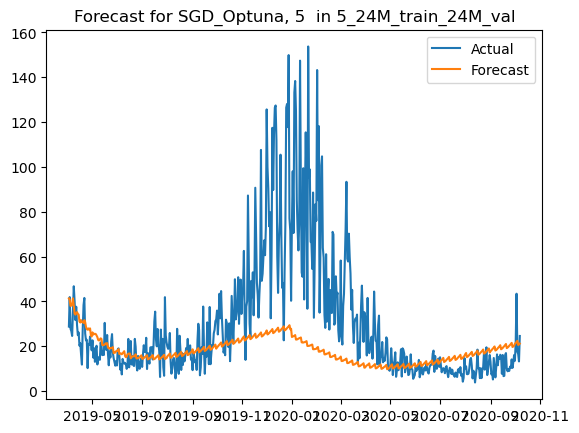

{'Apr_2019': 26.096937999971054, 'May_2019': 28.492571976387232, 'Jun_2019': 25.184592691534775, 'Jul_2019': 41.13798233581949, 'Aug_2019': 49.53733515192443, 'Sep_2019': 46.54277917816873, 'Oct_2019': 32.03800793444724, 'Nov_2019': 52.81467616630903, 'Dec_2019': 69.30828723553299, 'Jan_2020': 71.63086455652491, 'Feb_2020': 51.1945911807315, 'Mar_2020': 45.61109070203654, 'Apr_2020': 40.160519932681304, 'May_2020': 111.90858690218293, 'Jun_2020': 103.98814217718856, 'Jul_2020': 155.1248466479104, 'Aug_2020': 130.7728193838433, 'Sep_2020': 100.49812679457798, 'Oct_2020': 31.611063482356467}
{'test_30_days': 26.003544666508287, 'test_60_days': 27.33468222040212, 'test_90_days': 26.61798571286769, 'test_120_days': 30.36275223205373, 'test_150_days': 33.91817070146057, 'test_180_days': 36.39929324862947, 'test_240_days': 37.42780201952961, 'test_300_days': 44.03765570047504, 'test_360_days': 45.14439870060577, 'test_480_days': 57.80881854981512, 'test_600_days': 65.4789749082167, 'test_720

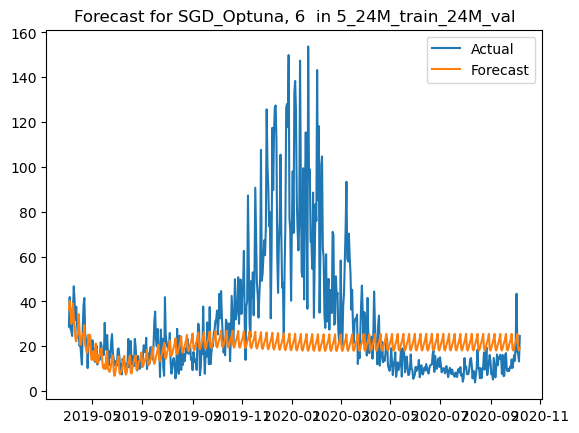

{'Apr_2019': 49.42200002413993, 'May_2019': 21.819427132138053, 'Jun_2019': 25.79888045527036, 'Jul_2019': 36.98996842218873, 'Aug_2019': 35.79573187166499, 'Sep_2019': 37.933975750967456, 'Oct_2019': 39.35808455406268, 'Nov_2019': 57.503567034454385, 'Dec_2019': 69.65996101290067, 'Jan_2020': 88.59674110736125, 'Feb_2020': 77.71330464853892, 'Mar_2020': 67.86565625382273, 'Apr_2020': 37.7321814835317, 'May_2020': 42.8177545775065, 'Jun_2020': 40.82767436795116, 'Jul_2020': 83.42196146547664, 'Aug_2020': 80.87348014705285, 'Sep_2020': 66.68170348413473, 'Oct_2020': 26.041517649414235}
{'test_30_days': 49.18408968578933, 'test_60_days': 35.16067069249203, 'test_90_days': 32.0400739438523, 'test_120_days': 33.31487360947503, 'test_150_days': 33.98368766794053, 'test_180_days': 34.380392859187126, 'test_240_days': 37.56083443168052, 'test_300_days': 45.6476135353366, 'test_360_days': 50.427411929685874, 'test_480_days': 50.01886580706494, 'test_600_days': 53.05714539897386, 'test_720_days

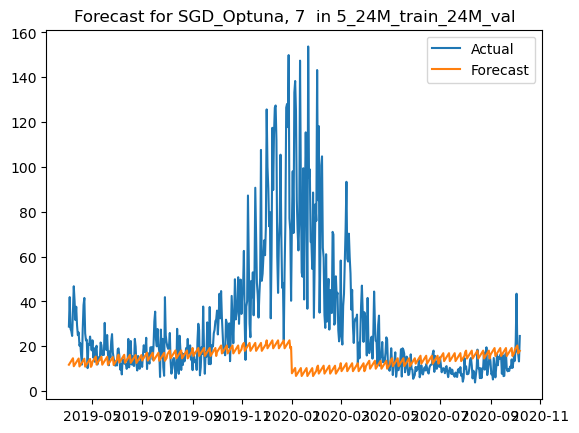

DATASET: 6_12M_train_12M_val
6 12 12M_train_12M_val
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
85   SGD_Optuna     25.584535     29.121740     27.312389      31.937391   
133  SGD_Optuna     25.583133     31.534035     29.718746      30.597056   
425  SGD_Optuna     26.113958     28.152616     27.702753     133.472499   
417  SGD_Optuna     24.192558     27.109438     28.240960     139.469722   
35   SGD_Optuna     33.400529     34.969591     32.425960      40.931074   
0    SGD_Optuna     37.915538     39.841232     36.453596      34.744673   
8    SGD_Optuna     38.656156     41.041493     37.349105      35.436917   

     test_360_days  
85       46.519281  
133      41.422583  
425     109.498680  
417     111.623375  
35       43.044354  
0        49.641317  
8        50.038704  
{'Apr_2018': 25.490475817921777, 'May_2018': 32.51872937160397, 'Jun_2018': 23.69368552027184, 'Jul_2018': 36.75443345515361, 'Aug_2018': 29.75452155028079, 'Sep_2018': 42

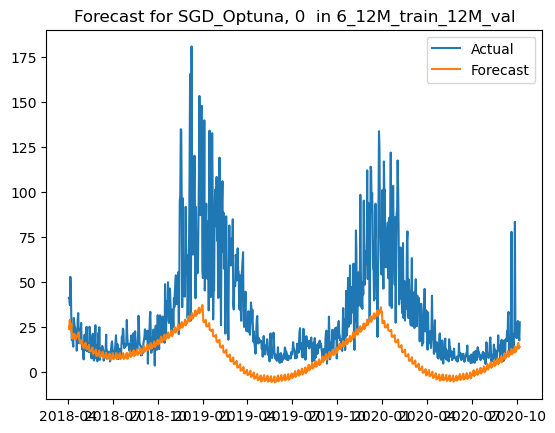

{'Apr_2018': 25.19227681183644, 'May_2018': 37.46664666378777, 'Jun_2018': 26.088167809305162, 'Jul_2018': 24.985027367142223, 'Aug_2018': 24.960407029334313, 'Sep_2018': 44.768131554366754, 'Oct_2018': 26.457001439848142, 'Nov_2018': 39.09084415450101, 'Dec_2018': 50.713110108402326, 'Jan_2019': 55.86429991278023, 'Feb_2019': 67.31250014979962, 'Mar_2019': 79.9297557783907, 'Apr_2019': 83.37739953345536, 'May_2019': 84.29923016398102, 'Jun_2019': 64.85329116697064, 'Jul_2019': 53.21180969458814, 'Aug_2019': 32.37110054278687, 'Sep_2019': 43.54878296731541, 'Oct_2019': 28.572813247183422, 'Nov_2019': 39.459469577477066, 'Dec_2019': 45.297450225368905, 'Jan_2020': 56.3673943103931, 'Feb_2020': 61.14537093176483, 'Mar_2020': 72.41317764495534, 'Apr_2020': 77.11558949978942, 'May_2020': 75.60109569719728, 'Jun_2020': 62.784858800671415, 'Jul_2020': 31.848323845460897, 'Aug_2020': 27.058398430064436, 'Sep_2020': 37.97230640559519, 'Oct_2020': 13.701794799077954}
{'test_30_days': 25.5831330

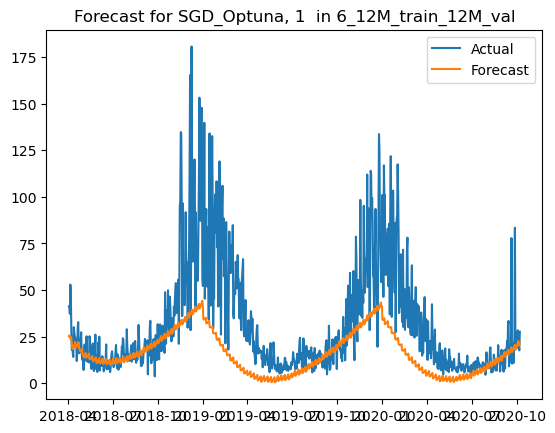

{'Apr_2018': 25.928753718810803, 'May_2018': 30.233003916308025, 'Jun_2018': 26.80302753336456, 'Jul_2018': 90.71969036469952, 'Aug_2018': 256.2597170236725, 'Sep_2018': 376.9596112188983, 'Oct_2018': 234.36729074978427, 'Nov_2018': 82.63199115061416, 'Dec_2018': 38.8756087523807, 'Jan_2019': 37.581513733242936, 'Feb_2019': 50.5256156719066, 'Mar_2019': 45.93696788500956, 'Apr_2019': 37.57216331807838, 'May_2019': 209.43692404639327, 'Jun_2019': 500.02801892903676, 'Jul_2019': 422.99756250107396, 'Aug_2019': 488.036666490593, 'Sep_2019': 478.7020884215303, 'Oct_2019': 183.30214360497686, 'Nov_2019': 48.93537999122265, 'Dec_2019': 42.54628521572487, 'Jan_2020': 51.823112394306605, 'Feb_2020': 32.519285423438625, 'Mar_2020': 34.6450593593446, 'Apr_2020': 233.32167909466847, 'May_2020': 534.5871237692728, 'Jun_2020': 677.447365767934, 'Jul_2020': 677.3838847557358, 'Aug_2020': 512.4085857521113, 'Sep_2020': 273.65121386483776, 'Oct_2020': 127.9783236441711}
{'test_30_days': 26.11395783825

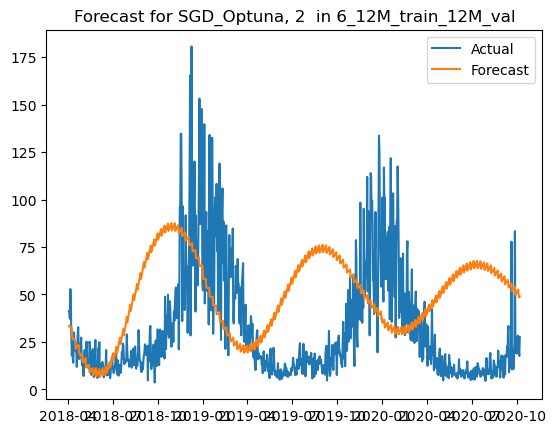

{'Apr_2018': 24.217695913930143, 'May_2018': 29.81461591120469, 'Jun_2018': 30.504005532363742, 'Jul_2018': 107.86544315069916, 'Aug_2018': 268.99742956933375, 'Sep_2018': 380.47210682788796, 'Oct_2018': 230.85412624048777, 'Nov_2018': 78.4641291096691, 'Dec_2018': 38.46858056712446, 'Jan_2019': 38.58525489758426, 'Feb_2019': 50.75089899838573, 'Mar_2019': 41.972978173332926, 'Apr_2019': 47.43963882646153, 'May_2019': 243.25782675490566, 'Jun_2019': 533.242973530513, 'Jul_2019': 426.84933954120095, 'Aug_2019': 471.87620510928457, 'Sep_2019': 449.1613712031073, 'Oct_2019': 165.24402892534445, 'Nov_2019': 44.984662025327204, 'Dec_2019': 43.28469812675993, 'Jan_2020': 49.19152099883822, 'Feb_2020': 29.578060787843697, 'Mar_2020': 44.592404772432886, 'Apr_2020': 255.3760028122694, 'May_2020': 545.3498546411272, 'Jun_2020': 657.76201562625, 'Jul_2020': 635.5528803020427, 'Aug_2020': 471.910786136981, 'Sep_2020': 252.04670437018714, 'Oct_2020': 118.25078802504747}
{'test_30_days': 24.1925579

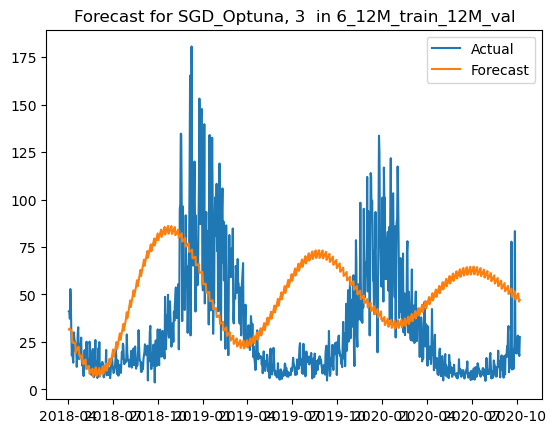

{'Apr_2018': 33.759752480722646, 'May_2018': 36.101374628969, 'Jun_2018': 27.338700309988557, 'Jul_2018': 22.371532076507165, 'Aug_2018': 47.96530236522975, 'Sep_2018': 78.29826439319471, 'Oct_2018': 38.08809969300556, 'Nov_2018': 32.44653804721407, 'Dec_2018': 48.62344028919027, 'Jan_2019': 47.30146853047383, 'Feb_2019': 53.74373976568555, 'Mar_2019': 49.74702895688219, 'Apr_2019': 24.78092336368626, 'May_2019': 70.61566990442869, 'Jun_2019': 171.17753288482044, 'Jul_2019': 119.12429053124838, 'Aug_2019': 156.0424884736631, 'Sep_2019': 185.1197180888984, 'Oct_2019': 77.02237412202622, 'Nov_2019': 35.45394688553159, 'Dec_2019': 39.29508181441748, 'Jan_2020': 40.314346788792314, 'Feb_2020': 28.007823694374416, 'Mar_2020': 28.105475128264494, 'Apr_2020': 69.46662026851797, 'May_2020': 169.8818775758218, 'Jun_2020': 231.91092275164723, 'Jul_2020': 274.90860959981524, 'Aug_2020': 256.6047175891719, 'Sep_2020': 174.24073560283858, 'Oct_2020': 95.1838641549208}
{'test_30_days': 33.4005285550

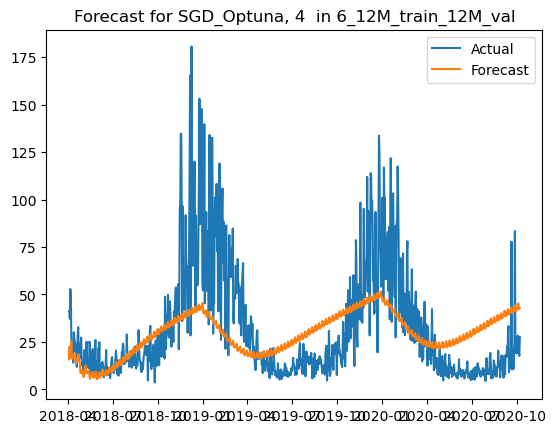

{'Apr_2018': 38.4565644092251, 'May_2018': 41.136565861413324, 'Jun_2018': 29.67832471993476, 'Jul_2018': 22.894740874505665, 'Aug_2018': 31.37717259294422, 'Sep_2018': 44.75718715014299, 'Oct_2018': 31.887277796054107, 'Nov_2018': 61.75691571375687, 'Dec_2018': 76.83493960014945, 'Jan_2019': 76.15669002103235, 'Feb_2019': 73.50295987581939, 'Mar_2019': 69.34043925565221, 'Apr_2019': 39.464809579963244, 'May_2019': 33.512984536529466, 'Jun_2019': 62.66532677658646, 'Jul_2019': 30.35366909791849, 'Aug_2019': 27.37054783950671, 'Sep_2019': 43.77039136308885, 'Oct_2019': 40.924947911156316, 'Nov_2019': 65.66459367633182, 'Dec_2019': 75.51310986585162, 'Jan_2020': 79.51258476077405, 'Feb_2020': 72.68859721155181, 'Mar_2020': 64.7313505355039, 'Apr_2020': 39.062826113816406, 'May_2020': 36.27897335108023, 'Jun_2020': 42.22451437304997, 'Jul_2020': 44.1664317923561, 'Aug_2020': 35.38170854771061, 'Sep_2020': 37.0542260855936, 'Oct_2020': 42.433114569179835}
{'test_30_days': 37.91553783334977

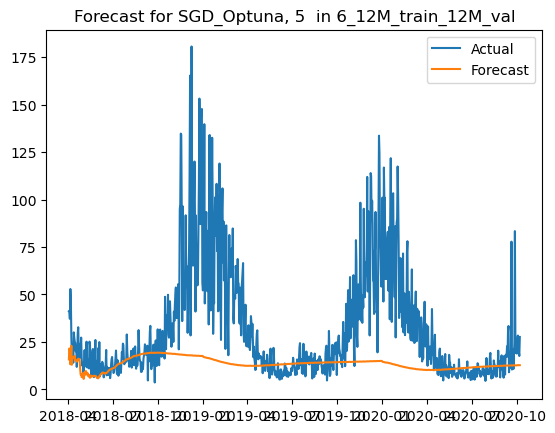

{'Apr_2018': 39.13792129619419, 'May_2018': 42.82225298485352, 'Jun_2018': 29.964330338751783, 'Jul_2018': 23.081926746428397, 'Aug_2018': 32.33220823679408, 'Sep_2018': 45.054473280217806, 'Oct_2018': 31.87786628216583, 'Nov_2018': 61.83249339167284, 'Dec_2018': 76.92471521563216, 'Jan_2019': 76.28238976612299, 'Feb_2019': 73.67851596823417, 'Mar_2019': 69.51411990229505, 'Apr_2019': 39.587058337819336, 'May_2019': 33.563886473962775, 'Jun_2019': 62.97302451482525, 'Jul_2019': 30.42697137696992, 'Aug_2019': 27.387703780536267, 'Sep_2019': 43.791594435995954, 'Oct_2019': 40.93041123072057, 'Nov_2019': 65.67058484318203, 'Dec_2019': 75.51367774670669, 'Jan_2020': 79.55766542965763, 'Feb_2020': 72.84876211312414, 'Mar_2020': 64.97472334740668, 'Apr_2020': 39.18576440724833, 'May_2020': 36.286178756202794, 'Jun_2020': 42.523495497540154, 'Jul_2020': 44.51404732383463, 'Aug_2020': 35.53223101854579, 'Sep_2020': 37.0644460786714, 'Oct_2020': 42.41083259575036}
{'test_30_days': 38.6561564437

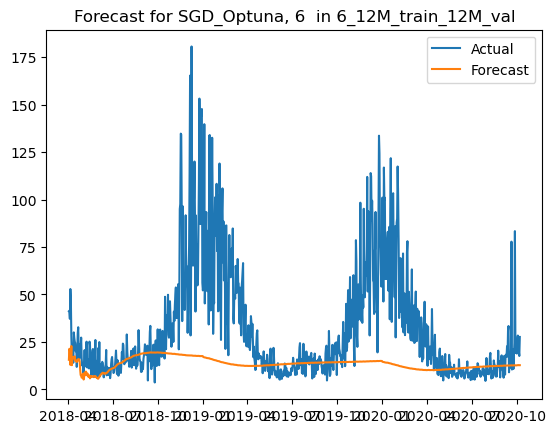

DATASET: 6_16M_train_8M_val
6 16 16M_train_8M_val
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
268  SGD_Optuna     24.272429     36.986526     33.061320      39.774430   
358  SGD_Optuna     23.143793     30.815928     32.876985      54.293660   
335  SGD_Optuna     21.784725     32.100221     33.170049      54.214970   
278  SGD_Optuna     25.127438     31.911894     32.455465      53.104965   
324  SGD_Optuna     25.246520     31.711957     32.618773      53.450272   
174  SGD_Optuna     26.772925     42.445629     36.596462      46.168059   
366  SGD_Optuna     37.768086     45.893901     41.143875      42.979199   
36   SGD_Optuna     34.241008     38.659235     35.624898      43.785444   
122  SGD_Optuna     31.140041     41.392073     36.841946      41.249445   

     test_360_days  
268     799.454089  
358      53.698528  
335      54.133590  
278      54.023473  
324      53.978840  
174    1094.620181  
366     137.201956  
36       82.821696  


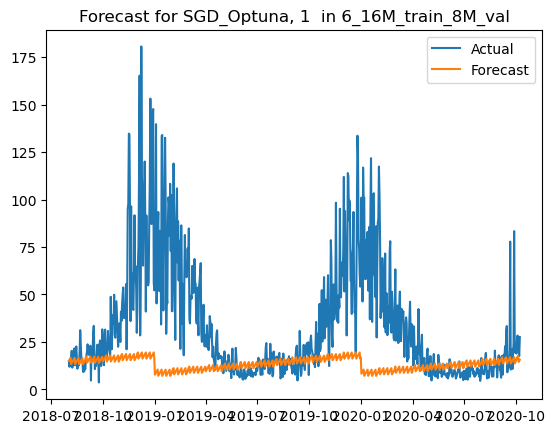

{'Aug_2018': 21.78472516066915, 'Sep_2018': 42.41571643185074, 'Oct_2018': 35.76552142829639, 'Nov_2018': 63.268457995714186, 'Dec_2018': 75.71196847374728, 'Jan_2019': 88.43530966128193, 'Feb_2019': 83.36538587413317, 'Mar_2019': 76.42338202529133, 'Apr_2019': 45.80961386004185, 'May_2019': 30.761408937853552, 'Jun_2019': 57.03713694187466, 'Jul_2019': 30.395936830633907, 'Aug_2019': 28.434171769480326, 'Sep_2019': 48.72874030107886, 'Oct_2019': 35.76673225648966, 'Nov_2019': 59.92772437456728, 'Dec_2019': 69.31713591353973, 'Jan_2020': 88.28678389577591, 'Feb_2020': 79.48635341353925, 'Mar_2020': 67.23505418410099, 'Apr_2020': 37.965486063458705, 'May_2020': 43.16862292004714, 'Jun_2020': 59.08250075739861, 'Jul_2020': 64.53382736030603, 'Aug_2020': 51.80886500105659, 'Sep_2020': 40.35786839353738, 'Oct_2020': 24.62210954896637}
{'test_30_days': 21.784725162760115, 'test_60_days': 32.10022079568299, 'test_90_days': 33.17004902382848, 'test_120_days': 40.7673918628455, 'test_150_days'

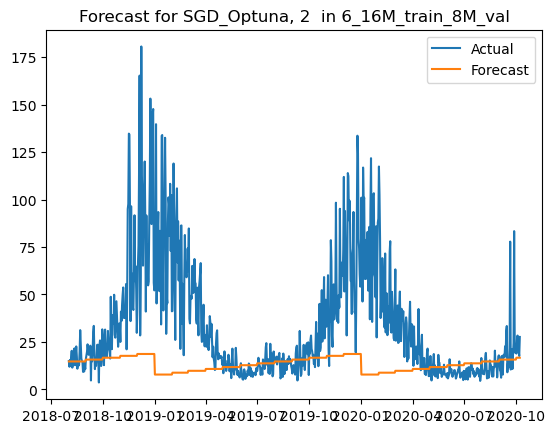

{'Aug_2018': 25.12743797173769, 'Sep_2018': 38.69634917290591, 'Oct_2018': 34.015958023256516, 'Nov_2018': 61.42469484202088, 'Dec_2018': 74.37582078147305, 'Jan_2019': 87.13241071812674, 'Feb_2019': 81.72038589818449, 'Mar_2019': 74.08156843689959, 'Apr_2019': 42.83992363343479, 'May_2019': 29.43113117717951, 'Jun_2019': 67.00259238231685, 'Jul_2019': 34.86864765574903, 'Aug_2019': 32.61542221774031, 'Sep_2019': 48.2108971981468, 'Oct_2019': 34.16450512726989, 'Nov_2019': 58.08711820729881, 'Dec_2019': 68.07134684641592, 'Jan_2020': 86.9071842053499, 'Feb_2020': 77.2004373415845, 'Mar_2020': 64.48171554547737, 'Apr_2020': 38.071809103443606, 'May_2020': 50.316474497137555, 'Jun_2020': 67.32154919161715, 'Jul_2020': 74.32626718792432, 'Aug_2020': 58.181803022621246, 'Sep_2020': 40.39183586363299, 'Oct_2020': 20.92856724549626}
{'test_30_days': 25.12743798252057, 'test_60_days': 31.9118935728581, 'test_90_days': 32.45546532060143, 'test_120_days': 39.80078801332459, 'test_150_days': 46.

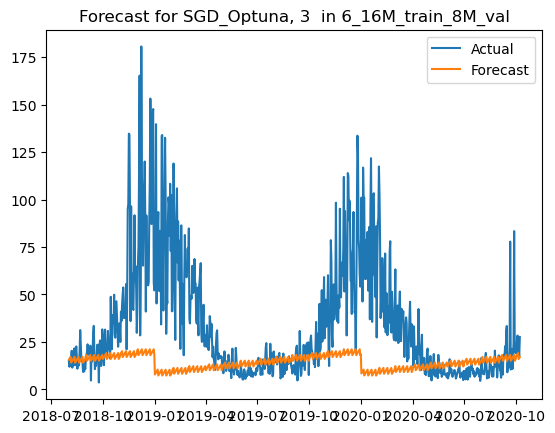

{'Aug_2018': 25.246520341198327, 'Sep_2018': 38.177394545985116, 'Oct_2018': 34.92296492982876, 'Nov_2018': 62.38955093059509, 'Dec_2018': 75.06373050939763, 'Jan_2019': 86.98567585898248, 'Feb_2019': 81.5596888030312, 'Mar_2019': 73.83917230683733, 'Apr_2019': 42.69214897221256, 'May_2019': 28.797927016464715, 'Jun_2019': 65.94081993619238, 'Jul_2019': 34.52025762776082, 'Aug_2019': 31.853755730056253, 'Sep_2019': 46.227997597197955, 'Oct_2019': 35.081044106372936, 'Nov_2019': 58.98783240343518, 'Dec_2019': 68.84908667883552, 'Jan_2020': 86.7491083474375, 'Feb_2020': 76.94655606978739, 'Mar_2020': 64.2413915684594, 'Apr_2020': 38.36868184010485, 'May_2020': 50.40697145556274, 'Jun_2020': 65.83891175973406, 'Jul_2020': 72.32989939485127, 'Aug_2020': 55.95242640867972, 'Sep_2020': 39.6485531185854, 'Oct_2020': 22.854722181383107}
{'test_30_days': 25.24652033598412, 'test_60_days': 31.711957440694505, 'test_90_days': 32.618773127422855, 'test_120_days': 40.16567142713862, 'test_150_days'

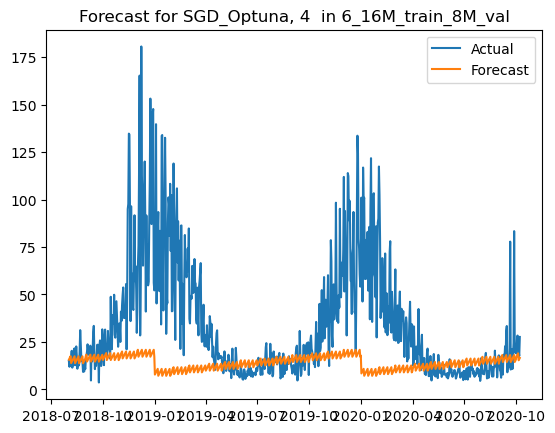

{'Aug_2018': 37.76808613187954, 'Sep_2018': 54.01971545827215, 'Oct_2018': 30.888250575085372, 'Nov_2018': 33.020716094131416, 'Dec_2018': 44.3881612696536, 'Jan_2019': 57.32902460721269, 'Feb_2019': 42.33675450281839, 'Mar_2019': 45.39757670119504, 'Apr_2019': 117.59390839460761, 'May_2019': 289.0053856253386, 'Jun_2019': 491.0197198481897, 'Jul_2019': 448.0163492932833, 'Aug_2019': 518.1528354600839, 'Sep_2019': 567.1733397792754, 'Oct_2019': 345.68315785987386, 'Nov_2019': 198.71834394204885, 'Dec_2019': 109.05704838711377, 'Jan_2020': 120.43654377364021, 'Feb_2020': 249.3129855732581, 'Mar_2020': 455.7760581568589, 'Apr_2020': 1119.1159102652225, 'May_2020': 1968.4848471507917, 'Jun_2020': 2399.8418118556338, 'Jul_2020': 2552.8982634789154, 'Aug_2020': 2302.2733183365094, 'Sep_2020': 1691.053201448294, 'Oct_2020': 1202.7532547571966}
{'test_30_days': 37.76808613533031, 'test_60_days': 45.89390079220465, 'test_90_days': 41.14387541127305, 'test_120_days': 38.08395100122418, 'test_15

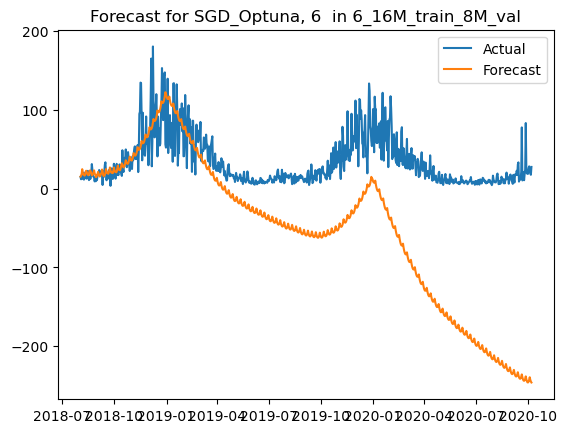

{'Aug_2018': 34.24100847459612, 'Sep_2018': 43.07746065134267, 'Oct_2018': 29.503379739254303, 'Nov_2018': 42.16253633166163, 'Dec_2018': 53.906920611245134, 'Jan_2019': 62.09966032993254, 'Feb_2019': 73.6762694254086, 'Mar_2019': 86.80709576900927, 'Apr_2019': 106.86053161197076, 'May_2019': 147.29215006343682, 'Jun_2019': 175.683768341648, 'Jul_2019': 145.82860546622086, 'Aug_2019': 124.63428764594917, 'Sep_2019': 99.75199907860744, 'Oct_2019': 75.54640363813864, 'Nov_2019': 69.50655871910327, 'Dec_2019': 65.96625046057135, 'Jan_2020': 81.18796274998043, 'Feb_2020': 94.94742142553537, 'Mar_2020': 118.54428056520752, 'Apr_2020': 180.4651856760391, 'May_2020': 250.43614686852007, 'Jun_2020': 282.8860805878864, 'Jul_2020': 258.0136516013542, 'Aug_2020': 201.04078664171533, 'Sep_2020': 141.845633112553, 'Oct_2020': 107.90618911930834}
{'test_30_days': 34.24100848489773, 'test_60_days': 38.6592345992239, 'test_90_days': 35.62489799647389, 'test_120_days': 37.41151717979251, 'test_150_days

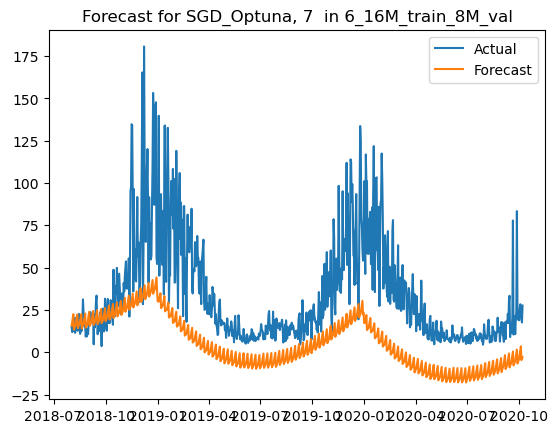

{'Aug_2018': 31.140040948700005, 'Sep_2018': 51.64410441023066, 'Oct_2018': 27.260357392920238, 'Nov_2018': 39.96502550407686, 'Dec_2018': 53.307652599472846, 'Jan_2019': 43.49477773689813, 'Feb_2019': 43.80263870952621, 'Mar_2019': 32.88597003230487, 'Apr_2019': 136.81578564116893, 'May_2019': 345.8017965229265, 'Jun_2019': 540.8782221875518, 'Jul_2019': 358.23253618874674, 'Aug_2019': 385.31586253571504, 'Sep_2019': 412.7302997846763, 'Oct_2019': 197.70078385917859, 'Nov_2019': 83.79697726244336, 'Dec_2019': 48.11264807083582, 'Jan_2020': 37.96087434144968, 'Feb_2020': 102.11085663584902, 'Mar_2020': 192.10877489389668, 'Apr_2020': 536.6519021918863, 'May_2020': 937.7439408961417, 'Jun_2020': 1075.5261111122402, 'Jul_2020': 1079.1801775331064, 'Aug_2020': 916.9418140102568, 'Sep_2020': 615.8240299634347, 'Oct_2020': 398.7272035479525}
{'test_30_days': 31.140040941961693, 'test_60_days': 41.39207267220372, 'test_90_days': 36.84194599967805, 'test_120_days': 37.60848593967215, 'test_15

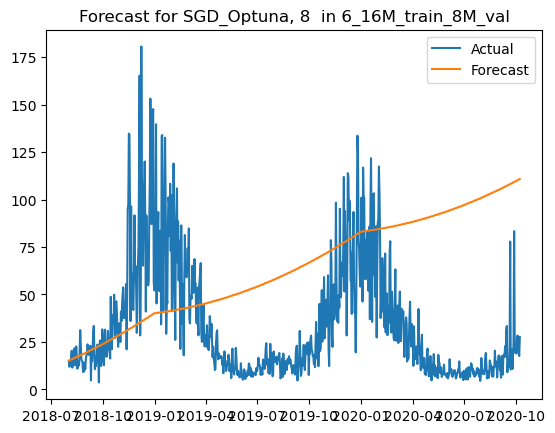

DATASET: 6_20M_train_4M_val
6 20 20M_train_4M_val
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
27   SGD_Optuna     35.165689     39.136105     34.590254      33.078255   
43   SGD_Optuna     39.435448     39.773150     34.066789      28.107524   
35   SGD_Optuna     39.352457     39.474983     34.136043      44.749851   
40   SGD_Optuna     39.159338     39.429153     34.014761      65.871119   
168  SGD_Optuna     36.892172     39.456848     35.408949      37.156432   
239  SGD_Optuna     38.233962     39.703119     34.531753      31.601551   
355  SGD_Optuna     38.875830     40.794651     36.065831      31.957250   
69   SGD_Optuna     41.937388     42.120243     35.597370      32.027069   

     test_360_days  
27       86.322904  
43       53.811017  
35       95.900736  
40      109.866897  
168      38.142045  
239      37.021136  
355      41.863133  
69       79.130281  
{'Jan_2019': 35.165689336268144, 'Feb_2019': 42.79596169379199, 'Mar_2019': 

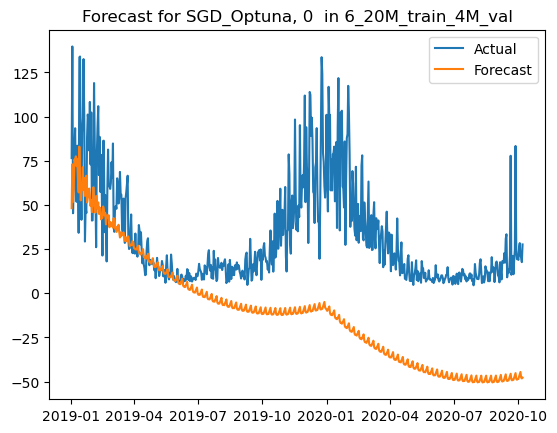

{'Jan_2019': 39.43544752970126, 'Feb_2019': 40.273709643903416, 'Mar_2019': 24.316831290200767, 'Apr_2019': 21.81381364932857, 'May_2019': 21.451418014572194, 'Jun_2019': 22.513227271597152, 'Jul_2019': 34.050910370457, 'Aug_2019': 82.65305194042956, 'Sep_2019': 162.4588314043678, 'Oct_2019': 97.1767950551279, 'Nov_2019': 51.849174385910544, 'Dec_2019': 44.11385783775999, 'Jan_2020': 31.61857555118318, 'Feb_2020': 33.421392163845006, 'Mar_2020': 28.558779291519603, 'Apr_2020': 43.99908185164771, 'May_2020': 56.07984662581175, 'Jun_2020': 71.39359937724537, 'Jul_2020': 132.65372940143644, 'Aug_2020': 181.71559825538063, 'Sep_2020': 167.88303563977175, 'Oct_2020': 117.04380984446207}
{'test_30_days': 39.43544752952953, 'test_60_days': 39.77314994278643, 'test_90_days': 34.0667889296114, 'test_120_days': 31.088423219557743, 'test_150_days': 29.226382890674056, 'test_180_days': 28.10752361923857, 'test_240_days': 34.96167531400512, 'test_300_days': 54.883611736241534, 'test_360_days': 53.8

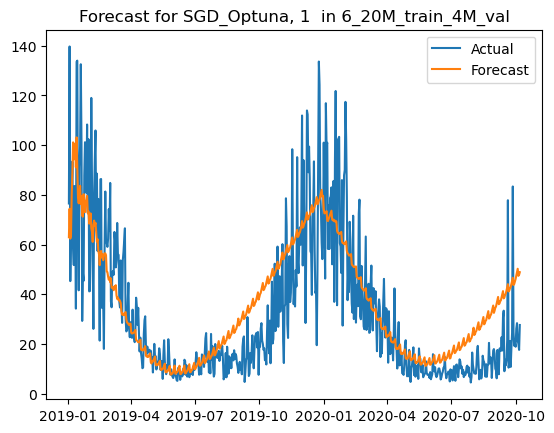

{'Jan_2019': 39.35245713356057, 'Feb_2019': 39.91079216115668, 'Mar_2019': 24.64877793045788, 'Apr_2019': 25.694623642344904, 'May_2019': 43.31262376522962, 'Jun_2019': 95.97517143748536, 'Jul_2019': 85.47217194889343, 'Aug_2019': 172.75291127004607, 'Sep_2019': 274.917659132152, 'Oct_2019': 172.4161229037491, 'Nov_2019': 97.84904518531742, 'Dec_2019': 72.01815001011461, 'Jan_2020': 45.74915671598247, 'Feb_2020': 69.30237036981323, 'Mar_2020': 63.047457880922266, 'Apr_2020': 120.90904963978375, 'May_2020': 166.85502498598242, 'Jun_2020': 180.20801248752505, 'Jul_2020': 240.39215673912636, 'Aug_2020': 283.98598899357654, 'Sep_2020': 250.0098933900737, 'Oct_2020': 184.00685237916164}
{'test_30_days': 39.352457133195735, 'test_60_days': 39.474982832646496, 'test_90_days': 34.1360428296163, 'test_120_days': 32.088717790111176, 'test_150_days': 34.50478704144379, 'test_180_days': 44.749851106367856, 'test_240_days': 64.81137086242964, 'test_300_days': 98.00813143302172, 'test_360_days': 95.

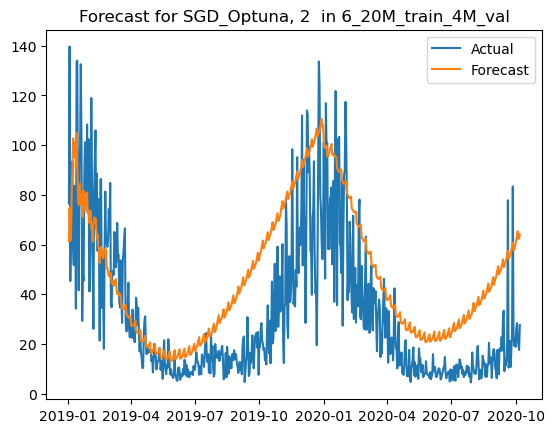

{'Jan_2019': 39.15933750495734, 'Feb_2019': 39.70148958490375, 'Mar_2019': 24.844526393582615, 'Apr_2019': 27.609339084853314, 'May_2019': 77.56569821825343, 'Jun_2019': 185.5794166837945, 'Jul_2019': 154.7135584490952, 'Aug_2019': 225.4630271846083, 'Sep_2019': 285.1821867187593, 'Oct_2019': 141.50489064949184, 'Nov_2019': 59.410563198419894, 'Dec_2019': 40.33276762890519, 'Jan_2020': 31.722567053593114, 'Feb_2020': 26.45565814757247, 'Mar_2020': 28.591667139841697, 'Apr_2020': 53.33346575584852, 'May_2020': 128.95251325707252, 'Jun_2020': 210.94236507720709, 'Jul_2020': 293.68044537158073, 'Aug_2020': 308.27684867347574, 'Sep_2020': 230.43041040834504, 'Oct_2020': 144.4359800097305}
{'test_30_days': 39.15933750532575, 'test_60_days': 39.42915297259365, 'test_90_days': 34.01476114314723, 'test_120_days': 32.63334716083669, 'test_150_days': 41.92945978987594, 'test_180_days': 65.87111926790855, 'test_240_days': 96.07830425049282, 'test_300_days': 121.43134115343518, 'test_360_days': 10

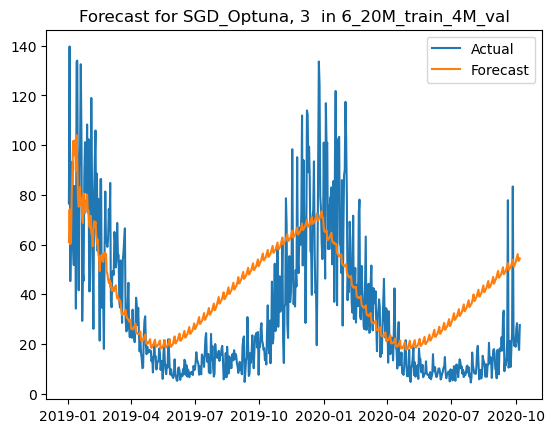

{'Jan_2019': 36.89217169651322, 'Feb_2019': 42.07418288568244, 'Mar_2019': 28.776660728601293, 'Apr_2019': 28.596177345425616, 'May_2019': 38.845711003475245, 'Jun_2019': 48.304552833943006, 'Jul_2019': 31.126538088588866, 'Aug_2019': 31.25789173191898, 'Sep_2019': 61.58342516754668, 'Oct_2019': 38.48764893263908, 'Nov_2019': 31.736118411536918, 'Dec_2019': 37.513891390383435, 'Jan_2020': 32.48375714807535, 'Feb_2020': 26.01803472852893, 'Mar_2020': 33.57724525968175, 'Apr_2020': 30.512982626907377, 'May_2020': 60.12994988633983, 'Jun_2020': 105.21087931243973, 'Jul_2020': 109.26035370513819, 'Aug_2020': 80.45075392277826, 'Sep_2020': 49.76647382766238, 'Oct_2020': 39.33026342145677}
{'test_30_days': 36.89217170144855, 'test_60_days': 39.45684810905232, 'test_90_days': 35.40894867784353, 'test_120_days': 33.63461074009275, 'test_150_days': 34.92680742802793, 'test_180_days': 37.15643164539648, 'test_240_days': 35.52706877618062, 'test_300_days': 38.721880460888265, 'test_360_days': 38.

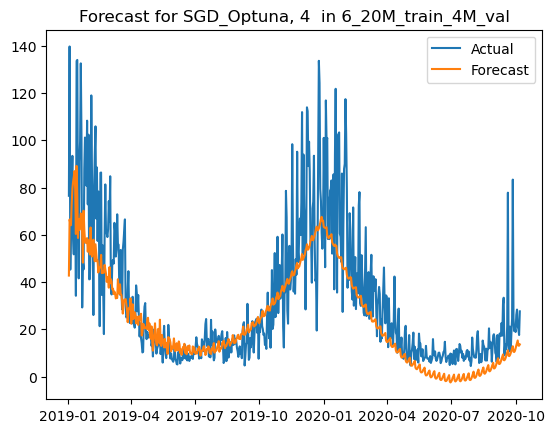

{'Jan_2019': 38.233961927794276, 'Feb_2019': 41.416122420020926, 'Mar_2019': 25.083566555556335, 'Apr_2019': 29.794501539808692, 'May_2019': 30.712317984217393, 'Jun_2019': 25.270047373829, 'Jul_2019': 30.03958095706697, 'Aug_2019': 33.131894810340015, 'Sep_2019': 73.82310875862534, 'Oct_2019': 39.49771977189383, 'Nov_2019': 35.10691339561756, 'Dec_2019': 42.11016779859712, 'Jan_2020': 51.74253379787014, 'Feb_2020': 44.31588926586255, 'Mar_2020': 40.9899718522388, 'Apr_2020': 35.50027976239824, 'May_2020': 51.96074908391377, 'Jun_2020': 77.54810709298107, 'Jul_2020': 114.41377801189267, 'Aug_2020': 125.16974775709232, 'Sep_2020': 96.79488491194161, 'Oct_2020': 43.58724727959441}
{'test_30_days': 38.23396192645437, 'test_60_days': 39.703118652532034, 'test_90_days': 34.53175318313184, 'test_120_days': 33.34661954653902, 'test_150_days': 32.86785168225972, 'test_180_days': 31.60155096302352, 'test_240_days': 31.415871734258577, 'test_300_days': 36.77754566408487, 'test_360_days': 37.0211

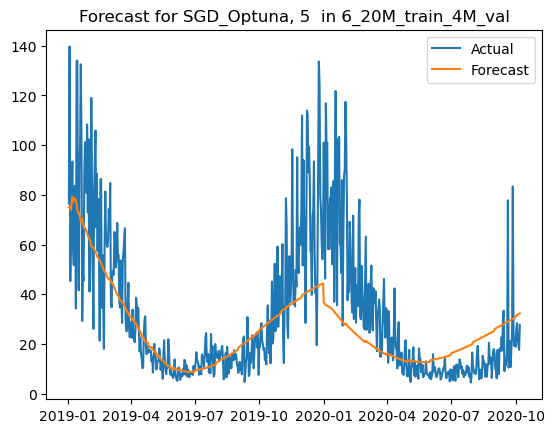

{'Jan_2019': 38.87583049071598, 'Feb_2019': 42.439898529782596, 'Mar_2019': 28.618660687027553, 'Apr_2019': 26.898043653605026, 'May_2019': 29.952907455646248, 'Jun_2019': 25.835100740645274, 'Jul_2019': 54.129421371245975, 'Aug_2019': 61.108511029461745, 'Sep_2019': 44.26581235063191, 'Oct_2019': 55.54147737094647, 'Nov_2019': 54.122020490184795, 'Dec_2019': 35.84636191605164, 'Jan_2020': 35.703780197579924, 'Feb_2020': 27.308100276939186, 'Mar_2020': 39.5427432202317, 'Apr_2020': 44.85107917865418, 'May_2020': 72.16663643467274, 'Jun_2020': 120.49986160612754, 'Jul_2020': 158.18051825706564, 'Aug_2020': 94.63334861490733, 'Sep_2020': 44.52521767137552, 'Oct_2020': 29.954556719331514}
{'test_30_days': 38.87583049350564, 'test_60_days': 40.79465102406942, 'test_90_days': 36.06583093154551, 'test_120_days': 33.9346898462271, 'test_150_days': 33.181679977702416, 'test_180_days': 31.95725010324184, 'test_240_days': 38.47123710242553, 'test_300_days': 41.05964491068839, 'test_360_days': 41

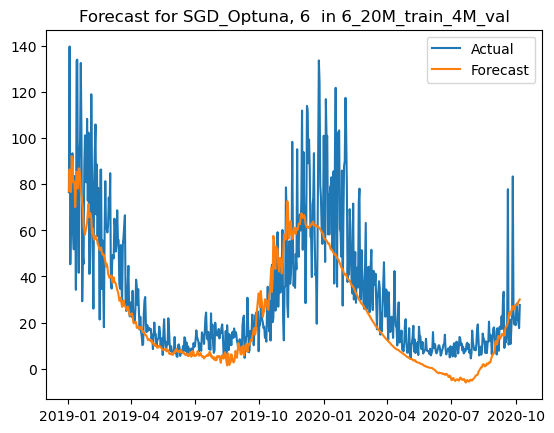

{'Jan_2019': 41.93738806805599, 'Feb_2019': 43.20202379564838, 'Mar_2019': 23.509774672993878, 'Apr_2019': 25.725329669917972, 'May_2019': 34.9636843518742, 'Jun_2019': 23.75523578223266, 'Jul_2019': 36.44672077110974, 'Aug_2019': 122.87340073706534, 'Sep_2019': 249.78755278760718, 'Oct_2019': 170.93100155002836, 'Nov_2019': 100.56709233915664, 'Dec_2019': 73.3042170790451, 'Jan_2020': 41.06187618970992, 'Feb_2020': 51.38695511083022, 'Mar_2020': 31.79942836598463, 'Apr_2020': 30.903159891571203, 'May_2020': 66.42664218188803, 'Jun_2020': 70.18394738239905, 'Jul_2020': 46.84583425076076, 'Aug_2020': 152.3635694301169, 'Sep_2020': 192.02906520397966, 'Oct_2020': 156.3410083181034}
{'test_30_days': 41.93738805691488, 'test_60_days': 42.12024347682581, 'test_90_days': 35.59737002408097, 'test_120_days': 33.222956663838104, 'test_150_days': 33.68143618347641, 'test_180_days': 32.02706945045384, 'test_240_days': 42.841885957891954, 'test_300_days': 77.46891861386881, 'test_360_days': 79.130

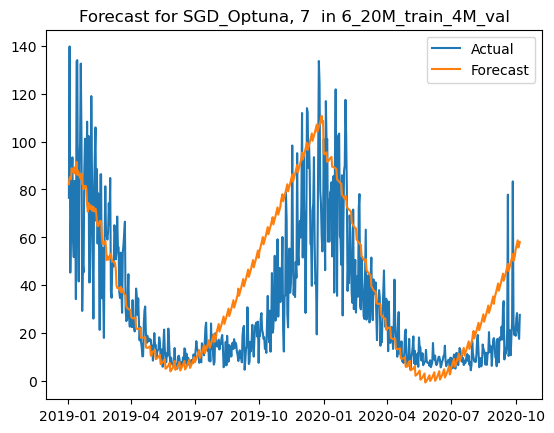

DATASET: 6_24M_train
6 24 24M_train
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
195  SGD_Optuna     29.718222     28.105103     31.221257      39.765034   
211  SGD_Optuna     29.718222     28.105103     31.221257      39.765034   
219  SGD_Optuna     29.718222     28.105103     31.221257      39.765034   
194  SGD_Optuna     29.608248     28.350841     31.916043      40.251583   
210  SGD_Optuna     29.608248     28.350841     31.916043      40.251583   
262  SGD_Optuna     38.609809     44.582640     48.194068      44.761050   
278  SGD_Optuna     38.609809     44.582640     48.194068      44.761050   
286  SGD_Optuna     38.609809     44.582640     48.194068      44.761050   
263  SGD_Optuna     38.670106     44.665181     48.265683      44.769104   
279  SGD_Optuna     38.670106     44.665181     48.265683      44.769104   

     test_360_days  
195      48.260972  
211      48.260972  
219      48.260972  
194      48.585735  
210      48.585735  
2

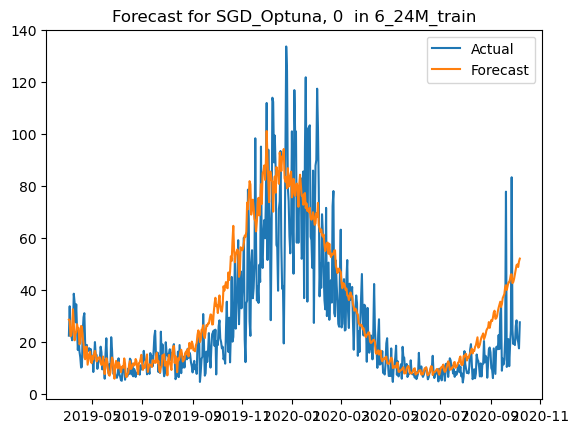

{'Apr_2019': 30.725568562977184, 'May_2019': 25.653699414576053, 'Jun_2019': 37.45356526795727, 'Jul_2019': 32.7916537641331, 'Aug_2019': 31.237286594734044, 'Sep_2019': 91.96285859912268, 'Oct_2019': 90.69309419349342, 'Nov_2019': 75.74847014422733, 'Dec_2019': 55.05267247959533, 'Jan_2020': 33.03670541641704, 'Feb_2020': 42.115099391608204, 'Mar_2020': 29.72804294809141, 'Apr_2020': 36.76530024381685, 'May_2020': 32.176355914647054, 'Jun_2020': 17.433072420741713, 'Jul_2020': 39.14410450519726, 'Aug_2020': 89.18629286710072, 'Sep_2020': 141.15736160405598, 'Oct_2020': 122.65338425123187}
{'test_30_days': 29.718222299605905, 'test_60_days': 28.1051028334102, 'test_90_days': 31.22125697344133, 'test_120_days': 31.653768086742552, 'test_150_days': 31.08829748584485, 'test_180_days': 39.76503427041006, 'test_240_days': 52.2813602447379, 'test_300_days': 50.50306775133957, 'test_360_days': 48.26097235368216, 'test_480_days': 43.44261457614772, 'test_600_days': 52.62390821054191, 'test_720

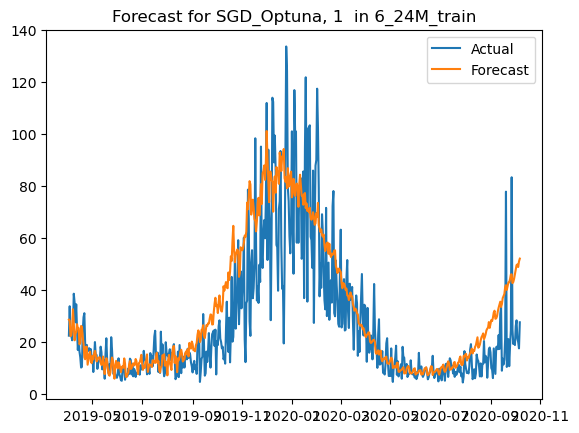

{'Apr_2019': 30.725568562977184, 'May_2019': 25.653699414576053, 'Jun_2019': 37.45356526795727, 'Jul_2019': 32.7916537641331, 'Aug_2019': 31.237286594734044, 'Sep_2019': 91.96285859912268, 'Oct_2019': 90.69309419349342, 'Nov_2019': 75.74847014422733, 'Dec_2019': 55.05267247959533, 'Jan_2020': 33.03670541641704, 'Feb_2020': 42.115099391608204, 'Mar_2020': 29.72804294809141, 'Apr_2020': 36.76530024381685, 'May_2020': 32.176355914647054, 'Jun_2020': 17.433072420741713, 'Jul_2020': 39.14410450519726, 'Aug_2020': 89.18629286710072, 'Sep_2020': 141.15736160405598, 'Oct_2020': 122.65338425123187}
{'test_30_days': 29.718222299605905, 'test_60_days': 28.1051028334102, 'test_90_days': 31.22125697344133, 'test_120_days': 31.653768086742552, 'test_150_days': 31.08829748584485, 'test_180_days': 39.76503427041006, 'test_240_days': 52.2813602447379, 'test_300_days': 50.50306775133957, 'test_360_days': 48.26097235368216, 'test_480_days': 43.44261457614772, 'test_600_days': 52.62390821054191, 'test_720

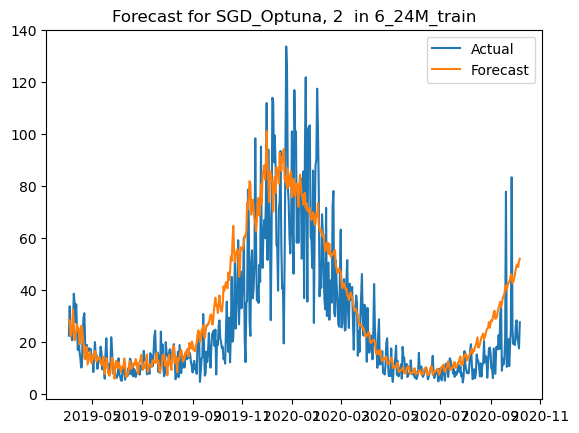

{'Apr_2019': 30.60763255232145, 'May_2019': 26.239649124778325, 'Jun_2019': 39.046447010288915, 'Jul_2019': 32.82307630053373, 'Aug_2019': 31.47084784983446, 'Sep_2019': 92.58992103684076, 'Oct_2019': 91.0054423405854, 'Nov_2019': 75.90445243996913, 'Dec_2019': 54.92303241547647, 'Jan_2020': 33.10485305312112, 'Feb_2020': 42.39815001412551, 'Mar_2020': 29.888347907325226, 'Apr_2020': 37.57291548830141, 'May_2020': 32.75703464876426, 'Jun_2020': 19.201276017265627, 'Jul_2020': 40.56991931314059, 'Aug_2020': 90.35333467728877, 'Sep_2020': 141.72794154731082, 'Oct_2020': 122.8462441604443}
{'test_30_days': 29.60824827226199, 'test_60_days': 28.35084111366475, 'test_90_days': 31.916043074960783, 'test_120_days': 32.1934755790254, 'test_150_days': 31.546645022461743, 'test_180_days': 40.25158314196059, 'test_240_days': 52.71312353294557, 'test_300_days': 50.84177078080726, 'test_360_days': 48.58573482248127, 'test_480_days': 43.94727672632967, 'test_600_days': 53.18122824007352, 'test_720_d

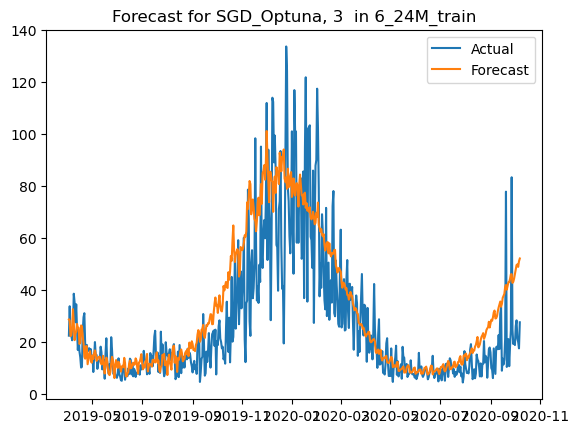

{'Apr_2019': 30.60763255232145, 'May_2019': 26.239649124778325, 'Jun_2019': 39.046447010288915, 'Jul_2019': 32.82307630053373, 'Aug_2019': 31.47084784983446, 'Sep_2019': 92.58992103684076, 'Oct_2019': 91.0054423405854, 'Nov_2019': 75.90445243996913, 'Dec_2019': 54.92303241547647, 'Jan_2020': 33.10485305312112, 'Feb_2020': 42.39815001412551, 'Mar_2020': 29.888347907325226, 'Apr_2020': 37.57291548830141, 'May_2020': 32.75703464876426, 'Jun_2020': 19.201276017265627, 'Jul_2020': 40.56991931314059, 'Aug_2020': 90.35333467728877, 'Sep_2020': 141.72794154731082, 'Oct_2020': 122.8462441604443}
{'test_30_days': 29.60824827226199, 'test_60_days': 28.35084111366475, 'test_90_days': 31.916043074960783, 'test_120_days': 32.1934755790254, 'test_150_days': 31.546645022461743, 'test_180_days': 40.25158314196059, 'test_240_days': 52.71312353294557, 'test_300_days': 50.84177078080726, 'test_360_days': 48.58573482248127, 'test_480_days': 43.94727672632967, 'test_600_days': 53.18122824007352, 'test_720_d

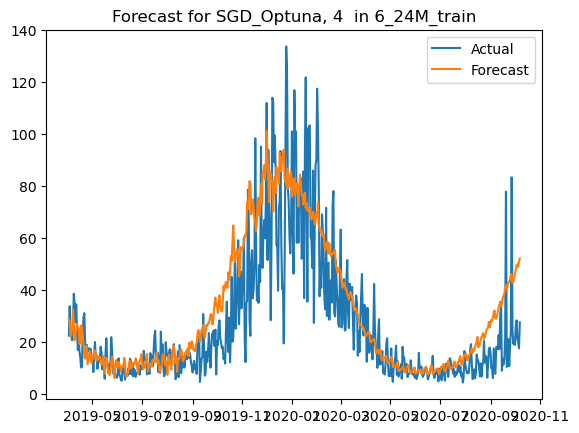

{'Apr_2019': 38.80906872401838, 'May_2019': 49.98372329569943, 'Jun_2019': 55.41692313715575, 'Jul_2019': 46.150530501753956, 'Aug_2019': 41.57050146237253, 'Sep_2019': 37.072319881745784, 'Oct_2019': 35.20481185038224, 'Nov_2019': 32.33419918182745, 'Dec_2019': 37.75146363434169, 'Jan_2020': 36.561059054911205, 'Feb_2020': 28.811401197023535, 'Mar_2020': 27.311675633111644, 'Apr_2020': 85.56027991355238, 'May_2020': 137.1439617059869, 'Jun_2020': 104.52872095925268, 'Jul_2020': 85.32010273593191, 'Aug_2020': 72.1240690322111, 'Sep_2020': 61.447334224753604, 'Oct_2020': 29.794223237265122}
{'test_30_days': 38.60980898904257, 'test_60_days': 44.58264025270949, 'test_90_days': 48.194067878439725, 'test_120_days': 47.58468412212724, 'test_150_days': 46.721333380069474, 'test_180_days': 44.761050165035314, 'test_240_days': 42.39250191179548, 'test_300_days': 41.00275641987008, 'test_360_days': 39.06388863960806, 'test_480_days': 54.54723919954988, 'test_600_days': 56.04166733921051, 'test_

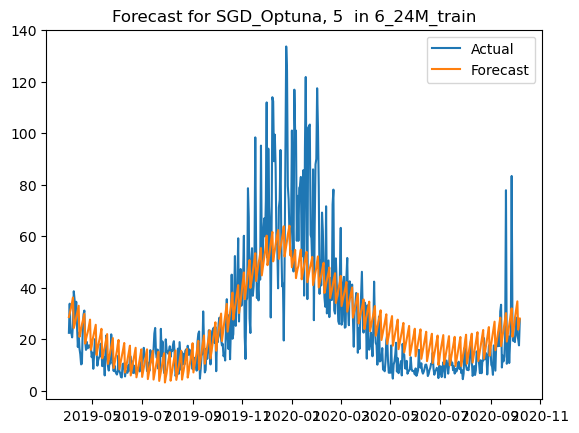

{'Apr_2019': 38.80906872401838, 'May_2019': 49.98372329569943, 'Jun_2019': 55.41692313715575, 'Jul_2019': 46.150530501753956, 'Aug_2019': 41.57050146237253, 'Sep_2019': 37.072319881745784, 'Oct_2019': 35.20481185038224, 'Nov_2019': 32.33419918182745, 'Dec_2019': 37.75146363434169, 'Jan_2020': 36.561059054911205, 'Feb_2020': 28.811401197023535, 'Mar_2020': 27.311675633111644, 'Apr_2020': 85.56027991355238, 'May_2020': 137.1439617059869, 'Jun_2020': 104.52872095925268, 'Jul_2020': 85.32010273593191, 'Aug_2020': 72.1240690322111, 'Sep_2020': 61.447334224753604, 'Oct_2020': 29.794223237265122}
{'test_30_days': 38.60980898904257, 'test_60_days': 44.58264025270949, 'test_90_days': 48.194067878439725, 'test_120_days': 47.58468412212724, 'test_150_days': 46.721333380069474, 'test_180_days': 44.761050165035314, 'test_240_days': 42.39250191179548, 'test_300_days': 41.00275641987008, 'test_360_days': 39.06388863960806, 'test_480_days': 54.54723919954988, 'test_600_days': 56.04166733921051, 'test_

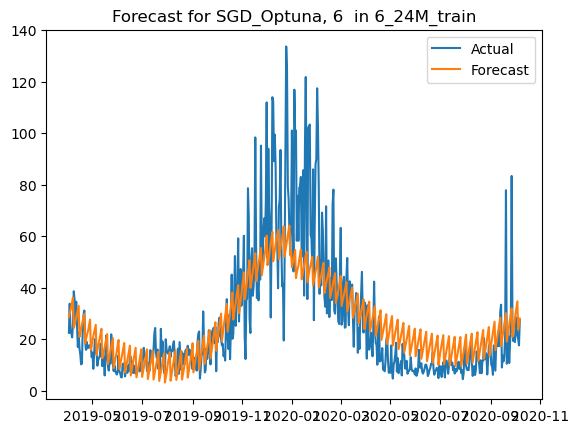

{'Apr_2019': 38.80906872401838, 'May_2019': 49.98372329569943, 'Jun_2019': 55.41692313715575, 'Jul_2019': 46.150530501753956, 'Aug_2019': 41.57050146237253, 'Sep_2019': 37.072319881745784, 'Oct_2019': 35.20481185038224, 'Nov_2019': 32.33419918182745, 'Dec_2019': 37.75146363434169, 'Jan_2020': 36.561059054911205, 'Feb_2020': 28.811401197023535, 'Mar_2020': 27.311675633111644, 'Apr_2020': 85.56027991355238, 'May_2020': 137.1439617059869, 'Jun_2020': 104.52872095925268, 'Jul_2020': 85.32010273593191, 'Aug_2020': 72.1240690322111, 'Sep_2020': 61.447334224753604, 'Oct_2020': 29.794223237265122}
{'test_30_days': 38.60980898904257, 'test_60_days': 44.58264025270949, 'test_90_days': 48.194067878439725, 'test_120_days': 47.58468412212724, 'test_150_days': 46.721333380069474, 'test_180_days': 44.761050165035314, 'test_240_days': 42.39250191179548, 'test_300_days': 41.00275641987008, 'test_360_days': 39.06388863960806, 'test_480_days': 54.54723919954988, 'test_600_days': 56.04166733921051, 'test_

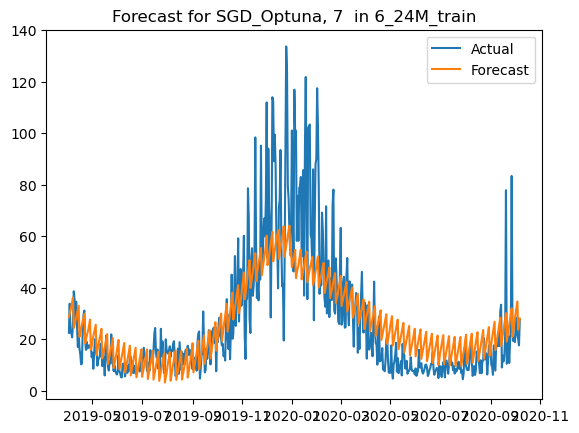

{'Apr_2019': 38.86671744290254, 'May_2019': 50.089550955298655, 'Jun_2019': 55.46668568655624, 'Jul_2019': 46.051817189663346, 'Aug_2019': 41.481760977504756, 'Sep_2019': 37.10701814409196, 'Oct_2019': 35.202883230809775, 'Nov_2019': 32.327403729013, 'Dec_2019': 37.73897723996606, 'Jan_2020': 36.551908565174266, 'Feb_2020': 28.80661768639553, 'Mar_2020': 27.33303386212548, 'Apr_2020': 85.66632037482307, 'May_2020': 137.3391090310913, 'Jun_2020': 104.78141095588984, 'Jul_2020': 85.53583749068429, 'Aug_2020': 72.25881588707396, 'Sep_2020': 61.51100179394042, 'Oct_2020': 29.82437511191956}
{'test_30_days': 38.67010568820353, 'test_60_days': 44.66518142082057, 'test_90_days': 48.26568284235485, 'test_120_days': 47.61367795168415, 'test_150_days': 46.72553786090456, 'test_180_days': 44.76910409056602, 'test_240_days': 42.398267597056005, 'test_300_days': 41.005118165012455, 'test_360_days': 39.06798794587067, 'test_480_days': 54.59449779859836, 'test_600_days': 56.097634395428855, 'test_720

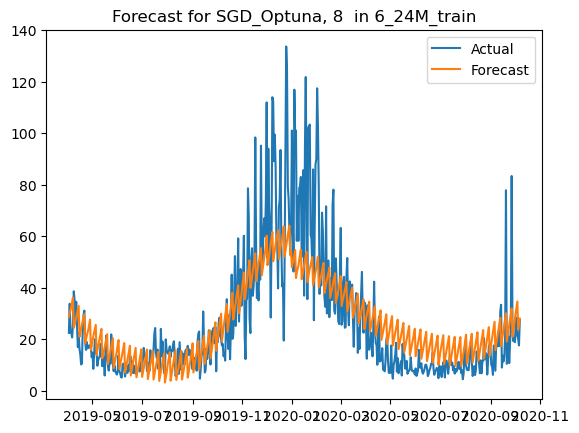

{'Apr_2019': 38.86671744290254, 'May_2019': 50.089550955298655, 'Jun_2019': 55.46668568655624, 'Jul_2019': 46.051817189663346, 'Aug_2019': 41.481760977504756, 'Sep_2019': 37.10701814409196, 'Oct_2019': 35.202883230809775, 'Nov_2019': 32.327403729013, 'Dec_2019': 37.73897723996606, 'Jan_2020': 36.551908565174266, 'Feb_2020': 28.80661768639553, 'Mar_2020': 27.33303386212548, 'Apr_2020': 85.66632037482307, 'May_2020': 137.3391090310913, 'Jun_2020': 104.78141095588984, 'Jul_2020': 85.53583749068429, 'Aug_2020': 72.25881588707396, 'Sep_2020': 61.51100179394042, 'Oct_2020': 29.82437511191956}
{'test_30_days': 38.67010568820353, 'test_60_days': 44.66518142082057, 'test_90_days': 48.26568284235485, 'test_120_days': 47.61367795168415, 'test_150_days': 46.72553786090456, 'test_180_days': 44.76910409056602, 'test_240_days': 42.398267597056005, 'test_300_days': 41.005118165012455, 'test_360_days': 39.06798794587067, 'test_480_days': 54.59449779859836, 'test_600_days': 56.097634395428855, 'test_720

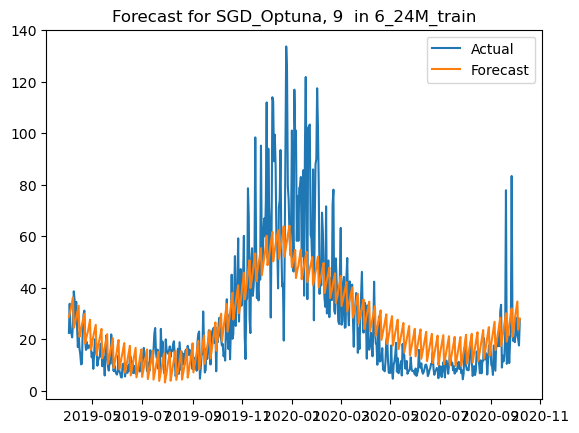

DATASET: 6_24M_train_24M_val
6 24 24M_train_24M_val
          Model  test_30_days  test_60_days  test_90_days  test_180_days  \
380  SGD_Optuna     24.941697     25.645831     26.077407      30.483787   
355  SGD_Optuna     24.455693     26.755499     28.383064      32.575036   
381  SGD_Optuna     26.451214     25.387467     27.900471      31.470437   
382  SGD_Optuna     26.569066     25.439059     28.210078      31.471644   
357  SGD_Optuna     26.737784     25.501685     28.678757      31.498420   
375  SGD_Optuna     27.302650     26.679772     27.945762      31.869548   

     test_360_days  
380      33.241609  
355      37.560509  
381      36.190258  
382      36.268681  
357      36.428151  
375      36.149107  
{'Apr_2019': 25.24471688561417, 'May_2019': 26.02106644619397, 'Jun_2019': 26.940558819725606, 'Jul_2019': 31.81784592324373, 'Aug_2019': 33.264889905832995, 'Sep_2019': 43.87209815165241, 'Oct_2019': 40.95282736204042, 'Nov_2019': 39.99329434577291, 'Dec_2019': 39.08

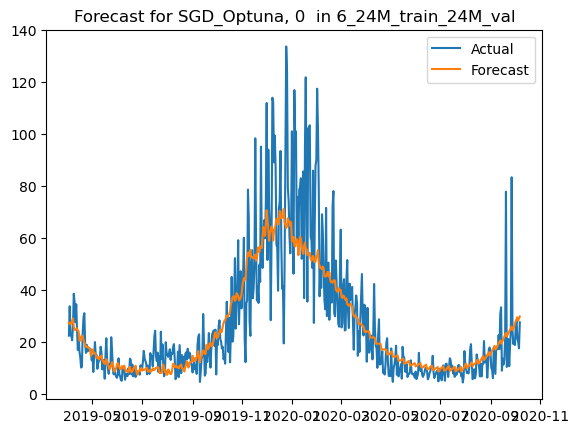

{'Apr_2019': 24.8066205203268, 'May_2019': 28.578644245877317, 'Jun_2019': 31.638192433250673, 'Jul_2019': 26.724712843876986, 'Aug_2019': 30.433824997888557, 'Sep_2019': 57.72729570340015, 'Oct_2019': 53.80147859756874, 'Nov_2019': 53.26390633598385, 'Dec_2019': 46.148450983036355, 'Jan_2020': 31.165805892359842, 'Feb_2020': 36.513332956679704, 'Mar_2020': 28.150108362694994, 'Apr_2020': 40.62079095241909, 'May_2020': 34.67789689156762, 'Jun_2020': 25.002388153019588, 'Jul_2020': 37.553804509143916, 'Aug_2020': 48.14759914544568, 'Sep_2020': 62.14105735195141, 'Oct_2020': 47.256278714501704}
{'test_30_days': 24.45569320431872, 'test_60_days': 26.755499442850116, 'test_90_days': 28.38306377108253, 'test_120_days': 27.993947303569456, 'test_150_days': 28.21667913108488, 'test_180_days': 32.5750364143089, 'test_240_days': 38.67535008067449, 'test_300_days': 38.34151529742261, 'test_360_days': 37.56050902762836, 'test_480_days': 36.32439567363433, 'test_600_days': 38.824745310440015, 'tes

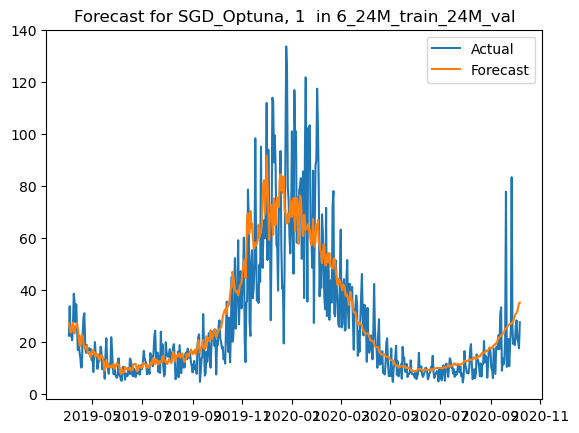

{'Apr_2019': 26.932291764385962, 'May_2019': 23.94230892974722, 'Jun_2019': 32.92647818717435, 'Jul_2019': 33.23073351041376, 'Aug_2019': 40.47482066143215, 'Sep_2019': 34.839081818851106, 'Oct_2019': 38.553829232835184, 'Nov_2019': 46.91051884837109, 'Dec_2019': 49.04351130438583, 'Jan_2020': 30.751253781008455, 'Feb_2020': 40.71820831741867, 'Mar_2020': 33.73725071381376, 'Apr_2020': 57.73509240404919, 'May_2020': 70.20454187200357, 'Jun_2020': 44.8085086638982, 'Jul_2020': 31.59006080540014, 'Aug_2020': 28.965631020247766, 'Sep_2020': 37.173589570494585, 'Oct_2020': 20.30987537027458}
{'test_30_days': 26.45121377995779, 'test_60_days': 25.38746729544876, 'test_90_days': 27.90047092451824, 'test_120_days': 28.98671580571992, 'test_150_days': 31.80496622547775, 'test_180_days': 31.47043662126052, 'test_240_days': 35.08343385631456, 'test_300_days': 35.666501449279224, 'test_360_days': 36.19025844041207, 'test_480_days': 40.02298387439976, 'test_600_days': 38.79485389089069, 'test_720_

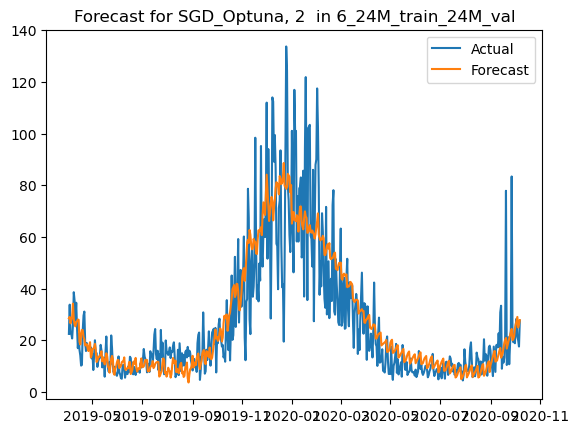

{'Apr_2019': 27.023554720611916, 'May_2019': 23.956789435668824, 'Jun_2019': 33.75211572525187, 'Jul_2019': 32.60532097046684, 'Aug_2019': 40.22745644213249, 'Sep_2019': 34.94861559085558, 'Oct_2019': 39.05168650955973, 'Nov_2019': 47.182292725533614, 'Dec_2019': 49.30649369072868, 'Jan_2020': 30.737432893230864, 'Feb_2020': 40.71475646263107, 'Mar_2020': 33.4672183441115, 'Apr_2020': 57.508482645802985, 'May_2020': 70.45159118046881, 'Jun_2020': 46.00953280574474, 'Jul_2020': 31.79404804980363, 'Aug_2020': 28.306386777265573, 'Sep_2020': 37.77046337819757, 'Oct_2020': 20.45180253075521}
{'test_30_days': 26.569066381621525, 'test_60_days': 25.439059322032325, 'test_90_days': 28.210078119462107, 'test_120_days': 29.05582488322886, 'test_150_days': 31.81223177414301, 'test_180_days': 31.471643610609934, 'test_240_days': 35.19327024239554, 'test_300_days': 35.784652306406315, 'test_360_days': 36.26868054860176, 'test_480_days': 40.17039997725359, 'test_600_days': 38.91847906227862, 'test_

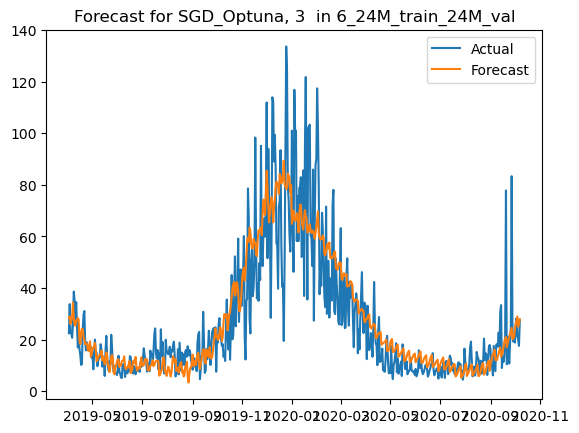

{'Apr_2019': 27.147369770277002, 'May_2019': 23.962173670470214, 'Jun_2019': 35.03289965334797, 'Jul_2019': 31.7675947623906, 'Aug_2019': 39.43115765205919, 'Sep_2019': 35.59506733262049, 'Oct_2019': 40.171118468630276, 'Nov_2019': 47.804693898982904, 'Dec_2019': 49.55298446119532, 'Jan_2020': 30.70766639585762, 'Feb_2020': 40.64447133322316, 'Mar_2020': 33.04520854212941, 'Apr_2020': 56.81455398758026, 'May_2020': 70.47093573519614, 'Jun_2020': 47.75944007905426, 'Jul_2020': 32.37423151552722, 'Aug_2020': 27.331835787671398, 'Sep_2020': 39.052801368648524, 'Oct_2020': 21.273476408439386}
{'test_30_days': 26.737784167980863, 'test_60_days': 25.50168511898072, 'test_90_days': 28.67875662657587, 'test_120_days': 29.199309270225783, 'test_150_days': 31.74920524913933, 'test_180_days': 31.498420186514046, 'test_240_days': 35.453616787138806, 'test_300_days': 36.02104840074037, 'test_360_days': 36.428150509627685, 'test_480_days': 40.390425072486686, 'test_600_days': 39.13499735323477, 'tes

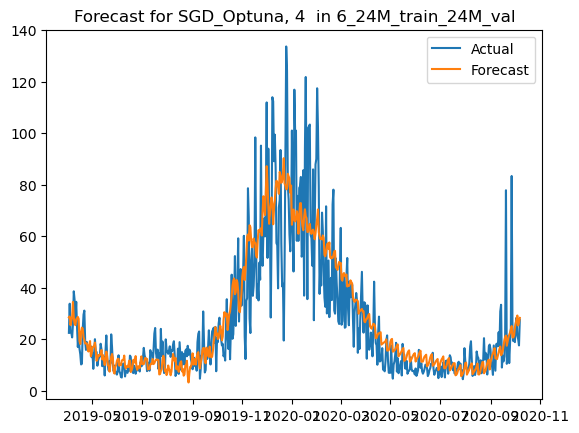

{'Apr_2019': 27.640971725193843, 'May_2019': 25.780584511496198, 'Jun_2019': 30.477743499630694, 'Jul_2019': 34.519236776539415, 'Aug_2019': 41.539016268342415, 'Sep_2019': 34.570977694668706, 'Oct_2019': 38.28385274538204, 'Nov_2019': 46.39258642395795, 'Dec_2019': 48.18035839553904, 'Jan_2020': 30.71556079433591, 'Feb_2020': 39.905160832454, 'Mar_2020': 33.4535015013168, 'Apr_2020': 60.50317255346124, 'May_2020': 71.26832939703235, 'Jun_2020': 40.59317077802593, 'Jul_2020': 30.28502957787436, 'Aug_2020': 30.346231566927383, 'Sep_2020': 36.55653524962355, 'Oct_2020': 20.561385335255686}
{'test_30_days': 27.30264967590043, 'test_60_days': 26.67977166520329, 'test_90_days': 27.94576227530602, 'test_120_days': 29.34225434574131, 'test_150_days': 32.30549434413856, 'test_180_days': 31.869547757166483, 'test_240_days': 35.280500334750734, 'test_300_days': 35.72228228007886, 'test_360_days': 36.149106946526885, 'test_480_days': 39.88203049093615, 'test_600_days': 38.72273130469322, 'test_72

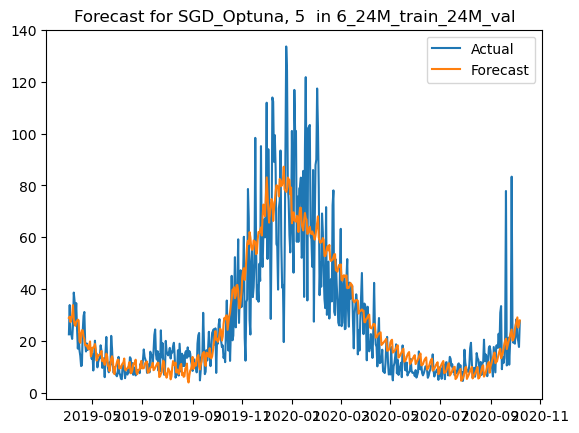

In [ ]:
# Process each dataset
for dataset_name, df in results.items():
# for dataset_name, df in results_left.items():
    print("=" * 80)
    print(f"DATASET: {dataset_name}")
    print("=" * 80)

    sensor_id, train_months, train_label = extract_train_info(dataset_name)
    if sensor_id is None:
        print("Skipping dataset: Cannot determine sensor ID or train length.")
        continue
    if train_months < 10:
        continue
    mape_columns_local = [c for c in MAPE_COLUMNS if c in df.columns]
    # print('here')
    # --- (a) Filtering Criteria ---

    # 1. Remove models exceeding the early horizon threshold
    local_early_horizons_threshold = EARLY_HORIZON_THRESHOLD
    local_one_third_thresh = ONE_THIRD_THRESHOLD
    # if train_months <= 12:
    #     local_early_horizons_threshold = 25
    #     local_one_third_thresh = 27
    if LONG_TRAIN_FILTER and train_months >= 24:
        local_early_horizons_threshold = 27
        local_one_third_thresh = 27
    early_horizon_cols = [f"test_{h}_days" for h in EARLY_HORIZONS if f"test_{h}_days" in df.columns]
    mask_early_horizon = (df[early_horizon_cols] <= local_early_horizons_threshold).all(axis=1)

    # 2. Ensure MAPE is good at 1/3 of train length
    one_third_horizon = int(train_months * 30 // 3)
    closest_horizon = min(HORIZONS, key=lambda x: abs(x - one_third_horizon))

    if f"test_{closest_horizon}_days" in df.columns:
        mask_one_third = df[f"test_{closest_horizon}_days"] <= local_one_third_thresh
    else:
        mask_one_third = True

    top_early = pd.DataFrame()
    if early_horizon_cols:
        df['early_avg_mape'] = df[early_horizon_cols].mean(axis=1)
        top_early = df.nsmallest(5, 'early_avg_mape').copy()
    top_closest = pd.DataFrame()
    if closest_horizon:
        top_closest = df.nsmallest(5, f"test_{closest_horizon}_days").copy()


    # Apply filters
    # df_filtered = df[mask_early_horizon & mask_one_third].copy()
    df_filtered = pd.concat([top_early, top_closest]).drop_duplicates()
    # --- (b) Extract best models and reconstruct `MLForecast` ---
    # Use joblib to parallelize the processing of rows
    print(df_filtered[['Model', 'test_30_days', 'test_60_days', 'test_90_days', 'test_180_days', 'test_360_days']])

    # for _, row in df_filtered.iterrows():
        # process_row(row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors)
    results_list = Parallel(n_jobs=-1)(  # Use all available cores
        delayed(process_row)(row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors)
        for _, row in df_filtered.iterrows()
    )

    # Filter out None results (failed models or models not meeting criteria)
    good_winter_models.extend(r for r in results_list if r is not None)

    for index, result in enumerate(results_list):
        if result and 'plot_data' in result:
            plot_data = result['plot_data']
            test_df_copy = plot_data['test_df_copy']
            model_name = plot_data['model_name']
            dataset_name = plot_data['dataset_name']

            # Generate the plot
            print(result['sorted_mape'])
            print(result['test_vals'])
            plt.figure()  # Create a new figure for each plot
            plt.plot(test_df_copy['ds'], test_df_copy['y'], label='Actual')
            plt.plot(test_df_copy['ds'], test_df_copy['forecast'], label='Forecast')
            plt.title(f"Forecast for {model_name}, {index}  in {dataset_name}")
            plt.legend()
            plt.show()  


# After processing all datasets, convert to DataFrame (optional)
good_winter_models_df = pd.DataFrame(good_winter_models)

In [27]:
good_winter_models_df = pd.DataFrame(good_winter_models)

def calculate_lags_name(lags_str):
    try:
        lags = eval(lags_str) if isinstance(lags_str, str) else lags_str
        return f'{len(lags)}_{max(lags)}'
    except:
        return "Error"  # Handle potential errors, e.g., invalid string
# good_winter_models_df['lags_name'] = good_winter_models_df['lags'].apply(calculate_lags_name)
 
good_winter_models_df

StopIteration: 

StopIteration: 

In [43]:
from mlforecast.lag_transforms import RollingMean, ExpandingMean, ExponentiallyWeightedMean

transform_mapping = {
    "AutoDifferences" : AutoDifferences, 
    "AutoSeasonalDifferences" : AutoSeasonalDifferences, 
    "AutoSeasonalityAndDifferences" : AutoSeasonalityAndDifferences,
    "LocalStandardScaler" : LocalStandardScaler, 
    "LocalMinMaxScaler" : LocalMinMaxScaler, 
    "LocalBoxCox" : LocalBoxCox
}

def process_row_with_fit(row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors, transform_mapping, horizon=None):
    """Processes a single row (model) from the filtered DataFrame."""
    model_name = row["Model"]
    transforms_str = row["Transforms"]
    lags = row["Lags"]
    lag_transforms_str = row["Lag Transforms"]

    # Reverse transforms
    transform_objects = []
    if isinstance(transforms_str, str):
        for transform_str in transforms_str.split(" | "):
            class_name, params = parse_transform_string(transform_str)

            if class_name in transform_mapping:
                transform_objects.append(transform_mapping[class_name](**params) if params else transform_mapping[class_name]())
            else:
                raise ValueError(f"Unknown transform: {class_name}")

    # Reverse lag transforms
    lag_transforms = get_lag_transforms(lag_transforms_str)

    # Prepare dataset
    sensor_id = str(sensor_id)
    scenario = scenarios_sensors[sensor_id][train_label]

    if sensor_id not in scenarios_sensors:
        return None  # Skip this model

    formatted_df = format_df_to_mlforecast(
        selected_sensors_df[['full_date', sensor_id]], 'full_date', sensor_id, unique_id=sensor_id
    )
    formatted_df = formatted_df[['ds', 'y', 'unique_id']]
    train_df, test_df = split_data(formatted_df, scenario)

    # Initialize MLForecast
    model_instance = SGDRegressor(**eval(row['params']), random_state=42)
    if model_instance is None:
        raise ValueError(f"Model {model_name} not found in model_mapping")

    #Crucial: Convert lags to a list *before* passing it to MLForecast
    lags_list = ast.literal_eval(lags) if isinstance(lags, str) else lags

    if horizon is None:
        horizon = test_df.shape[0]

    fcst = MLForecast(
        models=[model_instance],
        freq='D',
        lags=lags_list,  # Use the converted list
        target_transforms=transform_objects,
        date_features=['dayofweek', 'month'],
        num_threads=1,
        lag_transforms=lag_transforms,
    )

    fcst.fit(train_df)
    predictions = fcst.predict(h=horizon)
    # test_df_copy = test_df.copy()
    # test_df_copy['forecast'] = predictions[get_sgdreg_name(model_name)].values

    # sorted_mape, sorted_counts, detailed_df, mape_by_year_month = calculate_monthly_mape(test_df_copy)

    # covid_year = [2020]
    # winter_months = [1, 2, 3, 10, 11, 12]  # Jan, Feb, Mar, Oct, Nov, Dec
    # winter_mape_full = detailed_df[detailed_df['month'].isin(winter_months)]
    # winter_mape = winter_mape_full[~winter_mape_full['year'].isin(covid_year)]
    # mean_winter_mape = winter_mape['mape'].mean()
    # year_winter_mean_mape = winter_mape_full.groupby('year')['mape'].mean().to_dict()

    return {
        'dataset': dataset_name,
        'model_name': model_name,
        'transforms_str': transforms_str,
        'lags': lags,
        'lag_transforms_str': lag_transforms_str,
        # 'mean_winter_mape': mean_winter_mape,
        # **year_winter_mean_mape,
        'plot_data_preds': predictions,
        'plot_data_actual': test_df['y'],
    }

def plot_with_mismatched_lengths(predictions_df, models_look_up_results):
    """
    Plots two time series with potentially different lengths, ensuring all dates
    from predictions_df are shown.  Fills missing actual values with NaN.

    Args:
        predictions_df: DataFrame with a 'ds' column (datetime) and potentially other columns.
        models_look_up_results: Dictionary containing 'plot_data_actual' (array-like).
    """

    # Convert 'plot_data_actual' to a Pandas Series for easier handling.
    # Use the index from the first data point to match the correct slice
    actual_data = pd.Series(models_look_up_results['plot_data_actual'])

    # Create a dataframe with the actual data and a proper datetime index
    # Assuming you have the start datetime index corresponding to `plot_data_actual`
    # This part needs to be adapted to your specific data structure
    try:
        start_date = predictions_df['ds'].min()  # Or some other relevant start date
        actual_data_df = pd.DataFrame({'ds': pd.date_range(start_date, periods=len(actual_data)),
                                   'actual': actual_data.values})
    except KeyError as e:
        print(f"Error: Missing column 'ds' in predictions_df: {e}")
        return
    except ValueError as e:
         print(f"Error: Likely the number of points is not equal to number of time intervals provided, check start date: {e}")
         return


    # Merge the two dataframes on 'ds' (the date column).  This will result in NaN
    # values for 'actual' where there's no corresponding data in
    # models_look_up_results.
    merged_df = pd.merge(predictions_df, actual_data_df, on='ds', how='left')

    # Now plot using the merged dataframe
    plt.plot(merged_df['ds'], merged_df['actual'], label='Actual')
    plt.plot(predictions_df['ds'],predictions_df['yhat'], label='Prediction') # Assuming yhat is in predictions_df

    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Actual vs. Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

6 24 24M_train_24M_val


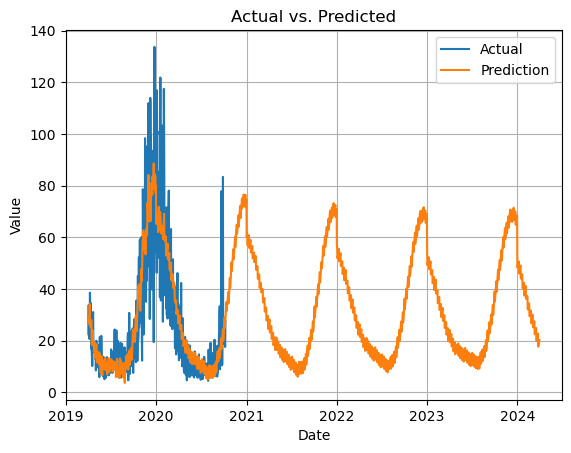

6 24 24M_train
Error parsing lag transforms string: not enough values to unpack (expected 2, got 1)


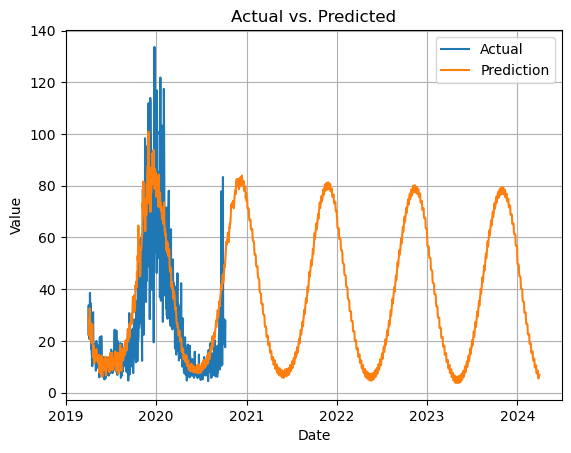

6 20 20M_train_4M_val


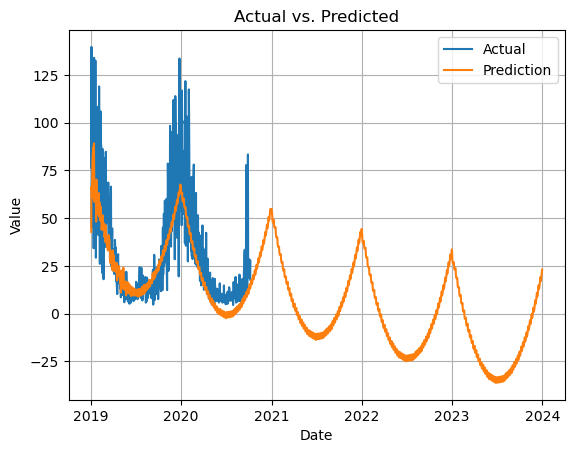

5 24 24M_train_24M_val


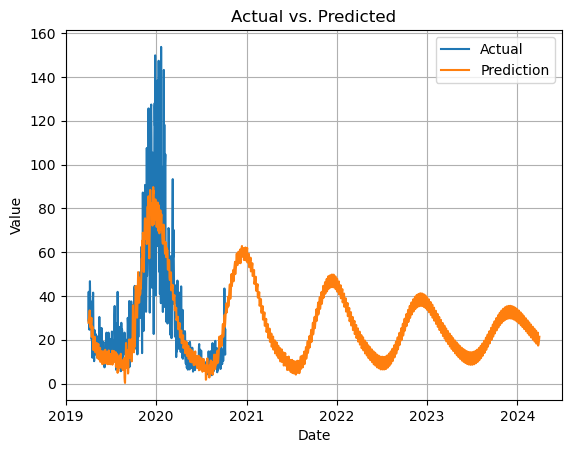

5 20 20M_train_4M_val
Error parsing lag transforms string: not enough values to unpack (expected 2, got 1)


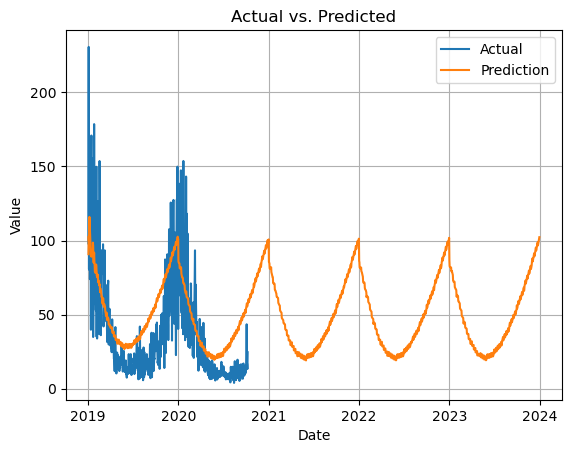

5 12 12M_train_12M_val
Error parsing lag transforms string: not enough values to unpack (expected 2, got 1)


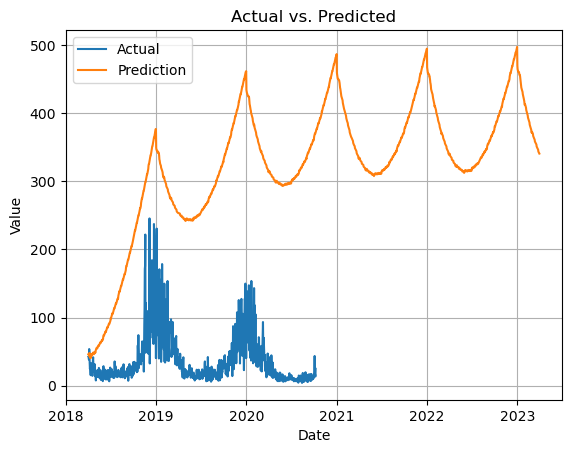

In [47]:
models_to_look_up = {'6_24M_train_24M_val': 381 ,
                    '6_24M_train': 219      ,
                    '6_20M_train_4M_val': 168,
                    '5_24M_train_24M_val': 420,
                    '5_24M_train_24M_val': 428,
                    '5_20M_train_4M_val': 39,
                    '5_12M_train_12M_val': 47,
                    }

for dataset_name, model_id in models_to_look_up.items():
    df = results[dataset_name].copy()
    model_info_row = df.iloc[model_id]
    sensor_id, train_months, train_label = extract_train_info(dataset_name)

    models_look_up_results = process_row_with_fit(model_info_row, dataset_name, sensor_id, train_label, selected_sensors_df, scenarios_sensors, transform_mapping, horizon=365*5)

    predictions_df = models_look_up_results['plot_data_preds']
    predictions_df.rename(columns={'SGDRegressor': 'yhat'}, inplace=True)

    plot_with_mismatched_lengths(predictions_df, models_look_up_results)

In [28]:
good_winter_models

[{'dataset': '5_12M_train_12M_val',
  'model_name': 'SGD_Optuna',
  'transforms_str': 'AutoSeasonalityAndDifferences(max_diffs=188, max_season_length=125, n_seasons=10) | LocalMinMaxScaler(stats_=[[  5.1691023  286.54204218]])',
  'lags': '[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 20, 21, 22, 24, 25, 28, 44, 49, 63, 64, 75, 76, 77, 80, 89, 90]',
  'lag_transforms_str': '{7: [RollingMean(window_size=7), RollingStd(window_size=7), ExpandingStd()], 14: [RollingMean(window_size=14), ExpandingStd(), ExponentiallyWeightedMean(alpha=0.3)], 30: [RollingMean(window_size=30)], 60: [ExpandingMean()]}',
  'val_mape': 44.796212498939184,
  'test_mape': 53.07028561743912,
  'mean_winter_mape': 57.36360320072526,
  2018: 52.76166560730848,
  2019: 60.35268616083071,
  2020: 56.33143195562969,
  'sorted_mape': {'Apr_2018': 24.000582213707116,
   'May_2018': 29.329477515003884,
   'Jun_2018': 29.936949706303828,
   'Jul_2018': 25.69093549588761,
   'Aug_2018': 22.570618425418893,
   'Sep_201